In [1]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
# Cart pole system parameters
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 100                                                     # Number of trajectories to execute, data collection
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust]) - hover_thrust    # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

[ 1.93569302 -1.19093911  0.32218136 -0.88739808 -0.1091196  -0.51220303]
[ 1.92664043 -1.19198268  0.31706515 -0.92302917 -0.09956312 -0.51103881]
[ 1.91722085 -1.1928886   0.31193105 -0.9607879  -0.08158912 -0.51578062]
[ 1.90755405 -1.1940112   0.30672753 -0.97253885 -0.14292105 -0.52492364]
[ 1.89767833 -1.19545337  0.3015027  -1.00252206 -0.1454864  -0.52004186]
[ 1.88743825 -1.19670355  0.29623962 -1.04537284 -0.10451071 -0.53257405]
[ 1.87688429 -1.19790869  0.29100358 -1.06536105 -0.1365001  -0.51463449]
[ 1.86610345 -1.19933673  0.28593853 -1.09073585 -0.14908639 -0.49837516]
[ 1.8549534  -1.20048745  0.28084203 -1.13913248 -0.08101707 -0.52092593]
[ 1.84350304 -1.20158214  0.27566397 -1.15090316 -0.13791161 -0.51468604]
[ 1.83180204 -1.2027686   0.27050586 -1.18918058 -0.09934762 -0.51693543]
[ 1.81981369 -1.20390208  0.26530362 -1.2084281  -0.12733163 -0.52351348]
[ 1.80747527 -1.20472411  0.26011836 -1.25909255 -0.0370302  -0.51353686]
[ 1.79478386 -1.2052048   0.25522036 -

[-0.26175537 -1.37289243 -0.16093017 -1.5410312  -0.13390095 -0.2348061 ]
[-0.27709714 -1.37430173 -0.16320207 -1.52729008 -0.14796413 -0.2195744 ]
[-0.29234033 -1.37609226 -0.16539339 -1.5213347  -0.21014356 -0.21868841]
[-0.30751937 -1.37847958 -0.16754195 -1.51445884 -0.26732292 -0.21102508]
[-0.32251808 -1.38078445 -0.169626   -1.4852244  -0.19366171 -0.20578493]
[-0.3372651  -1.38259966 -0.1716308  -1.46413759 -0.16938659 -0.19517457]
[-0.35177894 -1.3840511  -0.17359787 -1.43858266 -0.12091127 -0.1982395 ]
[-0.36605181 -1.3851091  -0.17562375 -1.41594784 -0.09069587 -0.2069358 ]
[-0.38012499 -1.38602217 -0.1776217  -1.39865673 -0.09192411 -0.19265394]
[-0.39398964 -1.38675529 -0.1795573  -1.37423036 -0.05470631 -0.19446606]
[-0.4076896  -1.38756039 -0.18153703 -1.36574491 -0.10631802 -0.20147962]
[-0.42125524 -1.38861583 -0.1836029  -1.3473494  -0.10477655 -0.21169445]
[-0.43468512 -1.38992014 -0.18565221 -1.33861098 -0.15608848 -0.19816826]
[-0.44794098 -1.39128054 -0.1876392  -

[-0.14040772 -0.96477606 -0.07822231 -1.44831323 -0.96873995 -0.79630452]
[-0.15484685 -0.97441103 -0.08614385 -1.43936938 -0.95826591 -0.78800343]
[-0.16919895 -0.98401688 -0.09408063 -1.43092641 -0.96291588 -0.79935266]
[-0.18343402 -0.99337221 -0.1021816  -1.4158818  -0.90816893 -0.82084138]
[-0.19752887 -1.002337   -0.11044947 -1.40292083 -0.88480679 -0.83273288]
[-0.21148247 -1.01101069 -0.1188021  -1.38761446 -0.84995381 -0.83779299]
[-0.22531165 -1.0196164  -0.12725298 -1.37811252 -0.87120192 -0.85238217]
[-0.23900978 -1.02818461 -0.13580468 -1.36133319 -0.84246237 -0.85795728]
[-0.25254673 -1.03655242 -0.14438229 -1.34590036 -0.83112334 -0.85756566]
[-0.26589822 -1.04462918 -0.15291502 -1.32419035 -0.78425857 -0.84898106]
[-0.27905137 -1.05239702 -0.16138829 -1.30628055 -0.76933525 -0.8456711 ]
[-0.29200077 -1.05989641 -0.16973654 -1.28340959 -0.73057395 -0.82397944]
[-0.30472503 -1.06706207 -0.1778484  -1.26127068 -0.70258782 -0.7983938 ]
[-0.31726541 -1.0741821  -0.18575055 -

[ 1.8818238   0.27117405  0.53357448 -0.47662293 -1.22190283 -0.22056652]
[ 1.87685915  0.25880102  0.53107083 -0.51627984 -1.25268597 -0.28016529]
[ 1.87130483  0.24645172  0.52804382 -0.59451582 -1.21713446 -0.32523568]
[ 1.86500311  0.23440276  0.52457204 -0.66575846 -1.19261733 -0.36912077]
[ 1.85789101  0.22277387  0.52064731 -0.75655883 -1.1331008  -0.41582439]
[ 1.85020479  0.21116341  0.51634121 -0.78065329 -1.18897404 -0.44539693]
[ 1.84212873  0.19925959  0.51176876 -0.83448594 -1.19174787 -0.46909267]
[ 1.8333509   0.18762534  0.50693589 -0.92095662 -1.13503224 -0.49748007]
[ 1.8239548   0.17612176  0.50173918 -0.95820486 -1.16565308 -0.54186222]
[ 1.81418359  0.16432106  0.49611855 -0.99597194 -1.19445012 -0.58226483]
[ 1.80371454  0.15283152  0.49005723 -1.097647   -1.10335637 -0.62999891]
[ 1.7925087   0.14173966  0.48339668 -1.14342425 -1.11496477 -0.70211152]
[ 1.78101728  0.13020907  0.4760991  -1.15483365 -1.19113834 -0.75740337]
[ 1.76906713  0.11859127  0.46845987 -

[-0.55327433  0.10207319 -0.28079131 -1.16654989  1.05601873  0.0052062 ]
[-0.56486441  0.11240436 -0.28086876 -1.15146568  1.01021638 -0.02069442]
[-0.57624458  0.12248213 -0.28091345 -1.12456718  1.00533636  0.01175629]
[-0.58736951  0.13246349 -0.28082958 -1.10042037  0.99093645  0.00501586]
[-0.59818115  0.14254996 -0.2807692  -1.06190979  1.02635816  0.0070614 ]
[-0.60873144  0.15256169 -0.2805939  -1.04814893  0.97598733  0.02799873]
[-0.61919287  0.16190068 -0.28037785 -1.04413787  0.89181129  0.01521163]
[-0.62956628  0.17056437 -0.28030826 -1.03054399  0.84092687 -0.00129441]
[-0.6397586   0.17887602 -0.28047067 -1.00791798  0.82140333 -0.03118721]
[-0.64965775  0.18722433 -0.28065319 -0.97190827  0.84825626 -0.0053162 ]
[-6.59186567e-01  1.95876400e-01 -2.80682947e-01 -9.33854476e-01
  8.82158242e-01 -6.36161083e-04]
[-0.66842536  0.20455346 -0.28077909 -0.91390344  0.85325346 -0.01859254]
[-0.67747524  0.21290454 -0.28115067 -0.89606771  0.81696165 -0.05572311]
[-0.68629487 

[-0.12019175  0.28657311  0.09681923  1.88253503 -0.35551102  0.11858908]
[-0.10142544  0.28313287  0.09798346  1.87070454 -0.33253853  0.11425642]
[-0.0827805   0.27994639  0.09903905  1.85826203 -0.30476062  0.09686061]
[-0.06424239  0.2768549   0.099892    1.8493464  -0.31353839  0.07373085]
[-0.0457922   0.2736597   0.10066312  1.84068032 -0.32550244  0.08049241]
[-0.02742408  0.27029617  0.10138394  1.83293492 -0.34720488  0.0636717 ]
[-0.00914791  0.26685531  0.10198118  1.82228836 -0.34096887  0.05577706]
[ 0.0090245   0.26344735  0.10267882  1.81218144 -0.34062343  0.08374932]
[ 0.02712514  0.25975551  0.10354969  1.8079412  -0.39774531  0.09042658]
[ 0.04515188  0.25579293  0.10442643  1.79739225 -0.39477182  0.08492026]
[ 0.06304532  0.2521206   0.10524297  1.78127417 -0.33969592  0.07838796]
[ 0.08075579  0.24919889  0.10602198  1.76079524 -0.24464936  0.07741326]
[ 0.09829848  0.24687348  0.10695173  1.74772402 -0.2204341   0.1085384 ]
[ 0.11573589  0.24454841  0.10798288  

[-2.0921246  -1.01222154 -0.51058536  0.91537837  0.59471625  0.69498869]
[-2.08269522 -1.00627016 -0.50355074  0.97038104  0.59562487  0.7119343 ]
[-2.07282976 -1.00050932 -0.49634467  1.00264071  0.55658111  0.72928095]
[-2.06265275 -0.99515429 -0.48885506  1.03269068  0.51446359  0.76864009]
[-2.05197059 -0.98982813 -0.48115962  1.10356929  0.55085964  0.77044912]
[-2.0406597  -0.98427959 -0.47332482  1.15846848  0.55891927  0.7965103 ]
[-2.02890915 -0.9788549  -0.46531237  1.1915552   0.52606377  0.80597857]
[-2.0168106  -0.97371781 -0.45720118  1.22805639  0.501403    0.81626006]
[-2.00418909 -0.96849646 -0.44899318  1.29605428  0.5429606   0.82534004]
[-1.99095373 -0.96298292 -0.44064775  1.35085722  0.55982337  0.84374536]
[-1.97726221 -0.95748438 -0.43215065  1.38733591  0.53993648  0.85567533]
[-1.9630929  -0.951929   -0.42359877  1.44634239  0.57122241  0.85470026]
[-1.94846587 -0.94634162 -0.41486206  1.47895694  0.54630044  0.89264121]
[-1.93354539 -0.94106945 -0.40576566  

[-1.69729902 -1.48854343 -0.36546768  0.22645003 -0.39553112  0.36504167]
[-1.69475341 -1.49225192 -0.36172058  0.28257808 -0.34613155  0.3843782 ]
[-1.6917222  -1.49565866 -0.35778936  0.32359318 -0.33518936  0.40186712]
[-1.68841242 -1.49930271 -0.35365585  0.33833577 -0.39361065  0.42483386]
[-1.68490946 -1.50340391 -0.34925053  0.36220792 -0.42661174  0.45623045]
[-1.68109888 -1.50764042 -0.34456752  0.39982776 -0.42066085  0.48037265]
[-1.67692725 -1.51185206 -0.33979037  0.4344212  -0.42163884  0.47505698]
[-1.6723737  -1.51596377 -0.33501769  0.47619325 -0.40067008  0.47947788]
[-1.66752557 -1.52021208 -0.33017793  0.49339301 -0.44897897  0.48847453]
[-1.66242283 -1.52469723 -0.32540274  0.52707562 -0.44802338  0.46656458]
[-1.65685469 -1.52878195 -0.3206383   0.58641238 -0.36887351  0.48632295]
[-1.65085058 -1.53253735 -0.31568815  0.61433915 -0.3821846   0.50370653]
[-1.64454355 -1.5363458  -0.31063344  0.6469825  -0.37947732  0.50723572]
[-1.638014   -1.54044393 -0.30544472  

[ 1.58722735 -0.77237469  0.06577953  0.79973536  0.15298888  0.10107905]
[ 1.59520372 -0.77101847  0.06675465  0.79552973  0.11825506  0.09394428]
[ 1.60311844 -0.76972226  0.06771889  0.7873937   0.14098574  0.09890354]
[ 1.6109784  -0.76859782  0.06861784  0.78459281  0.08390088  0.08088732]
[ 1.61877784 -0.76757548  0.06940738  0.7752771   0.12056573  0.07701973]
[ 1.62650856 -0.76654422  0.0701097   0.77085908  0.08568573  0.06344484]
[ 1.63418095 -0.76566406  0.07080159  0.76360807  0.09034538  0.07493282]
[ 1.64177562 -0.76466929  0.07156566  0.75531126  0.10860756  0.07788016]
[ 1.64928387 -0.76345017  0.07233753  0.7463227   0.13521503  0.0764942 ]
[ 1.65671926 -0.76220563  0.07306185  0.74074523  0.11369197  0.06837074]
[ 1.6640796  -0.76091763  0.07376006  0.73130876  0.14390828  0.07127097]
[ 1.67135246 -0.75942633  0.07449267  0.7232486   0.15434933  0.07525017]
[ 1.67855237 -0.75793838  0.07525016  0.71672332  0.14324052  0.07624877]
[ 1.68568681 -0.75656287  0.07591622  

[-0.81245553  0.15616786  0.18254694 -0.47214584  1.52102156 -0.02567235]
[-0.81723072  0.17117881  0.18225978 -0.4828901   1.48116904 -0.03176123]
[-0.8221658   0.18607641  0.18198421 -0.50411987  1.49835084 -0.02335191]
[-0.8272522   0.20081514  0.18176687 -0.51315808  1.44939694 -0.02011657]
[-0.83243987  0.21512396  0.18150913 -0.52437471  1.41236573 -0.03143137]
[-0.83773425  0.22903315  0.1812006  -0.53449815  1.36947387 -0.03027528]
[-0.84311512  0.24243334  0.18095707 -0.54167279  1.31056369 -0.01842904]
[-0.84862563  0.25556124  0.18081062 -0.56042736  1.31501699 -0.01086117]
[-0.85424531  0.26830522  0.18074649 -0.56350934  1.23377997 -0.00196622]
[-0.85998237  0.28071055  0.18065202 -0.58390026  1.24728575 -0.01692706]
[-0.86590373  0.29314394  0.1805406  -0.60036998  1.23939337 -0.00535734]
[-0.8719799   0.30544449  0.18044841 -0.61486351  1.22071555 -0.01307962]
[-0.87811385  0.31708059  0.18032051 -0.61192555  1.10650535 -0.01250158]
[-0.88431948  0.32812911  0.18018728 -

[ 0.47576785  0.47887982  0.16250361  0.33347415 -0.52289154  0.1150878 ]
[ 0.4789496   0.47409148  0.16353766  0.30284264 -0.43478211  0.09172062]
[ 0.48193926  0.46948762  0.16437866  0.295084   -0.48598973  0.07648069]
[ 0.48478046  0.46479726  0.16499655  0.2731426  -0.45208597  0.0470975 ]
[ 0.48744788  0.4601699   0.16556848  0.2603334  -0.47338619  0.06728855]
[ 0.4899852   0.45534009  0.16621744  0.24712139 -0.49257829  0.06250286]
[ 0.49236655  0.45045877  0.16677127  0.22914004 -0.4836861   0.04826233]
[ 0.49455982  0.44571391  0.16712791  0.20950542 -0.46528761  0.02306627]
[ 0.49656193  0.44112121  0.1673231   0.19091383 -0.45325307  0.01597189]
[ 0.49838389  0.43661417  0.1674754   0.17347511 -0.44815437  0.01448882]
[ 0.49997159  0.43251178  0.16747895  0.14406624 -0.37232483 -0.01378033]
[ 0.50128046  0.42907786  0.16726945  0.11771277 -0.31445684 -0.02811828]
[ 0.50243786  0.42555971  0.16686486  0.11376906 -0.38917426 -0.05280033]
[ 0.50346712  0.42182204  0.16619349  

[-1.39516364  0.90760235 -0.30692068 -0.39206736 -1.2784944   0.13693605]
[-1.39892815  0.89482045 -0.30539526 -0.36086085 -1.27787869  0.16814775]
[-1.40224638  0.88247414 -0.3035682  -0.30284068 -1.19136589  0.19726398]
[-1.40504056  0.87081942 -0.30159431 -0.25604601 -1.13956319  0.19751382]
[-1.40730749  0.85987911 -0.29955626 -0.19740256 -1.04847748  0.21009569]
[-1.40915512  0.8493141  -0.29749092 -0.17215153 -1.06451711  0.2029737 ]
[-1.41074491  0.83860912 -0.29538342 -0.14583733 -1.07646842  0.21852579]
[-1.41203003  0.82792483 -0.29316581 -0.11122836 -1.06037752  0.22499578]
[-1.4129921   0.8173295  -0.29094262 -0.08122373 -1.05867711  0.21964279]
[-1.41369906  0.80660474 -0.28871633 -0.06019509 -1.08626623  0.22561589]
[-1.41412298  0.79585269 -0.28640784 -0.02463327 -1.06413117  0.23608183]
[-1.41420696  0.7852737  -0.28416601  0.00779522 -1.05165399  0.21228351]
[-1.41402188  0.77463441 -0.28208435  0.02919559 -1.0761964   0.2040489 ]
[-1.41370301  0.76347502 -0.28014346  

[ 1.037517    1.28894022  0.20328664 -1.98831529  1.03607749 -0.96008224]
[ 1.0175259   1.29934276  0.19368176 -2.00973324  1.04446393 -0.96089276]
[ 0.99738907  1.30950175  0.18410125 -2.01756775  0.98734672 -0.95521037]
[ 0.97714434  1.31926219  0.17461864 -2.03125863  0.96476329 -0.9413113 ]
[ 0.95678465  1.32869128  0.16535179 -2.04059576  0.92107026 -0.91205801]
[ 0.93630876  1.33783862  0.15613319 -2.05445172  0.90841746 -0.93166317]
[ 0.91572549  1.34668351  0.14677605 -2.06212221  0.8605728  -0.93976344]
[ 0.89498872  1.35559768  0.13735544 -2.08498249  0.92229783 -0.94435928]
[ 0.8740849   1.36473004  0.12793579 -2.09565546  0.90419009 -0.93957029]
[ 0.8530414   1.37397445  0.1185413  -2.11282687  0.94471891 -0.93932792]
[ 0.83184236  1.38354166  0.10916062 -2.12679118  0.96874508 -0.93680837]
[ 0.81051892  1.39326021  0.099913   -2.13773604  0.9749822  -0.91271508]
[ 0.78910524  1.40289321  0.09078971 -2.14488482  0.95162846 -0.91194318]
[ 0.7675974   1.41258952  0.08167409 -

[ 1.68020552  0.92890941  0.40259817  0.38930793  1.32452089 -0.18255047]
[ 1.68393027  0.94206006  0.40074657  0.35566651  1.30561982 -0.18776934]
[ 1.68739527  0.95484248  0.39887665  0.33734823  1.25086954 -0.18621657]
[ 1.69062883  0.96719325  0.39702873  0.30938293  1.21929353 -0.18336556]
[ 1.69365628  0.97905424  0.39532834  0.2961175   1.15290854 -0.1567136 ]
[ 1.69636363  0.99070197  0.39381356  0.24538279  1.1766504  -0.14624132]
[ 1.69867627  1.00231823  0.39240804  0.2171606   1.14660735 -0.1348627 ]
[ 1.70063324  1.01381306  0.39104589  0.1742578   1.15236866 -0.13756777]
[ 1.70214504  1.02540674  0.38968101  0.12812756  1.16637738 -0.13540794]
[ 1.70312662  1.0373107   0.38834288  0.06822065  1.21442842 -0.13221771]
[ 1.70373945  1.04913428  0.38698785  0.05435222  1.15029178 -0.13878992]
[ 1.7041436   1.06048913  0.38559157  0.0264949   1.12068341 -0.1404658 ]
[ 1.70416815  1.07179852  0.38420169 -0.02155888  1.14120579 -0.13751087]
[ 1.7039434   1.08274275  0.3826213  -

[ 2.2697072   0.13964784  0.44049289 -0.33539027  0.82412668 -0.30637651]
[ 2.26617411  0.14777977  0.43735186 -0.37118832  0.80227704 -0.32182988]
[ 2.26238302  0.15548192  0.43398341 -0.38700968  0.73816279 -0.35185991]
[ 2.25826114  0.16291802  0.43039775 -0.43730131  0.74908702 -0.36527039]
[ 2.25366858  0.17039814  0.42672419 -0.48115207  0.74696477 -0.36944271]
[ 2.24863378  0.17787003  0.42283969 -0.5257444   0.74744216 -0.40745805]
[ 2.24318491  0.18528092  0.41873456 -0.56397157  0.73476159 -0.41356629]
[ 2.2373238   0.19263732  0.41468829 -0.60818284  0.73654786 -0.39568793]
[ 2.23118895  0.19963317  0.41080359 -0.61877134  0.66262885 -0.38125304]
[ 2.22481423  0.20619978  0.40700106 -0.65611852  0.65071633 -0.37925256]
[ 2.2179836   0.21284371  0.40313808 -0.70992713  0.67810407 -0.39334332]
[ 2.21074876  0.21945326  0.39921484 -0.73699818  0.643824   -0.39130468]
[ 2.20308098  0.22610952  0.39517542 -0.79646191  0.68746776 -0.41657965]
[ 2.19506336  0.23262126  0.39093374 -

[ 0.29286493  1.09112536 -0.15675339  0.46492886 -0.06969628 -0.07667544]
[ 0.29761151  1.09055246 -0.15751088  0.48440273 -0.04488612 -0.07482395]
[ 0.30252636  1.09005828 -0.15826103  0.49857815 -0.05395056 -0.07520507]
[ 0.30761925  1.0896983  -0.15904011  0.52001728 -0.0180481  -0.08061194]
[ 0.31292841  1.08970564 -0.1598807   0.54183434  0.01951326 -0.08750592]
[ 0.31840198  1.08975205 -0.16082172  0.55288909 -0.01023298 -0.10069795]
[ 0.32399548  1.08955669 -0.16174835  0.56582321 -0.02884212 -0.08462744]
[ 0.32973139  1.08925296 -0.16259397  0.58137179 -0.03190657 -0.08449694]
[ 0.33562849  1.08895077 -0.16348743  0.5980633  -0.02853386 -0.09419443]
[ 0.34169638  1.08870289 -0.16443342  0.61553274 -0.02104317 -0.0950037 ]
[ 0.34793985  1.08853211 -0.16536149  0.63317677 -0.01311716 -0.09061132]
[ 0.35439621  1.08865566 -0.16623259  0.65811728  0.03782456 -0.08360849]
[ 0.36106433  1.08906077 -0.16704288  0.67552126  0.04319534 -0.07844976]
[ 0.36791008  1.08953831 -0.16781748  

[-0.63119694 -0.66047493 -0.09790544  0.37390667 -1.04141361  0.31009546]
[-0.62739083 -0.6706897  -0.09486182  0.38724562 -1.00153432  0.29862764]
[-0.6234654  -0.6806328  -0.09184993  0.39778434 -0.98708007  0.30375177]
[-0.61945845 -0.69067461 -0.08892131  0.40357471 -1.02127872  0.28197151]
[-0.61538488 -0.70094916 -0.0861412   0.41109915 -1.03362895  0.27404968]
[-0.61121434 -0.71107893 -0.08337707  0.42294431 -0.99231953  0.27877739]
[-0.60695554 -0.72113718 -0.08036895  0.42878053 -1.01932703  0.32284517]
[-0.60264001 -0.731472   -0.07706865  0.43428672 -1.04763465  0.33721522]
[-0.59826073 -0.7419603  -0.07363558  0.4415136  -1.05002112  0.3493998 ]
[-0.59381047 -0.75246713 -0.07005635  0.44848027 -1.05134038  0.36644646]
[-0.58927873 -0.76279013 -0.06633529  0.45778338 -1.01325322  0.377765  ]
[-0.58465797 -0.77275429 -0.06249818  0.46628529 -0.97957334  0.38965761]
[-0.57994371 -0.78220149 -0.058558    0.47645639 -0.90985941  0.39837837]
[-0.57514404 -0.79117803 -0.05469353  

[-1.91192621 -0.04424172 -0.33545161  1.29559343  0.49740363  0.7733255 ]
[-1.89876736 -0.03917123 -0.32765355  1.33602561  0.51674597  0.78628485]
[-1.8851604  -0.03376216 -0.31972855  1.38517258  0.56513366  0.79871684]
[-1.87123599 -0.02837981 -0.31173613  1.3996505   0.51135464  0.79976699]
[-1.8572124  -0.02367197 -0.30392077  1.40504421  0.43022124  0.7633037 ]
[-1.84298322 -0.01928524 -0.29629917  1.44064636  0.44716927  0.76101676]
[-1.828428   -0.0148123  -0.28858244  1.47027007  0.44745676  0.78232956]
[-1.81362174 -0.01047603 -0.28076286  1.49089018  0.41982406  0.78158572]
[-1.79850983 -0.00605738 -0.2729775   1.53130816  0.46395915  0.77548655]
[-1.78300972e+00 -1.23355373e-03 -2.65240191e-01  1.56853925e+00
  5.00854280e-01  7.71975546e-01]
[-1.76723032  0.00363413 -0.25756295  1.58725228  0.47270555  0.76347177]
[-1.75119087  0.00851102 -0.2498886   1.62047416  0.50271635  0.7713991 ]
[-1.734875    0.01348783 -0.24206986  1.64258367  0.49267327  0.79234873]
[-1.71829892 

[ 0.87160597  1.00290324  0.36303148 -0.32237096 -1.08420522 -0.18730231]
[ 0.86817975  0.99210488  0.36091322 -0.36283655 -1.07545215 -0.23635049]
[ 0.86438408  0.98130418  0.35849753 -0.39626092 -1.0846756  -0.24678598]
[ 0.86024816  0.97043065  0.35596639 -0.43088451 -1.09001513 -0.25944345]
[ 0.85569437  0.95970056  0.35330024 -0.47981385 -1.05598139 -0.2737855 ]
[ 0.85069362  0.94920122  0.35056399 -0.5202864  -1.04386783 -0.27346505]
[ 0.84526219  0.93889889  0.34783229 -0.56594357 -1.01657719 -0.27287446]
[ 0.83941719  0.92875589  0.34503078 -0.60300852 -1.01200522 -0.28742787]
[ 0.83316856  0.91875524  0.34211605 -0.6466572  -0.98810319 -0.29551822]
[ 0.82662746  0.90859367  0.33901525 -0.66154198 -1.04420333 -0.32464167]
[ 0.81982816  0.89818442  0.33570228 -0.69826015 -1.03762766 -0.33795147]
[ 0.81267087  0.88782014  0.33224067 -0.73313923 -1.03520686 -0.35437056]
[ 0.80514403  0.87754623  0.32865515 -0.77216077 -1.01955246 -0.36273438]
[ 0.79724263  0.86738957  0.32483983 -

[ 0.87035104 -0.73383471  0.12361433  1.26863975 -1.66465647  0.30720656]
[ 0.88302793 -0.75089589  0.12669217  1.2667304  -1.74757997  0.30835996]
[ 0.89564136 -0.7684426   0.12966406  1.25591376 -1.76176736  0.2860186 ]
[ 0.9080873  -0.78568902  0.13250397  1.23319181 -1.68752702  0.28196407]
[ 0.92036423 -0.80264519  0.13537765  1.22215494 -1.70371373  0.29277153]
[ 0.93251447 -0.81965312  0.13827856  1.20784393 -1.69787953  0.28741149]
[ 0.94447531 -0.83628306  0.14093616  1.18424966 -1.62811842  0.24410788]
[ 0.9562041  -0.8522578   0.14325548  1.16144545 -1.56683833  0.21975542]
[ 0.96774677 -0.86792148  0.14524867  1.1470559  -1.5659021   0.17888233]
[ 0.97913024 -0.88347812  0.14700693  1.12960429 -1.5454305   0.17277127]
[ 0.99034186 -0.89885491  0.14859669  1.11268824 -1.52993217  0.14517999]
[ 1.00134484 -0.91381976  0.15000506  1.08786949 -1.46304419  0.13649333]
[ 1.01211908 -0.92825169  0.15130597  1.06694944 -1.42334606  0.12369006]
[ 1.02269055 -0.94233441  0.15245009  

[ 1.10565105  0.05680745  0.14025808 -1.96127761  0.88065755 -0.87359695]
[ 1.08598502  0.06550878  0.13159269 -1.97181695  0.85962388 -0.85948122]
[ 1.06623296  0.07387628  0.12309067 -1.97852041  0.813887   -0.84092406]
[ 1.04640443  0.08188313  0.1146778  -1.98708562  0.78749353 -0.84164914]
[ 1.02647508  0.08978812  0.10636839 -1.99863933  0.79352112 -0.82023202]
[ 1.00643979  0.09770293  0.0981646  -2.00828934  0.78945313 -0.82052682]
[ 0.98632449  0.10544547  0.09007041 -2.01467987  0.75906538 -0.79831146]
[ 0.96612027  0.11320092  0.08207749 -2.02599009  0.79203936 -0.80027247]
[ 0.94581739  0.12117088  0.0741133  -2.03444278  0.80196365 -0.79256458]
[ 0.92545255  0.12898502  0.06623031 -2.03844919  0.76086997 -0.78403372]
[ 0.90505952  0.13623724  0.05837756 -2.04012145  0.68957462 -0.78651586]
[ 0.88463128  0.14312681  0.05050924 -2.04540077  0.68834693 -0.78714821]
[ 0.86415912  0.14989863  0.04248403 -2.04892853  0.66602159 -0.81789454]
[ 0.84365663  0.15640028  0.03438025 -

[ 1.0719632  -1.04422301  0.03915001  0.67993996  0.04275131  0.00715227]
[ 1.07873362 -1.04354668  0.03917744  0.67414507  0.09251376 -0.0016673 ]
[ 1.08545027 -1.04247904  0.03909924  0.66918628  0.12101496 -0.01397135]
[ 1.09211469 -1.04105669  0.03883248  0.66370425  0.16345512 -0.03938098]
[ 1.09873085 -1.03937321  0.03838932  0.65953567  0.17324228 -0.0492522 ]
[ 1.10530609 -1.03760496  0.03778892  0.65552235  0.18040816 -0.07082734]
[ 1.11185364 -1.03608688  0.0369794   0.65399195  0.12320776 -0.09107722]
[ 1.11837661 -1.03488379  0.03617287  0.65061603  0.11740914 -0.07022756]
[ 1.1248603  -1.03357537  0.03550903  0.646136    0.14427534 -0.06254171]
[ 1.13131638 -1.03247346  0.03488814  0.64508204  0.07610682 -0.06163569]
[ 1.13775707 -1.0319109   0.03417812  0.64306359  0.0364068  -0.08036827]
[ 1.14417217 -1.03157926  0.0334254   0.63996649  0.0299204  -0.07017542]
[ 1.1505575  -1.03133876  0.03258468  0.63711314  0.01818024 -0.09796782]
[ 1.15691827 -1.03132651  0.03168192  

[-0.15527232 -0.85717945 -0.29102925 -0.82172326 -1.5702684   0.01566309]
[-0.16329947 -0.87273785 -0.29068524 -0.78371425 -1.5414096   0.05313921]
[-0.17098958 -0.88815062 -0.29006594 -0.75431852 -1.54114276  0.07072061]
[-0.17831289 -0.90331525 -0.2892836  -0.71036295 -1.49177662  0.0857467 ]
[-0.18522257 -0.91807112 -0.28832797 -0.67159206 -1.45939224  0.10538108]
[-0.19175807 -0.93254647 -0.28724539 -0.63553161 -1.43567016  0.11113405]
[-0.19800148 -0.9470143  -0.286022   -0.61316461 -1.45789082  0.13354491]
[-0.20388681 -0.96124471 -0.28454053 -0.56394408 -1.38817876  0.16274889]
[-0.20929096 -0.97481081 -0.28279235 -0.51693165 -1.32502879  0.18688618]
[-0.21434354 -0.98814893 -0.28084867 -0.49361155 -1.34258685  0.20184937]
[-0.21910287 -1.00145086 -0.27876772 -0.45829556 -1.3177879   0.21434209]
[-0.22360455 -1.01483453 -0.27664646 -0.44206146 -1.35894003  0.20990843]
[-0.22791348 -1.02852003 -0.27452382 -0.41975329 -1.37815256  0.21462   ]
[-0.23187381 -1.04194747 -0.27235906 -

[ 0.13992068 -1.15223034  0.08486191  2.27229337 -1.14824506  0.66680207]
[ 0.16258231 -1.16350093  0.09140257  2.25987941 -1.10588784  0.64133028]
[ 0.18512715 -1.17447522  0.09779714  2.24896685 -1.08898109  0.63758478]
[ 0.20755821 -1.18527092  0.10418482  2.23712    -1.07017186  0.63994955]
[ 0.22987908 -1.19599162  0.11068433  2.22695224 -1.07398003  0.65995309]
[ 0.25205033 -1.20635495  0.11719454  2.20710962 -0.99870659  0.64208881]
[ 0.27403224 -1.21608868  0.12360899  2.18911298 -0.94805931  0.64080096]
[ 0.29578727 -1.22498304  0.129929    2.16166687 -0.83084063  0.62320178]
[ 0.31735752 -1.23343234  0.13623861  2.1523083  -0.85902851  0.63872074]
[ 0.33878353 -1.24181599  0.142528    2.13274847 -0.81772376  0.61915673]
[ 0.36007858 -1.25026093  0.14869415  2.12621463 -0.87127082  0.61407343]
[ 0.38128963 -1.25912776  0.15473917  2.1159291  -0.90210461  0.59493013]
[ 0.40237611 -1.26817846  0.16062846  2.10127535 -0.90805081  0.58292813]
[ 0.42328188 -1.27709727  0.16653889  

[ 1.45330871 -1.25241989  0.2419389  -0.12066154 -0.49964121  0.06313416]
[ 1.45197241 -1.25738174  0.24253171 -0.14660892 -0.49273105  0.0554284 ]
[ 1.45044668 -1.26255866  0.24304258 -0.15854119 -0.54265497  0.0467455 ]
[ 1.44869699 -1.26781362  0.24355371 -0.19140781 -0.50833907  0.05548051]
[ 1.44665354 -1.27286731  0.24413333 -0.21729145 -0.50240089  0.06044238]
[ 1.4443264  -1.27776322  0.24478375 -0.24815118 -0.47678452  0.06964241]
[ 1.44169642 -1.28242781  0.24552733 -0.27785897 -0.45613865  0.07907272]
[ 1.43877203 -1.28689849  0.24624299 -0.30703195 -0.43800084  0.06405887]
[ 1.4354989  -1.29096276  0.24680578 -0.34761042 -0.37485551  0.04850018]
[ 1.43192977 -1.29483287  0.24732153 -0.36622046 -0.39916793  0.05465044]
[ 1.42815085 -1.29885321  0.24811241 -0.38957614 -0.40490485  0.10352432]
[ 1.4240763  -1.30268802  0.24909659 -0.4253566  -0.36206201  0.09331198]
[ 1.41966831 -1.30619279  0.24992185 -0.45625945 -0.33889747  0.07174088]
[ 1.41494661 -1.30944962  0.2506788  -

[ 0.93432162  1.00613626  0.36467434  1.13446308  1.44090174 -0.06852969]
[ 0.94555363  1.02035     0.36405597  1.11194359  1.40184882 -0.05514421]
[ 0.95652664  1.03426247  0.36349919  1.08266683  1.38064667 -0.05621255]
[ 0.96715824  1.04809154  0.36290861  1.04366177  1.3851725  -0.06190261]
[ 0.97752952  1.06162493  0.36227153  1.03059845  1.3215071  -0.06551352]
[ 0.98766542  1.07479859  0.36156518  0.99659162  1.31322866 -0.07575582]
[ 0.99747942  1.08784239  0.36074081  0.96621994  1.29553391 -0.08911876]
[ 1.00696588  1.10077348  0.35993149  0.93108398  1.29068936 -0.07274513]
[ 1.01618974  1.11342117  0.35915864  0.91369453  1.23885117 -0.08182429]
[ 1.02514253  1.12581004  0.35852803  0.87687369  1.23892771 -0.04429754]
[ 1.03376762  1.13809234  0.35803219  0.84815126  1.21753323 -0.05487034]
[ 1.04205833  1.15028742  0.35748755  0.80999921  1.2214859  -0.05405954]
[ 1.05000396  1.16242522  0.35709418  0.77913209  1.20607636 -0.02461301]
[ 1.05764653  1.17439425  0.35695833  

[ 1.65936225  1.85028518  0.40108576 -0.79086272 -0.17707249 -0.56395189]
[ 1.65126916  1.84846121  0.39542631 -0.82767214 -0.18768577 -0.56793766]
[ 1.64279052  1.84658024  0.38958753 -0.86796269 -0.1884702  -0.59981775]
[ 1.63385556  1.84483052  0.38341129 -0.91889934 -0.16141972 -0.63543016]
[ 1.62448577  1.84317684  0.37685846 -0.95496099 -0.16927704 -0.67513571]
[ 1.61471781  1.8415489   0.37020537 -0.99850748 -0.15626443 -0.65548244]
[ 1.60456726  1.83992489  0.3636458  -1.03150732 -0.16850145 -0.65643164]
[ 1.59401836  1.83836789  0.35698802 -1.07813618 -0.14284607 -0.6751241 ]
[ 1.58294634  1.83723365  0.35021218 -1.13609133 -0.0839364  -0.68004464]
[ 1.57144836  1.83628171  0.34328383 -1.16341667 -0.10642077 -0.70562611]
[ 1.5596554   1.83517458  0.33619309 -1.19506923 -0.11496742 -0.71252095]
[ 1.54755648  1.83396181  0.32913071 -1.22461403 -0.12755177 -0.69995564]
[ 1.53517827  1.83258547  0.32205199 -1.2509372  -0.14768517 -0.71578828]
[ 1.522401    1.83142744  0.31487205 -

[-0.7784691  -0.28954665 -0.29800655 -0.88081152  0.10429301 -0.12770323]
[-0.78718899 -0.28870742 -0.29931071 -0.86315327  0.06355064 -0.1331294 ]
[-0.79571276 -0.28821376 -0.30070375 -0.84158522  0.03517505 -0.14547829]
[-0.80402418 -0.28801634 -0.30223768 -0.82068122  0.00430475 -0.16130784]
[-0.8120653  -0.28793335 -0.30380391 -0.78751461  0.01228435 -0.15193889]
[-0.81967093 -0.2874429  -0.30543036 -0.7335646   0.08579041 -0.17335004]
[-0.82692636 -0.28682162 -0.30730815 -0.71750598  0.03846025 -0.20220756]
[-0.83399925 -0.2866063  -0.30923771 -0.69705046  0.00459667 -0.18370547]
[-0.84090452 -0.28684709 -0.31098659 -0.68399284 -0.05275779 -0.16607092]
[-0.84760736 -0.2874395  -0.3127896  -0.65654975 -0.06573244 -0.19453012]
[-0.85402742 -0.28813861 -0.31474316 -0.62743292 -0.07409966 -0.19618126]
[-0.86005019 -0.28859917 -0.31677    -0.57706906 -0.01802833 -0.20918752]
[-0.86569171 -0.28887682 -0.31878349 -0.5512086  -0.03751035 -0.19351145]
[-0.87098273 -0.28907407 -0.32074315 -

[-1.08979972  0.03139044 -0.34306803 -0.71016765  1.44822991  0.08214943]
[-1.09679786  0.04567237 -0.34220186 -0.68946799  1.40815885  0.09108464]
[-1.10367722  0.0593065  -0.34120421 -0.68640616  1.31866747  0.10844448]
[-1.11034312  0.0725614  -0.34009377 -0.64679328  1.33231921  0.11364332]
[-1.11668545  0.08574948 -0.33895054 -0.62168676  1.30530212  0.11500425]
[-1.12276684  0.09869673 -0.33784078 -0.59460581  1.28415298  0.10694779]
[-1.12855671  0.11149286 -0.33671401 -0.56338531  1.27507958  0.11840466]
[-1.13399751  0.12430538 -0.3355452  -0.524795    1.28743163  0.11535783]
[-1.13906097  0.13721892 -0.33427403 -0.48791925  1.2952837   0.13887579]
[-1.14382975  0.14999962 -0.33289849 -0.46585296  1.26086078  0.13623318]
[-1.14833036  0.16257519 -0.33129244 -0.43429262  1.25426301  0.18497712]
[-1.1525338   0.17503367 -0.32943334 -0.4064198   1.23744094  0.18684268]
[-1.15647917  0.18726582 -0.32760655 -0.38267695  1.20899579  0.17851486]
[-1.16009966  0.19947346 -0.32573903 -

[-2.18997348 -0.51220914 -0.39111056  0.42352782  1.31730999  0.50115299]
[-2.18559226 -0.49917093 -0.38608682  0.45265675  1.29035677  0.50359375]
[-2.18092416 -0.486408   -0.38106536  0.48090438  1.26225246  0.50069858]
[-2.17598365 -0.47394624 -0.37607037  0.50714411  1.23012274  0.49830042]
[-2.17077325 -0.46178187 -0.37103619  0.53487585  1.20277303  0.50853567]
[-2.16530153 -0.449927   -0.36593224  0.55941409  1.16822319  0.51225249]
[-2.15962233 -0.43851215 -0.36079961  0.57638735  1.11476002  0.51427533]
[-2.1535995  -0.42716519 -0.35574138  0.62806262  1.15467657  0.49736949]
[-2.14713042 -0.41559913 -0.35074966  0.66566792  1.15856694  0.50097491]
[-2.14041265 -0.4043361  -0.34573573  0.6778596   1.09404921  0.50181158]
[-2.13345058 -0.39337402 -0.34059022  0.71446657  1.09839688  0.52729037]
[-2.1262096  -0.38260727 -0.33531122  0.73368111  1.05497157  0.52850984]
[-2.11879177 -0.37231424 -0.33000961  0.74984259  1.00364822  0.53181117]
[-2.11106485 -0.36209731 -0.32469818  

[-0.33728545  0.81974514 -0.09434082 -1.57124129 -0.34647538  0.0356715 ]
[-0.35291904  0.81662387 -0.09404627 -1.55548516 -0.27777798  0.02323835]
[-0.36844872  0.81362256 -0.09391415 -1.55045312 -0.32248257  0.00318646]
[-0.3839231   0.81022747 -0.09380613 -1.54442309 -0.35653514  0.01841812]
[-0.39929624  0.8069277  -0.09366303 -1.53020839 -0.30342003  0.01020085]
[-0.4145541   0.80387397 -0.09355319 -1.521365   -0.30732498  0.01176787]
[-0.42972953  0.80071772 -0.09342579 -1.51372318 -0.3239248   0.01371154]
[-0.44479794  0.79772272 -0.09334724 -1.49996146 -0.27507493  0.00199793]
[-0.45972963  0.79520719 -0.09327661 -1.48637714 -0.22803129  0.01212811]
[-4.74519723e-01  7.93224194e-01 -9.32098118e-02 -1.47164412e+00
 -1.68567694e-01  1.23237215e-03]
[-0.48917733  0.79167736 -0.09321866 -1.4598778  -0.14079987 -0.00300193]
[-0.50373068  0.79026481 -0.09315234 -1.45079324 -0.1417101   0.01626678]
[-0.51818008  0.78898405 -0.09304345 -1.43908897 -0.11444141  0.00550944]
[-0.53251958 

[-0.62708044  0.36352766  0.201794    1.26189198 -1.94809673  0.56801174]
[-0.61457279  0.34409495  0.20743279  1.23953565 -1.93846819  0.55974612]
[-0.60229209  0.32475956  0.21297745  1.21650542 -1.92863055  0.54918691]
[-0.5902551   0.30556979  0.218332    1.19078826 -1.90934629  0.52172275]
[-0.57843094  0.28636013  0.22355586  1.17397716 -1.93260041  0.52304895]
[-0.5667985   0.26701197  0.22867954  1.15243094 -1.93704996  0.50168846]
[-0.55545508  0.24792238  0.23352875  1.11612942 -1.88089719  0.46815194]
[-0.54442879  0.22918657  0.23817192  1.08904144 -1.86628546  0.46048222]
[-0.53363558  0.21043096  0.24273621  1.06953937 -1.88485177  0.45237609]
[-0.52306193  0.19158045  0.24727413  1.04511581 -1.88526755  0.45520778]
[-0.51273136  0.17271192  0.25175464  1.02092904 -1.88845696  0.44089366]
[-0.50266971  0.15390749  0.25596941  0.99131913 -1.87245077  0.40206065]
[-0.49282525  0.13495368  0.25983787  0.9775401  -1.91831894  0.37163145]
[-0.48325573  0.11605055  0.26362773  

[ 0.21357681 -0.81395965 -0.2627076  -1.40360427  0.38186815 -0.67452445]
[ 0.19970587 -0.81002301 -0.26950445 -1.37044605  0.40542237 -0.68484523]
[ 0.1861782  -0.80582489 -0.27628808 -1.33494491  0.43416182 -0.6718803 ]
[ 0.17295818 -0.80152118 -0.28298581 -1.30895926  0.4265521  -0.6676656 ]
[ 0.16003891 -0.79716529 -0.28979247 -1.27476231  0.44458612 -0.69366789]
[ 0.14732451 -0.79309944 -0.29658002 -1.26809297  0.36857638 -0.66384151]
[ 0.1348309  -0.78929602 -0.30321633 -1.23049442  0.39206599 -0.66341987]
[ 0.12273505 -0.78520271 -0.30996024 -1.18852558  0.42654813 -0.68536238]
[ 0.11104177 -0.78083303 -0.3167725  -1.14999674  0.44734563 -0.67709016]
[ 0.0996237  -0.77660213 -0.32352725 -1.1335612   0.39881614 -0.67385851]
[ 0.08838975 -0.7728035  -0.33020755 -1.11316136  0.36088566 -0.66220311]
[ 0.0774038  -0.76926321 -0.33690147 -1.08393377  0.34713954 -0.67657985]
[ 0.06670693 -0.76587851 -0.34372968 -1.05534919  0.32976864 -0.68906321]
[ 0.05636325 -0.76248939 -0.35064612 -

[ 2.66259363e-04 -1.20787112e+00 -6.36405613e-02 -5.68915386e-02
 -1.56527830e+00  3.87704757e-02]
[-2.50209141e-04 -1.22318953e+00 -6.31637163e-02 -4.64152736e-02
 -1.49840332e+00  5.65985353e-02]
[-6.86211458e-04 -1.23821765e+00 -6.25993100e-02 -4.07935884e-02
 -1.50721957e+00  5.62827082e-02]
[-1.06504736e-03 -1.25331463e+00 -6.19904461e-02 -3.49830438e-02
 -1.51217693e+00  6.54900707e-02]
[-1.36419352e-03 -1.26810764e+00 -6.14248264e-02 -2.48616352e-02
 -1.44642358e+00  4.76338817e-02]
[-0.00159424 -1.28275965 -0.06085592 -0.02115422 -1.48397674  0.06614728]
[-0.00177047 -1.29750816 -0.06019447 -0.01410342 -1.4657254   0.0661425 ]
[-0.00188639 -1.31223764 -0.05954515 -0.00908912 -1.48016919  0.06372184]
[-0.00194573 -1.32699883 -0.05891699 -0.00279153 -1.47206851  0.06191008]
[-0.00194458 -1.34171557 -0.05835571  0.00301271 -1.47127852  0.05034625]
[-0.00187749 -1.35628439 -0.0579124   0.01039652 -1.44248629  0.03831486]
[-0.00173749 -1.37057692 -0.05752725  0.01759462 -1.41601788 

[ 2.11649092 -1.4869787   0.54668266 -0.56169714 -0.56647291 -0.59532243]
[ 2.11046647 -1.49246126  0.54048752 -0.64305534 -0.52995602 -0.64370493]
[ 2.10368057 -1.49765627  0.53399879 -0.71399556 -0.50896886 -0.65404244]
[ 2.09611056 -1.5025055   0.52733421 -0.79984333 -0.46078078 -0.67887195]
[ 2.08779669 -1.5070593   0.52050128 -0.86280682 -0.44990697 -0.68771587]
[ 2.07895321 -1.51167106  0.51351813 -0.90580114 -0.47239546 -0.70891243]
[ 2.06954724 -1.51626511  0.5063657  -0.9752447  -0.44633308 -0.72157482]
[ 2.05933743 -1.52038953  0.49903265 -1.06651492 -0.37843829 -0.74503466]
[ 2.048432   -1.52422094  0.49152724 -1.11446035 -0.38778355 -0.75604775]
[ 2.0370245  -1.52809517  0.48376546 -1.16691194 -0.3869951  -0.7963075 ]
[ 2.02511893 -1.53200265  0.47567374 -1.21407989 -0.39443662 -0.82203665]
[ 2.01269772 -1.53588945  0.46729279 -1.27000712 -0.38284678 -0.85415276]
[ 1.99969486 -1.53960401  0.45864938 -1.33039177 -0.35997809 -0.87453033]
[ 1.98623685 -1.54337989  0.44973885 -

[ 1.23737215 -0.67291654  0.33296773 -1.46657383  0.0638468  -0.67881867]
[ 1.22252008 -0.67222578  0.32608234 -1.50371684  0.07434819 -0.69825915]
[ 1.20729305 -0.671407    0.31903504 -1.54155463  0.08945247 -0.71120006]
[ 1.19170737 -0.67048374  0.31185373 -1.57545866  0.09523977 -0.72506239]
[ 1.17571586 -0.66928074  0.30446491 -1.6226593   0.14541814 -0.75270223]
[ 1.15930172 -0.66771495  0.29701273 -1.66002068  0.16778733 -0.73773352]
[ 1.14259729 -0.66618402  0.28954652 -1.68077924  0.13842334 -0.75550722]
[ 1.12563569 -0.66476919  0.28184311 -1.71140601  0.14458216 -0.7851748 ]
[ 1.10844112 -0.6635331   0.27413632 -1.72743581  0.10265751 -0.75618423]
[ 1.09104541 -0.66256126  0.26657228 -1.75159765  0.0917403  -0.7566228 ]
[ 1.07343697 -0.66179237  0.2589847  -1.77000317  0.06206163 -0.76089343]
[ 1.05554396 -0.66092634  0.25140029 -1.80841207  0.11119212 -0.75598956]
[ 1.03730232 -0.65968513  0.24387744 -1.83976108  0.1370886  -0.7485792 ]
[ 1.01874823 -0.65816916  0.23646748 -

[ 0.79891103  0.81889861  0.12220999 -2.10706614  0.30565048 -0.74148345]
[ 0.7777627   0.82211011  0.11483601 -2.12244054  0.33666654 -0.73331319]
[ 0.75646655  0.82562189  0.10757554 -2.13663644  0.36570826 -0.71878076]
[ 0.73505571  0.82920976  0.10031801 -2.14542843  0.35187552 -0.73272411]
[ 0.71356042  0.83265567  0.09292123 -2.15352627  0.33731605 -0.74663167]
[ 0.69200294  0.83578332  0.08548565 -2.15790899  0.28822025 -0.74048515]
[ 0.6703795   0.83870814  0.07801357 -2.16664688  0.29675335 -0.75393092]
[ 0.64868415  0.84156703  0.07045246 -2.17232752  0.27503347 -0.75829131]
[ 0.62692507  0.84435309  0.06292523 -2.17935624  0.28218749 -0.74715392]
[ 0.60508245  0.84749517  0.05548698 -2.18896691  0.34623867 -0.74049726]
[ 0.58315106  0.85125312  0.04808552 -2.19711615  0.40536282 -0.73979415]
[ 0.56115687  0.85532057  0.04078641 -2.20159965  0.40813184 -0.72002853]
[ 0.53913497  0.85906506  0.03355458 -2.20274284  0.34076867 -0.7263365 ]
[ 0.51709911  0.86225301  0.02629496 -

[ 1.15726617  0.54509975  0.14744661 -1.95924859 -0.99614191 -0.66000371]
[ 1.13761023  0.53508167  0.14074781 -1.97184225 -1.00746072 -0.67975612]
[ 1.11781343  0.52507893  0.13396674 -1.98739127 -0.99307    -0.67645712]
[ 1.0978088   0.51564433  0.12731127 -2.01331678 -0.89382091 -0.65463761]
[ 1.07760188  0.5068019   0.12074225 -2.02793718 -0.87464861 -0.65916637]
[ 1.05729003  0.49783769  0.11407001 -2.03437349 -0.91818607 -0.67528042]
[ 1.03686487  0.48889058  0.1071899  -2.05049134 -0.87121743 -0.70074216]
[ 1.01629215  0.48033224  0.10015346 -2.06390154 -0.84043469 -0.70654652]
[ 0.99560611  0.4719167   0.09311971 -2.07319481 -0.84266179 -0.70020332]
[ 0.97482409  0.46354956  0.08617223 -2.08308198 -0.83075489 -0.68929211]
[ 0.95395088  0.45525575  0.07925602 -2.09144369 -0.82799854 -0.69394972]
[ 0.93298348  0.4471721   0.07240358 -2.10187906 -0.7887203  -0.67653953]
[ 0.9119185   0.43945185  0.06559551 -2.11096802 -0.7553182  -0.68507266]
[ 0.89077924  0.43187462  0.05880511 -

[ 1.9738908   1.53662472  0.41884402 -1.77465108  0.54339812 -1.25406006]
[ 1.95589567  1.542133    0.40632416 -1.82413913  0.55836125 -1.24991122]
[ 1.93744195  1.54772531  0.3938172  -1.86639686  0.56019012 -1.25148076]
[ 1.9186204   1.55322047  0.38126983 -1.89775275  0.53890653 -1.25799362]
[ 1.89943893  1.55863399  0.36870205 -1.93832421  0.54388234 -1.25556179]
[ 1.87999141  1.56375076  0.35615454 -1.95110899  0.4794996  -1.25394135]
[ 1.8602396   1.56871069  0.3436455  -1.99897986  0.51258521 -1.24786685]
[ 1.84006696  1.57386375  0.33124998 -2.03533412  0.5181022  -1.23123621]
[ 1.81949999  1.57918384  0.31892025 -2.07780184  0.54600206 -1.2347107 ]
[ 1.79859774  1.58453488  0.30642479 -2.10248805  0.52425808 -1.26438032]
[ 1.77743475  1.58972999  0.29378538 -2.12992487  0.51482108 -1.26350294]
[ 1.75598642  1.59488802  0.28115117 -2.15952841  0.51684888 -1.26333785]
[ 1.73430959  1.59985295  0.26836934 -2.17571649  0.47617043 -1.29302897]
[ 1.7124593   1.60446861  0.2553697  -

[ 1.04590243 -0.65381445  0.14476902  0.34998208  0.54587688 -0.26760361]
[ 1.04931578 -0.64824936  0.14208458  0.33274246  0.56714841 -0.26928422]
[ 1.05257088 -0.64255946  0.13936284  0.31832248  0.57083772 -0.27506337]
[ 1.05568319 -0.63683263  0.13655017  0.30418807  0.57453478 -0.28747094]
[ 1.05867674 -0.63122356  0.13369372  0.29455611  0.54728551 -0.28381783]
[ 1.06155594 -0.62574414  0.13078187  0.28133085  0.54860372 -0.29855259]
[ 1.06436903 -0.62074691  0.12776043  0.28128666  0.45084359 -0.3057362 ]
[ 1.06709855 -0.61607497  0.12476908  0.26468326  0.48355231 -0.29253308]
[ 1.06967123 -0.61113391  0.12174014  0.24991252  0.50466723 -0.31325565]
[ 1.07209516 -0.60595783  0.11862758  0.23493937  0.53055563 -0.3092556 ]
[ 1.0743733  -0.60053959  0.11553362  0.22074934  0.55309989 -0.30953666]
[ 1.07656722 -0.59538107  0.112429    0.21804705  0.47860496 -0.31138797]
[ 1.07871298 -0.59077525  0.10933096  0.21113779  0.44256389 -0.30822036]
[ 1.08076642 -0.58630726  0.1062865   

[-1.24783308 -0.03620694  0.00514919  1.30552636 -0.46230917  0.4262454 ]
[-1.23478269 -0.04057924  0.00940974  1.30444706 -0.41215183  0.42586385]
[-1.22174261 -0.04478539  0.01360129  1.30351218 -0.42907928  0.41244589]
[-1.20871445 -0.04910055  0.01751535  1.30205836 -0.43395382  0.37036657]
[-1.19570638 -0.05326385  0.02129066  1.29947231 -0.39870731  0.38469564]
[-1.18271949 -0.05739419  0.02513752  1.29785992 -0.42736265  0.38467626]
[-1.16976203 -0.0613583   0.02893279  1.29353182 -0.36546061  0.37437831]
[-1.15684653 -0.0648464   0.03255796  1.2894881  -0.33216371  0.35065428]
[-1.14397529 -0.06795765  0.03599955  1.28467961 -0.29008707  0.33766541]
[-1.13114935 -0.07078737  0.03927388  1.2804481  -0.27586055  0.31719965]
[-1.11836098 -0.07363695  0.04241796  1.2771822  -0.2940576   0.31161558]
[-1.10560931 -0.07660484  0.04555269  1.27310528 -0.29952274  0.31533124]
[-1.09290822 -0.0794482   0.04882195  1.26704104 -0.26915123  0.33852024]
[-1.08026035 -0.08217934  0.05217446  

[-1.81213464 -0.4919103  -0.09333513  0.30222526  0.47726637  0.16584829]
[-1.8090705  -0.48717792 -0.09168797  0.31057915  0.46921152  0.16358243]
[-1.80595206 -0.48283799 -0.09011555  0.31310049  0.39877528  0.15090321]
[-1.80278592 -0.47894959 -0.08845631  0.32010612  0.37890748  0.18094314]
[-1.79955317 -0.47529127 -0.0867319   0.32642361  0.35275685  0.16393947]
[-1.79625864 -0.47190364 -0.08518287  0.33246435  0.32477201  0.1458663 ]
[-1.7928943  -0.46867887 -0.08367339  0.34037895  0.32018347  0.1560299 ]
[-1.78943063 -0.46524891 -0.08205184  0.35231739  0.36581079  0.16828039]
[-1.78585911 -0.46148934 -0.08032858  0.36195199  0.38610717  0.17637087]
[-1.78220788 -0.45772197 -0.07856119  0.3682701   0.36736734  0.17710737]
[-1.77851408 -0.45439671 -0.07683916  0.37048241  0.29768534  0.16729871]
[-1.77478668 -0.45161498 -0.07525796  0.37498296  0.25866316  0.14894083]
[-1.77101072 -0.44916996 -0.07361942  0.38018855  0.23034181  0.17876834]
[-1.76719599 -0.44718132 -0.07176379  

[-2.20208245  1.82072874 -0.6103127   0.47333423  0.24434621  0.62138258]
[-2.19696156  1.82323832 -0.60391955  0.55072555  0.25765205  0.6572481 ]
[-2.19122995  1.82565109 -0.59713185  0.59552246  0.22495268  0.70029147]
[-2.18477191  1.82815343 -0.58982107  0.69590396  0.27563719  0.76186409]
[-2.17748489  1.83091208 -0.58202864  0.76137302  0.27617806  0.79662175]
[-2.16969732  1.83344907 -0.57385613  0.79606713  0.231267    0.83788032]
[-2.16143633  1.83573871 -0.56537522  0.85599887  0.22674448  0.85830255]
[-2.15252815  1.83806796 -0.55666915  0.92547651  0.2392067   0.88291075]
[-2.14278994  1.84075153 -0.54771711  1.02193219  0.29765119  0.90749749]
[-2.1322661   1.84374023 -0.53840438  1.08267906  0.30018349  0.95504763]
[-2.12128664  1.84650906 -0.52872542  1.11313042  0.25363089  0.98074433]
[-2.11001842  1.848791   -0.51885926  1.14043612  0.20280355  0.9924888 ]
[-2.09850293  1.85052464 -0.5089645   1.16259684  0.14396087  0.98646232]
[-2.08660602  1.85196311 -0.49899661  

[ 1.97668094  1.05221323  0.21603497 -0.85601326  0.81900974 -0.39546301]
[ 1.96803136  1.06032296  0.212155   -0.87384959  0.80294823 -0.3805295 ]
[ 1.95920022  1.0682947   0.20843422 -0.89232528  0.79141149 -0.36362644]
[ 1.95024796  1.07585628  0.20474953 -0.89810902  0.72090691 -0.37331298]
[ 1.94120371  1.08288093  0.20099177 -0.91070312  0.68403107 -0.37823813]
[ 1.9319764   1.08982485  0.19727613 -0.93468425  0.70476898 -0.36489065]
[ 1.92252381  1.09691448  0.19367904 -0.95577098  0.71316919 -0.35452638]
[ 1.91291314  1.10382738  0.19018898 -0.96633151  0.66941624 -0.34348629]
[ 1.90315926  1.11050437  0.18679807 -0.98439112  0.66599286 -0.33469545]
[ 1.8932693   1.11691893  0.1834814  -0.99357363  0.61692392 -0.32863823]
[ 1.88326204  1.1229854   0.18031758 -1.00783668  0.59637781 -0.30412554]
[ 1.87307408  1.12906336  0.17725476 -1.02969409  0.61922443 -0.30843938]
[ 1.86274505  1.13494531  0.17416278 -1.03609363  0.55716989 -0.30995685]
[ 1.85227434  1.14065419  0.17108202 -

[ 0.72930312 -0.7082468  -0.04530671 -0.89022308  0.40946951 -0.24221735]
[ 0.72041785 -0.70427506 -0.04774878 -0.88680063  0.38487886 -0.24619741]
[ 0.71156865 -0.70052996 -0.05019875 -0.88300887  0.364138   -0.24379584]
[ 0.70275646 -0.69702838 -0.05256969 -0.87940085  0.33617744 -0.23039287]
[ 0.69399285 -0.69358784 -0.05497092 -0.873275    0.35192826 -0.24985218]
[ 0.68527631 -0.69026891 -0.0573609  -0.87001134  0.31185598 -0.22814385]
[ 0.67659237 -0.68736293 -0.0596588  -0.86675569  0.26933785 -0.23143606]
[ 0.66796687 -0.68446475 -0.06191049 -0.85829126  0.31029507 -0.21890205]
[ 0.65942459 -0.68120428 -0.06402832 -0.85011803  0.34179595 -0.20466523]
[ 0.65092614 -0.67823469 -0.06614541 -0.84956889  0.25212245 -0.21875161]
[ 0.64245982 -0.67576552 -0.06835783 -0.84366327  0.2417093  -0.22373312]
[ 0.63405081 -0.67343978 -0.07047973 -0.83811124  0.22343745 -0.2006459 ]
[ 0.62569791 -0.67130004 -0.07252789 -0.83244107  0.20450875 -0.20898708]
[ 0.61739112 -0.66950523 -0.07457259 -

[-1.93841703  0.31001515 -0.37875811  1.22469632  1.49427312  0.78469219]
[-1.92591599  0.32511065 -0.37103292  1.27534483  1.52489172  0.76034713]
[-1.91300707  0.34027169 -0.36347868  1.30633775  1.50735557  0.75050026]
[-1.89975449  0.35535597 -0.35587605  1.34405279  1.50954736  0.77002633]
[-1.88618965  0.37029802 -0.34816928  1.36882819  1.47889578  0.77132699]
[-1.87242776  0.38480092 -0.34034537  1.38349585  1.42170348  0.7934557 ]
[-1.85837182  0.3991567  -0.332605    1.42752958  1.44950781  0.75461732]
[-1.84393326  0.4136378  -0.32497519  1.46006054  1.44675366  0.77134566]
[-1.82928692  0.42775175 -0.3172908   1.46917323  1.37604855  0.76553159]
[-1.81444358  0.44148742 -0.30957412  1.49937394  1.37112391  0.77780524]
[-1.7993933   0.45488652 -0.30175603  1.51063563  1.30871164  0.78581126]
[-1.78425187  0.4675969  -0.29389512  1.51762231  1.23337284  0.78637211]
[-1.76890777  0.48000007 -0.28602682  1.55104969  1.24730575  0.78728655]
[-1.75324112  0.4925188  -0.278195    

[-0.0555505  -0.7668629  -0.4022819   0.35719286 -0.43660764  0.33224593]
[-0.05175465 -0.77119157 -0.39888739  0.40191685 -0.42910117  0.34665641]
[-0.04755147 -0.77553506 -0.39536734  0.43866856 -0.43957644  0.35735442]
[-0.04294783 -0.77989969 -0.39163216  0.48199447 -0.43332279  0.38968085]
[-0.03794747 -0.78428491 -0.38761844  0.51801835 -0.44369657  0.41306325]
[-0.03269154 -0.78902613 -0.38348784  0.53314087 -0.50453668  0.41305726]
[-0.02719676 -0.79415545 -0.37941461  0.56576147 -0.52130586  0.40158834]
[-0.02117994 -0.79895463 -0.37536696  0.63747909 -0.43848192  0.40794161]
[-0.01450625 -0.80306836 -0.37123598  0.69715495 -0.38422171  0.41825421]
[-0.00719163 -0.80651609 -0.36690602  0.76564028 -0.30527607  0.4477385 ]
[ 6.34375694e-04 -8.09616022e-01 -3.62320982e-01  7.99493972e-01
 -3.14684119e-01  4.69268320e-01]
[ 0.00872605 -0.81299694 -0.35749935  0.81879937 -0.3614843   0.49505884]
[ 0.0171041  -0.81659091 -0.35247839  0.85672512 -0.35727743  0.50913143]
[ 0.02590241 

[ 1.67939898 -0.1512236   0.26354408 -1.68508035  0.35362086 -0.6019183 ]
[ 1.66239935 -0.14762189  0.25753923 -1.71473409  0.36675057 -0.59905114]
[ 1.64504456 -0.14365075  0.25143601 -1.75606317  0.42751833 -0.62159307]
[ 1.62728493 -0.13908457  0.24506703 -1.79569677  0.48575934 -0.65220281]
[ 1.60922259 -0.13429219  0.23845687 -1.81667794  0.47274094 -0.66982856]
[ 1.59091527 -0.12947145  0.23177708 -1.84465595  0.49143783 -0.66612954]
[ 1.57237017 -0.12462589  0.22510247 -1.86426915  0.47769547 -0.6687931 ]
[ 1.55370547 -0.1202423   0.21846715 -1.86865073  0.39902729 -0.65826969]
[ 1.53486726 -0.11605206  0.21183638 -1.89883763  0.43905548 -0.66788565]
[ 1.51576726 -0.11162725  0.20507979 -1.92104443  0.44593005 -0.68343152]
[ 1.49655366 -0.10764312  0.19827077 -1.92167139  0.35089663 -0.67837279]
[ 1.47723113 -0.10409175  0.19151785 -1.94271488  0.35940281 -0.67221163]
[ 1.45768318 -0.1003576   0.18477085 -1.96673418  0.38745422 -0.67718858]
[ 1.43789799 -0.09633498  0.17792865 -

[ 1.09336074  0.15591751  0.22540405 -1.73506515  1.56953976 -0.65603972]
[ 1.07589312  0.17163771  0.21885123 -1.75834753  1.57452606 -0.65452404]
[ 1.05824251  0.18719745  0.21236709 -1.77170856  1.53743455 -0.64230509]
[ 1.04043893  0.20248667  0.20579985 -1.7889178   1.52043007 -0.67114271]
[ 1.02243226  0.21776966  0.19905881 -1.81228777  1.53619353 -0.67706537]
[ 1.00422629  0.23305787  0.192191   -1.82881048  1.52146742 -0.69649653]
[ 0.98592324  0.24785985  0.18525647 -1.83178308  1.43893145 -0.69040998]
[ 0.96752452  0.26219585  0.17828485 -1.84785843  1.4282873  -0.70391408]
[ 0.94901903  0.27613955  0.17128735 -1.85320389  1.36045931 -0.69558531]
[ 0.9304092   0.28970963  0.16439204 -1.86865799  1.35357525 -0.68347715]
[ 0.91170302  0.30287475  0.15750387 -1.87255102  1.27945283 -0.6941561 ]
[ 0.89289997  0.31567446  0.15043987 -1.8879419   1.2805073  -0.71864465]
[ 0.87399973  0.32812866  0.14316909 -1.89207226  1.21033731 -0.73551036]
[ 0.85502726  0.34010677  0.1358668  -

[-1.57465056 -0.31925067 -0.3793357   0.92358351 -2.16148638  0.34723556]
[-1.56527447 -0.34100299 -0.37567383  0.95159114 -2.1889597   0.3851397 ]
[-1.55551599 -0.36276569 -0.37166366  1.00002269 -2.16354777  0.41689429]
[-1.54518355 -0.3840358  -0.36741741  1.06634475 -2.09042757  0.4323561 ]
[-1.53440099 -0.40511976 -0.36303956  1.09012194 -2.1263478   0.44321406]
[-1.52330156 -0.4263496  -0.35844866  1.12968346 -2.11958873  0.47496606]
[-1.5118186  -0.44753672 -0.35355271  1.16682713 -2.11780566  0.50422311]
[-1.49994295 -0.46864042 -0.34843427  1.2082063  -2.10290007  0.51946419]
[-1.48758676 -0.48940114 -0.3430911   1.26289588 -2.049195    0.549171  ]
[-1.47472067 -0.50971588 -0.33756813  1.31020034 -2.01370946  0.55542152]
[-1.46139545 -0.52970373 -0.33194836  1.35472376 -1.98381798  0.56853333]
[-1.44768561 -0.54955776 -0.32612617  1.38715085 -1.98695614  0.59590498]
[-1.4335616  -0.56916627 -0.32013671  1.43750224 -1.93469695  0.60198698]
[-1.41905555 -0.58860585 -0.31400379  

[ 0.26811077 -0.69143641  0.0366833   2.00919106 -0.26043928  0.15347705]
[ 0.28818556 -0.69407153  0.03840869  2.00573994 -0.26658735  0.19160127]
[ 0.3082351  -0.69702664  0.0402773   2.00415509 -0.32443344  0.18212043]
[ 0.32825156 -0.70014796  0.04202143  1.99910163 -0.29983337  0.16670616]
[ 0.34822089 -0.70312785  0.04370047  1.99473643 -0.29614528  0.16910136]
[ 0.36815053 -0.70617961  0.04538965  1.99116878 -0.31420803  0.16873354]
[ 0.38804213 -0.70937528  0.04702161  1.98712757 -0.32492641  0.15765939]
[ 0.40788377 -0.71249223  0.04861598  1.98116707 -0.29846604  0.161214  ]
[ 0.42766472 -0.71534284  0.05021359  1.97498941 -0.27165757  0.15830921]
[ 0.44739839 -0.71823041  0.05178972  1.97172746 -0.3058566   0.15691581]
[ 0.4670934  -0.72135425  0.05330318  1.9672538  -0.31891287  0.14577626]
[ 0.48674407 -0.72462787  0.05487921  1.96285884 -0.33581147  0.16943004]
[ 0.50632881 -0.72768612  0.05648597  1.95404567 -0.27584155  0.1519218 ]
[ 0.5258446  -0.73050285  0.05803259  

[ 0.35139618 -1.15928088 -0.3943454  -0.0831234  -0.47233277  0.20875806]
[ 0.35074257 -1.16406704 -0.39228591 -0.04762776 -0.48488681  0.20313904]
[ 0.35058168 -1.16864261 -0.39019633  0.01539737 -0.43020522  0.21477644]
[ 0.35096905 -1.17286651 -0.38795207  0.06203311 -0.41455727  0.23407682]
[ 0.35181884 -1.1769398  -0.38547569  0.10787879 -0.40008211  0.26119795]
[ 0.35311076 -1.18090453 -0.38275266  0.15045733 -0.39284511  0.28340973]
[ 0.35476812 -1.18494296 -0.37994992  0.18097932 -0.41482556  0.27713827]
[ 0.35682172 -1.18896955 -0.37712077  0.22968281 -0.39047085  0.28869089]
[ 0.35928057 -1.19295451 -0.37410009  0.26204666 -0.40650357  0.31544503]
[ 0.36222679 -1.19667772 -0.37094728  0.32710926 -0.3381047   0.31511791]
[ 0.36575425 -1.19988807 -0.36772528  0.3783111  -0.30393897  0.329282  ]
[ 0.3697011  -1.20299152 -0.36438997  0.41101252 -0.31673301  0.33777831]
[ 0.37397284 -1.20622421 -0.36103066  0.44328767 -0.32978576  0.3340845 ]
[ 0.37857991 -1.20954964 -0.35751499  

[-2.11996997 -0.39416967 -0.51952135  1.59434939 -0.48949678  1.20116888]
[-2.10365108 -0.3988926  -0.50735166  1.66915792 -0.45493729  1.23277043]
[-2.08661405 -0.40330491 -0.49478299  1.7379856  -0.42738002  1.28096261]
[-2.06915512 -0.40792114 -0.48181026  1.75373594 -0.4958316   1.31358378]
[-2.05143457 -0.41301586 -0.46864524  1.79021828 -0.5230324   1.31941965]
[-2.03326748 -0.41820761 -0.4552565   1.84296431 -0.51519994  1.35832839]
[-2.0145217  -0.42319684 -0.44156717  1.90589342 -0.48250271  1.37953759]
[-1.99540537 -0.4283895  -0.42781724  1.91731477 -0.5560038   1.37044789]
[-1.97607597 -0.43409315 -0.41390439  1.94840424 -0.58465296  1.4121228 ]
[-1.95626757 -0.43968221 -0.39966763  2.01292076 -0.53300645  1.43522987]
[-1.93591638 -0.44497011 -0.38518714  2.05706057 -0.52446803  1.46086729]
[-1.9150469  -0.44995765 -0.37045555  2.11646856 -0.47289272  1.48545197]
[-1.89369296 -0.45468255 -0.35555656  2.15407258 -0.47199494  1.49434485]
[-1.87196734 -0.45938737 -0.34053985  

[-0.31292756 -0.17800541 -0.44098498 -0.83398131  2.06220333 -0.64795072]
[-0.32115906 -0.15764564 -0.44730749 -0.81226897  2.00972826 -0.61655196]
[-0.32895893 -0.13736942 -0.45327917 -0.74757158  2.04545074 -0.57778371]
[-0.33610321 -0.11672823 -0.45877718 -0.68116065  2.08272591 -0.52181706]
[-0.34263308 -0.09582353 -0.46382422 -0.62471884  2.09816686 -0.48759277]
[-0.34864491 -0.07486373 -0.46856297 -0.57757321  2.09375565 -0.4601564 ]
[-0.35419605 -0.05397462 -0.47308059 -0.53258719  2.08403374 -0.44336682]
[-0.35929552 -0.03318403 -0.47728859 -0.48724579  2.07405178 -0.39823463]
[-0.36379787 -0.01222062 -0.48099463 -0.41313675  2.11858468 -0.34297325]
[-0.36772211  0.00887055 -0.4842027  -0.37166912  2.09962661 -0.29864067]
[-0.37124039  0.02975268 -0.48699831 -0.33195049  2.07678111 -0.26047982]
[-0.37438731  0.05035526 -0.48934121 -0.29740819  2.04372082 -0.20810109]
[-0.37702579  0.07093118 -0.49113337 -0.2302498   2.07144337 -0.15033004]
[-0.37924818  0.09130472 -0.4924176  -

[ 1.13517299  1.89121262  0.30993139 -0.92449892 -0.07242618 -0.18512973]
[ 1.12582669  1.89031488  0.30804625 -0.94474088 -0.10711532 -0.19189701]
[ 1.11628019  1.88906538  0.30602315 -0.96453832 -0.14277861 -0.21272266]
[ 1.10635289  1.88804163  0.30382616 -1.02085639 -0.06195092 -0.22667624]
[ 1.09597195  1.8874829   0.3014315  -1.05528746 -0.04978058 -0.25225475]
[ 1.08517501  1.88728197  0.29882194 -1.1040311   0.00961557 -0.26965779]
[ 1.07404061  1.88719406  0.29608061 -1.12282146 -0.02718899 -0.27860768]
[ 1.06250706  1.88743612  0.29305947 -1.18378874  0.07563178 -0.32562053]
[ 1.05059107  1.88796181  0.28962455 -1.19937871  0.02951441 -0.36136343]
[ 1.03845342  1.88825143  0.28575865 -1.2280896   0.02842825 -0.41181796]
[ 1.02610906  1.88826234  0.28137346 -1.24074948 -0.02623677 -0.46521955]
[ 1.01363032  1.88775741  0.27659836 -1.2549585  -0.07473795 -0.48979957]
[ 1.00093504  1.88703606  0.27150577 -1.28401094 -0.06950749 -0.52871914]
[ 0.98795522  1.88635584  0.26604744 -

[ 0.35164059  1.25985985 -0.20458436  1.48500681 -0.1271856   0.84840814]
[ 0.36658047  1.25853666 -0.19597833  1.5028444  -0.13742613  0.87279736]
[ 0.3817119   1.25719874 -0.18713299  1.52328673 -0.13012819  0.89627058]
[ 0.39706645  1.25606027 -0.17813697  1.54742692 -0.09752791  0.90293509]
[ 0.41264714  1.25519594 -0.16909813  1.56852938 -0.07530708  0.90483243]
[ 0.42840733  1.25439918 -0.15998984  1.58337223 -0.08402218  0.91682471]
[ 0.44430577  1.2534775  -0.15082918  1.59619228 -0.10029462  0.91530836]
[ 0.46035969  1.25260202 -0.14168327  1.61440257 -0.07477316  0.91387256]
[ 0.47655735  1.25174824 -0.13241124  1.62501047 -0.09596779  0.94053476]
[ 0.49292298  1.25118666 -0.12304433  1.64783801 -0.0163115   0.93284655]
[ 0.50941971  1.25068531 -0.11367139  1.6514602  -0.08395277  0.94174169]
[ 0.52598914  1.24984932 -0.1042626   1.66227135 -0.08322954  0.94001538]
[ 0.54267125  1.24911183 -0.09485434  1.67396654 -0.06424892  0.94163723]
[ 0.5594781   1.24870942 -0.08540271  

[ 0.57982798 -0.73514107  0.00935289 -0.93344397 -1.13902393 -0.41942506]
[ 0.57048952 -0.7465159   0.00506698 -0.93417505 -1.1359415  -0.43775771]
[ 5.61146053e-01 -7.57892262e-01  8.01486620e-04 -9.34451188e-01
 -1.13933043e+00 -4.15340756e-01]
[ 0.55180185 -0.76924954 -0.00332927 -0.9343177  -1.13212582 -0.41081102]
[ 0.54246113 -0.78053779 -0.00739658 -0.93375547 -1.12552387 -0.40265139]
[ 0.5331269  -0.79190324 -0.01150259 -0.93303775 -1.14756656 -0.41854916]
[ 0.52380436 -0.80326254 -0.01583633 -0.93138155 -1.12429398 -0.44819955]
[ 0.51450023 -0.81443765 -0.02031816 -0.92936274 -1.11072978 -0.44816638]
[ 0.50521696 -0.82556069 -0.02485352 -0.92721873 -1.11388127 -0.45890466]
[ 0.49596063 -0.83658893 -0.02938436 -0.92395674 -1.09176903 -0.44726477]
[ 0.48673979 -0.84739095 -0.03391019 -0.92011989 -1.06863762 -0.45790104]
[ 0.47754904 -0.85827293 -0.03846093 -0.91798449 -1.10775854 -0.45224706]
[ 0.46839488 -0.86919886 -0.04298695 -0.91275163 -1.07743181 -0.45295576]
[ 0.45929026 

[ 0.01568973  1.06510497  0.30141156 -0.17993844  0.04676033 -0.0695741 ]
[ 0.01375722  1.06551064  0.30067644 -0.20655197  0.03437557 -0.0774485 ]
[ 0.01149913  1.06598548  0.29994668 -0.24505104  0.06059866 -0.06850518]
[ 0.00894818  1.066426    0.29921931 -0.26513151  0.02750778 -0.07696891]
[ 0.00614479  1.06670402  0.29837523 -0.29553179  0.02809957 -0.09184629]
[ 0.00302839  1.06701889  0.29733238 -0.32773102  0.03488    -0.11672332]
[-3.45538526e-04  1.06719297e+00  2.96033100e-01 -3.47040807e-01
 -6.02610978e-05 -1.43133098e-01]
[-0.00399845  1.06730124  0.29464617 -0.38351285  0.02172318 -0.13425215]
[-0.00795575  1.06743121  0.29331386 -0.40793062  0.00427628 -0.13221091]
[-0.01219025  1.06749814  0.2919721  -0.43894634  0.00911698 -0.13614159]
[-0.01673679  1.06762229  0.29055284 -0.470336    0.01571944 -0.14770907]
[-0.02150537  1.0675075   0.28904434 -0.48336974 -0.0386724  -0.15399068]
[-0.02651036  1.06720737  0.28752125 -0.5175987  -0.02134481 -0.15062898]
[-3.18615892e

[ 1.08250549  0.99956413  0.31215575  1.06907319  0.98657281 -0.32460803]
[ 1.09306111  1.00935962  0.30888878  1.04209549  0.97253976 -0.32878516]
[ 1.1033706   1.01894514  0.30562301  1.01984129  0.94457581 -0.32436814]
[ 1.11345066  1.02827694  0.30238626  0.99621068  0.92179772 -0.32298284]
[ 1.12327989  1.03743198  0.29917038  0.96968158  0.90922394 -0.32019325]
[ 1.13292055  1.04621648  0.29596286  0.95847004  0.84768256 -0.32131005]
[ 1.14235678  1.0546916   0.29281563  0.92882655  0.84735544 -0.30813617]
[ 1.15147031  1.06325644  0.28964059  0.89394068  0.86563177 -0.32687244]
[ 1.16027301  1.07188277  0.28641842  0.86664992  0.85964947 -0.3175612 ]
[ 1.1688443   1.08031328  0.28334215  0.84764167  0.82646222 -0.29769302]
[ 1.17709591  1.08886236  0.28033012  0.80275754  0.88337582 -0.30471233]
[ 1.18494783  1.09781802  0.27736566  0.76768747  0.90777316 -0.28818077]
[ 1.19263148  1.10638137  0.27433626  0.76903977  0.80489632 -0.31769811]
[ 1.20021844  1.11430886  0.2711836   

[-1.32857497 -0.55065647 -0.20689827  1.01216851 -1.95464148  0.3830882 ]
[-1.31843455 -0.57060355 -0.20302359  1.01590402 -2.03477264  0.39184836]
[-1.3082094  -0.59111848 -0.19905791  1.0290835  -2.06820456  0.40128823]
[-1.2979147  -0.61227174 -0.19494355  1.0298538  -2.16244545  0.4215831 ]
[-1.28746456 -0.63361315 -0.19069845  1.06006504 -2.10581586  0.42743606]
[-1.27674    -0.65451501 -0.18648736  1.0847565  -2.0745397   0.41478268]
[-1.26576735 -0.67508286 -0.18225298  1.10967829 -2.03901292  0.43209389]
[-1.25456458 -0.69538362 -0.17775038  1.130789   -2.02112161  0.46842565]
[-1.24314526 -0.71545944 -0.17305384  1.152977   -1.99402514  0.4708829 ]
[-1.23151777 -0.73532589 -0.16829736  1.17243228 -1.9792497   0.48041155]
[-1.21973659 -0.75527096 -0.16338055  1.1837474  -2.00975456  0.50295067]
[-1.20779419 -0.77521576 -0.15837738  1.20462688 -1.97918883  0.49768473]
[-1.19562802 -0.79473941 -0.15341032  1.22847987 -1.92552085  0.49572605]
[-1.18325352 -0.8138986  -0.14851673  

[-0.03162889 -0.40917885 -0.1983026   1.6231895  -1.96909538  0.44005539]
[-0.01531854 -0.42896686 -0.19387971  1.63882305 -1.98849548  0.44452212]
[ 1.13349149e-03 -4.49014794e-01 -1.89323965e-01  1.65153285e+00
 -2.02108125e+00  4.66626945e-01]
[ 0.01768308 -0.46953578 -0.18458742  1.65835677 -2.08310961  0.48068245]
[ 0.03440913 -0.49008745 -0.17980001  1.68672983 -2.02720358  0.47679829]
[ 0.05136791 -0.51034206 -0.17501858  1.70494632 -2.02370384  0.47948851]
[ 0.06852243 -0.53046991 -0.17017544  1.72585919 -2.00184919  0.4891388 ]
[ 0.08586809 -0.55046721 -0.16526711  1.74318899 -1.99759667  0.49252729]
[ 0.10335401 -0.57060646 -0.16043678  1.75394216 -2.0302446   0.47353893]
[ 0.12097549 -0.59088719 -0.15572458  1.77027451 -2.02588752  0.46890116]
[ 0.13881346 -0.61076636 -0.1510121   1.797182   -1.9499262   0.47359518]
[ 0.15691748 -0.62987808 -0.14633832  1.82348595 -1.8723971   0.4611599 ]
[ 0.17525433 -0.64839309 -0.14165449  1.84377425 -1.8305896   0.47560676]
[ 0.19372132 

[-1.37279168  1.39872146 -0.11689609  0.77849297 -0.32268008  0.28369479]
[-1.36491252  1.39581314 -0.11414995  0.79726636 -0.25897445  0.26553168]
[-1.35688816  1.39318733 -0.11155988  0.80756649 -0.26618463  0.25248376]
[-1.34877526  1.3903698  -0.1091824   0.81498632 -0.29731668  0.22301149]
[-1.34056929  1.38742156 -0.10688344  0.82616805 -0.29232768  0.23678104]
[-1.33224034  1.38463937 -0.10461462  0.83957435 -0.26410603  0.21698245]
[-1.3238045   1.38189246 -0.10231955  0.84756464 -0.28527206  0.24203138]
[-1.31526713  1.37915512 -0.09992095  0.85986001 -0.26219078  0.23768851]
[-1.3065935   1.37679717 -0.0975083   0.87480516 -0.20939454  0.24484079]
[-1.29778596  1.3748259  -0.09518932  0.88665554 -0.1848532   0.21895563]
[-1.28885881  1.37312656 -0.09291205  0.89872609 -0.15501097  0.23649849]
[-1.2798287   1.3715498  -0.09054143  0.90725999 -0.16033688  0.23762553]
[-1.27066824  1.37043208 -0.08824569  0.92475673 -0.06320191  0.22152368]
[-1.26136454  1.36994939 -0.0860603   

[-1.1217347  -0.4060853  -0.1379444  -0.24268942 -1.87012268 -0.51594914]
[-1.12408675 -0.42474465 -0.14312843 -0.22762871 -1.8617601  -0.52085676]
[-1.12623276 -0.44295965 -0.14826955 -0.20141972 -1.78126425 -0.50736597]
[-1.12809817 -0.46027798 -0.15325193 -0.17149894 -1.68242497 -0.48911095]
[-1.12971704 -0.47697702 -0.15803395 -0.15217687 -1.6574001  -0.46729363]
[-1.1311701  -0.49361465 -0.162599   -0.13837151 -1.67013572 -0.44571582]
[-1.13247911 -0.51035525 -0.16696864 -0.12336373 -1.67799409 -0.42821145]
[-1.13361955 -0.52707748 -0.17119506 -0.10464775 -1.66646528 -0.41707292]
[-1.13455126 -0.54357421 -0.17533978 -0.08160239 -1.63289772 -0.41187162]
[-1.13519218 -0.55941307 -0.17935813 -0.04645137 -1.53489642 -0.39179798]
[-1.13559541 -0.57491705 -0.18334471 -0.03415065 -1.56590922 -0.40551767]
[-1.13584036 -0.59054977 -0.18731231 -0.01477061 -1.56064622 -0.38800348]
[-1.13591122e+00 -6.06244031e-01 -1.91014729e-01  6.49518662e-04
 -1.57821633e+00 -3.52479345e-01]
[-1.13582432 

[ 0.02243093  1.62380654  0.15086615 -1.79988416 -0.00569219 -0.50557089]
[ 0.00438439  1.62357647  0.14576124 -1.80936886 -0.04031504 -0.51540964]
[-0.01374729  1.62294475  0.14058613 -1.81692189 -0.08602302 -0.5196136 ]
[-0.03199393  1.62214794  0.13552054 -1.83231337 -0.07332508 -0.49350331]
[-0.05041122  1.62162323  0.1306649  -1.85103173 -0.03160092 -0.47762556]
[-0.06900319  1.62144597  0.12571207 -1.86725868 -0.00383764 -0.51294031]
[-0.08773383  1.62138278  0.12069525 -1.87879129 -0.00879136 -0.49042367]
[-0.10653701  1.62093195  0.11572253 -1.88182233 -0.08137202 -0.50412066]
[-0.1254097   1.62010327  0.11072581 -1.8926375  -0.08435431 -0.49522313]
[-0.1443803   1.61917308  0.10573879 -1.90141503 -0.10167655 -0.50218045]
[-0.16345559  1.61825104  0.10089027 -1.91354819 -0.08272271 -0.4675245 ]
[-0.18262477  1.6172715   0.09615714 -1.92023486 -0.11318047 -0.47910176]
[-0.20189113  1.616324    0.09144774 -1.93293098 -0.07630841 -0.46277648]
[-0.22124433  1.61533546  0.08679912 -

[-0.82669655 -0.32589624 -0.27958187 -0.0955941  -1.48297375  0.26674403]
[-0.82752201 -0.34076044 -0.27681306 -0.06953972 -1.48985396  0.28701776]
[-0.8280105  -0.35541854 -0.27392852 -0.02822824 -1.4417453   0.28989206]
[-0.82812131 -0.36971396 -0.27099496  0.00600632 -1.4173237   0.29681805]
[-0.82794645 -0.38396294 -0.26810534  0.02892557 -1.43246103  0.28110717]
[-0.82752738 -0.39830375 -0.26522088  0.05484312 -1.43568822  0.29578368]
[-0.82676507 -0.4123607  -0.26233494  0.09754134 -1.37568066  0.28140616]
[-0.82572283 -0.42635817 -0.2594441   0.11088359 -1.42380741  0.29676106]
[-0.82449236 -0.44062666 -0.25647567  0.1351643  -1.42987871  0.29692385]
[-0.82299389 -0.45485386 -0.25363652  0.16447672 -1.4155463   0.27090619]
[-0.82116024 -0.46876838 -0.25080943  0.20218428 -1.36734107  0.29451322]
[-0.81893314 -0.48212786 -0.24787327  0.24315722 -1.30453499  0.29271923]
[-0.81634195 -0.49503036 -0.24486085  0.27501784 -1.27594798  0.30976451]
[-0.81348164 -0.50783767 -0.24180343  

[-0.15684546  0.26607147  0.11139678  1.33696906 -1.38116382  0.11197711]
[-0.14348661  0.25186597  0.11237684  1.33479708 -1.45993671  0.08403403]
[-0.13020973  0.23740439  0.11325399  1.32056165 -1.4323822   0.09139549]
[-0.11709191  0.22335986  0.11418841  1.30297825 -1.37652616  0.0954889 ]
[-0.10417514  0.21008687  0.11508601  1.28034506 -1.2780751   0.08403224]
[-0.09142405  0.19726742  0.11593658  1.26986114 -1.28581681  0.08608006]
[-0.07881147  0.18465566  0.11679345  1.25263324 -1.23653597  0.08529491]
[-0.06634788  0.17233318  0.11773103  1.2400685  -1.22796385  0.10222104]
[-0.05400311  0.16003442  0.11879198  1.22886785 -1.23178972  0.10996992]
[-0.04177175  0.14770469  0.1199875   1.21738542 -1.23415817  0.12913328]
[-0.02967162  0.13548191  0.12119484  1.20261706 -1.21040032  0.11233393]
[-0.01773047  0.1235833   0.1223219   1.1855873  -1.16932625  0.11307904]
[-0.00594714  0.11198795  0.12327048  1.17105991 -1.149746    0.0766362 ]
[ 0.00566636  0.100782    0.12410078  

[-0.35574463  1.6947642  -0.00543526  0.33121922  0.4253189  -0.10965485]
[-0.35242869  1.69917398 -0.00650049  0.33199226  0.45663627 -0.10339258]
[-0.34910628  1.70361268 -0.00761765  0.33250352  0.43110495 -0.12003902]
[-0.3457777   1.70787432 -0.00887521  0.33323018  0.421222   -0.13147281]
[-0.34243995  1.71218182 -0.01018682  0.33434689  0.44027799 -0.13084845]
[-0.33909313  1.7164094  -0.01153618  0.3350314   0.40523726 -0.13902507]
[-0.33573522  1.72060444 -0.01286463  0.33657777  0.43377105 -0.126665  ]
[-0.33236196  1.72501558 -0.01407895  0.33809828  0.44845782 -0.11619905]
[-0.32897428  1.72947239 -0.01517749  0.33945312  0.44290214 -0.10350882]
[-0.32557856  1.73348776 -0.01625537  0.33969461  0.3601733  -0.1120661 ]
[-0.32217696  1.73687825 -0.01750175  0.3406362   0.31792354 -0.13721015]
[-0.31876135  1.74008183 -0.01892494  0.34251094  0.32279272 -0.14742727]
[-0.315331    1.74308902 -0.02044004  0.34357261  0.27864404 -0.15559366]
[-0.31187972  1.74612611 -0.02209213  

[ 0.07916181  1.74200538  0.3172139   0.24261616  0.41742388 -0.08335145]
[ 0.08142606  1.74618276  0.31634605  0.21024891  0.41805693 -0.09021914]
[ 0.08344036  1.75014256  0.31528979  0.19261955  0.37390517 -0.12103138]
[ 0.08521861  1.75384528  0.3141125   0.16304992  0.36664532 -0.11442808]
[ 0.08676556  1.75727875  0.31307675  0.14634765  0.32005173 -0.0927204 ]
[ 0.08800918  1.76066865  0.31208345  0.1023995   0.35793544 -0.10594122]
[ 0.08893989  1.76404701  0.3110797   0.08375095  0.31773904 -0.09480705]
[ 0.08957106  1.76737637  0.31005903  0.04250592  0.34814072 -0.1093281 ]
[ 0.08976175  1.77109969  0.30899086 -0.0043415   0.39653085 -0.10430593]
[ 0.08954834  1.77510766  0.30800865 -0.0383236   0.40507048 -0.09213559]
[ 0.0891282   1.77878398  0.3070457  -0.04569964  0.330194   -0.10045386]
[ 0.08844441  1.78231153  0.30609709 -0.09103753  0.37532314 -0.08926851]
[ 0.0872992   1.78631808  0.30522376 -0.13798165  0.42599436 -0.08539736]
[ 0.08581584  1.79041653  0.3042759  -

[-0.75720768  0.13965239 -0.47309069 -0.70722968  1.93294762  0.00405668]
[-0.76409043  0.1588617  -0.47304054 -0.66932033  1.90891381  0.00597235]
[-7.70365504e-01  1.78277344e-01 -4.73013308e-01 -5.85695659e-01
  1.97421573e+00 -5.25083830e-04]
[-0.77594301  0.19807512 -0.47273701 -0.52981029  1.98534206  0.05578567]
[-0.78097962  0.21794961 -0.47206149 -0.47752346  1.98956208  0.0793171 ]
[-0.78541315  0.23802447 -0.4711597  -0.40920264  2.02542014  0.10104141]
[-0.78934273  0.25810732 -0.47019741 -0.37672312  1.99115444  0.09141709]
[-0.79290551  0.27793095 -0.46926007 -0.33584652  1.97357891  0.09605066]
[-0.79604131  0.29761575 -0.46829526 -0.29132685  1.96338774  0.09691154]
[-0.79858628  0.3174878  -0.46739343 -0.21768969  2.01103381  0.08345454]
[-0.80039756  0.33783261 -0.46646249 -0.14458854  2.05793913  0.10273195]
[-0.80176219  0.35808302 -0.46531942 -0.12834413  1.992145    0.12588287]
[-0.80285903  0.377886   -0.46408895 -0.09103894  1.96845959  0.12021147]
[-0.8037268  

[-0.30159578  0.85294222  0.38654356 -0.56985309  0.8551035  -0.24547902]
[-0.30751409  0.86154399  0.38412683 -0.61376515  0.86526664 -0.23786586]
[-0.31384945  0.87019638  0.38179701 -0.65326847  0.86522827 -0.22809851]
[-0.32056526  0.8788153   0.3794819  -0.68985922  0.85856834 -0.23492284]
[-0.3277422   0.88761004  0.37702574 -0.74547106  0.90040403 -0.25631063]
[-0.33547161  0.89681913  0.37427858 -0.80034795  0.94143876 -0.29311975]
[-0.34359215  0.90604189  0.37130027 -0.82372896  0.90312378 -0.30254274]
[-0.35199091  0.9149986   0.36823366 -0.85598165  0.88823441 -0.31077994]
[-0.36069899  0.92377591  0.36501412 -0.88559197  0.86724349 -0.33312785]
[-0.36972012  0.93239161  0.36171755 -0.91858658  0.85591574 -0.32618552]
[-0.37907684  0.94091335  0.35834723 -0.95270725  0.84845121 -0.34787932]
[-0.38873914  0.94926973  0.35479205 -0.97971021  0.82284122 -0.36315694]
[-0.39868441  0.95740908  0.35110222 -1.0092935   0.80504702 -0.37480855]
[-0.40891191  0.96533787  0.34728942 -

[ 0.88571293  0.55757337  0.39336311 -0.79039004  0.60566108 -0.69831851]
[ 0.87769331  0.56342018  0.3863426  -0.81346818  0.5637273  -0.70578309]
[ 0.86938349  0.56900044  0.37910805 -0.84839083  0.55236783 -0.74112657]
[ 0.8606599   0.57463962  0.37165799 -0.89617663  0.57552805 -0.7488855 ]
[ 0.85148607  0.5804525   0.36422943 -0.9384537   0.58709963 -0.73682631]
[ 0.84184484  0.5865113   0.35691766 -0.989628    0.62472354 -0.72552825]
[ 0.83173292  0.59285068  0.34949617 -1.03261144  0.64320512 -0.75876939]
[ 0.82124374  0.59924322  0.3418085  -1.06510891  0.63534373 -0.77876476]
[ 0.81048106  0.60542242  0.3339026  -1.08734323  0.60052663 -0.80241422]
[ 0.79940096  0.61153814  0.32587609 -1.12851552  0.62267222 -0.80288837]
[ 0.78795657  0.61774981  0.31775567 -1.16023462  0.61970396 -0.82119579]
[ 0.77618948  0.62396191  0.30951018 -1.19304471  0.62276224 -0.82790219]
[ 0.7640946   0.63021815  0.30120396 -1.22578625  0.62853088 -0.83334134]
[ 0.75172475  0.636377    0.29290306 -

[ 0.48494313  0.26672397  0.11244098 -2.14045336 -0.454932   -0.67959235]
[ 0.46351112  0.2619325   0.10562718 -2.14589132 -0.50335718 -0.68316806]
[ 0.44202569  0.2566641   0.09879324 -2.15113671 -0.55031657 -0.683621  ]
[ 0.42046589  0.25117066  0.09198633 -2.16070964 -0.54836006 -0.67775967]
[ 0.39882904  0.24552733  0.08519353 -2.16658632 -0.58029989 -0.68080077]
[ 0.37709864  0.24001037  0.07834718 -2.17931647 -0.52307747 -0.68846924]
[ 0.35525594  0.23493906  0.07148835 -2.18907389 -0.49117199 -0.68329633]
[ 0.33332945  0.23005247  0.06473699 -2.19610798 -0.48613976 -0.66697575]
[ 0.31133005  0.22531279  0.05805755 -2.20363586 -0.46178772 -0.66891269]
[ 0.28926845  0.22065618  0.05126936 -2.20858163 -0.46952836 -0.68872643]
[ 0.26716278  0.21587558  0.04438388 -2.21246056 -0.4865858  -0.68836945]
[ 0.24501255  0.21112766  0.03752194 -2.21744654 -0.46299388 -0.68401735]
[ 0.22281169  0.20675528  0.03079048 -2.22255621 -0.41147547 -0.66227556]
[ 0.20056349  0.20294145  0.02425283 -

 -1.27104243e+00 -8.66555319e-02]
[ 2.04850950e-01 -9.50101884e-02 -2.46204521e-05  5.20845958e-01
 -1.25427705e+00 -1.02818672e-01]
[ 2.10059599e-01 -1.07552800e-01 -1.15763828e-03  5.20902252e-01
 -1.25424532e+00 -1.23784893e-01]
[ 0.21526943 -0.1200682  -0.0023377   0.52108415 -1.24883412 -0.11222657]
[ 0.22048264 -0.13217207 -0.00345742  0.52159128 -1.17194035 -0.11171752]
[ 0.22570251 -0.14334946 -0.00460241  0.52242251 -1.06353861 -0.11728218]
[ 0.23092995 -0.15383529 -0.00587554  0.52309104 -1.03362596 -0.13734239]
[ 0.23616116 -0.16461437 -0.00720446  0.52315347 -1.12219052 -0.12844201]
[ 0.24139688 -0.1757778  -0.00844692  0.52401347 -1.11049603 -0.1200501 ]
[ 0.24664067 -0.18695981 -0.00964917  0.52476165 -1.12590599 -0.12039924]
[ 0.25189157 -0.19838386 -0.01100621  0.52543236 -1.15890453 -0.15100973]
[ 0.25715605 -0.20957982 -0.01243033  0.52750581 -1.08028707 -0.13381417]
[ 0.26244209 -0.22002118 -0.01383273  0.52974175 -1.00798561 -0.14666495]
[ 0.26774746 -0.23003637 -0.

[-2.03869433 -0.85431574 -0.52748113  0.98210685  2.03985116  0.4236837 ]
[-2.0286382  -0.83400286 -0.52292507  1.0290573   2.02276133  0.48752793]
[-2.01807519 -0.81379132 -0.51787653  1.08346528  2.01959222  0.52218082]
[-2.00670959 -0.79315019 -0.51257318  1.1894883   2.10872721  0.53848862]
[-1.99464105 -0.77224351 -0.50698234  1.22416157  2.0726421   0.5796796 ]
[-1.98217114 -0.75159462 -0.5009528   1.26973779  2.05718019  0.62622846]
[-1.96916253 -0.73094203 -0.49452732  1.3318629   2.07340539  0.65886692]
[-1.95553235 -0.71011757 -0.48763259  1.39403924  2.09155724  0.72008006]
[-1.94148081 -0.68948168 -0.48019277  1.41621702  2.03564879  0.76788302]
[-1.92720903 -0.66940391 -0.47221113  1.43808144  1.97993346  0.82844574]
[-1.91242653 -0.64930318 -0.46376129  1.51819471  2.04032619  0.86152143]
[-1.89695163 -0.62880037 -0.45488649  1.57661168  2.0603212   0.91343918]
[-1.8808269  -0.60794868 -0.44546914  1.6481012   2.11013078  0.97003084]
[-1.86416123 -0.58694784 -0.43548032  

[0.39336023 1.54484605 0.09491734 0.8172222  0.47816995 0.27373362]
[0.40151262 1.54934353 0.09759126 0.8132386  0.42132376 0.26105099]
[0.40963013 1.55321693 0.10016472 0.81024924 0.35335604 0.25364002]
[0.41767042 1.55687372 0.1026806  0.79775734 0.377996   0.24953561]
[0.42560885 1.56053997 0.10518423 0.78989729 0.35525105 0.25119133]
[0.43349764 1.56369767 0.10756206 0.78785337 0.27628911 0.22437531]
[0.44131274 1.56655348 0.10981205 0.77512191 0.29486737 0.22562158]
[0.44897656 1.56979889 0.11201867 0.75758608 0.35420761 0.21570177]
[0.4564941  1.57336568 0.11413767 0.745884   0.35914704 0.20809929]
[0.46388212 1.57708077 0.11610793 0.73167958 0.38386656 0.18595158]
[0.47116865 1.58068708 0.11786898 0.72561134 0.33739277 0.16625901]
[0.47837955 1.58395054 0.11947918 0.71654829 0.31529751 0.15578109]
[0.48547631 1.58718291 0.12104479 0.70277517 0.33117207 0.15734069]
[0.49243567 1.59056387 0.12275416 0.68906386 0.34501587 0.184534  ]
[0.4993051  1.59369455 0.12455509 0.68481253 0.2

[-0.18722223 -1.29067131 -0.09197541 -0.94878761  0.15034106  0.51060521]
[-0.19667956 -1.2893209  -0.08691779 -0.94273394  0.11974573  0.50091925]
[-0.20603622 -1.28778684 -0.08186085 -0.92873863  0.18707839  0.5104696 ]
[-0.21526183 -1.28563753 -0.07677122 -0.91651344  0.2427925   0.50745667]
[-0.22437926 -1.28306592 -0.07166533 -0.90708112  0.27153904  0.51372005]
[-0.23341083 -1.28028097 -0.06653759 -0.89932835  0.2854571   0.51182811]
[-0.24234924 -1.27707163 -0.06143511 -0.88849626  0.35642048  0.50866787]
[-0.2511994  -1.27341611 -0.05636939 -0.88163444  0.37468765  0.50447559]
[-0.259981   -1.26952536 -0.05142661 -0.87479132  0.40346906  0.48408088]
[-0.26869882 -1.26537726 -0.04651445 -0.86887015  0.42615596  0.49835222]
[-0.27735393 -1.260858   -0.04161824 -0.86227372  0.47770157  0.4808889 ]
[-0.28594728 -1.25583745 -0.03680846 -0.85651383  0.52641161  0.48106643]
[-0.29448884 -1.25039426 -0.03195283 -0.85190679  0.56223065  0.49006078]
[-0.30297983 -1.24433699 -0.02706647 -

[-1.99622762  0.39517186 -0.19381603 -0.3185672   0.07032301 -0.13687586]
[-1.99932795  0.39581835 -0.19518694 -0.30147859  0.05897097 -0.13730674]
[-2.00222849  0.39649411 -0.19642295 -0.27860575  0.07617484 -0.10989593]
[-2.00494585  0.39710994 -0.19757282 -0.26485202  0.04698902 -0.12007723]
[-2.0075404   0.39735836 -0.19876217 -0.25404795  0.00269285 -0.11779282]
[-2.00997973  0.39739591 -0.19998741 -0.23379838  0.00481293 -0.12725576]
[-2.01219585  0.39755342 -0.20132247 -0.20939856  0.02668383 -0.1397566 ]
[-2.01422922  0.39762605 -0.2027862  -0.19726055 -0.01215956 -0.15298935]
[-2.01613152  0.39735503 -0.20431455 -0.1831812  -0.04204871 -0.15268022]
[-1.17769528  0.16813207  0.14280658  0.73165009  0.42341261 -0.85984093]
[-1.17041289  0.1721178   0.13422645  0.72489872  0.37374209 -0.8561845 ]
[-1.1632063   0.1756856   0.12565309  0.71651075  0.33983023 -0.85848671]
[-1.15607719  0.17888515  0.11692248  0.70939596  0.30009085 -0.88763551]
[-1.14899717  0.18151733  0.10808785  

[ 0.28375449 -1.32327875  0.08931036  1.70923988 -0.82635532  0.64636698]
[ 0.30076194 -1.33110655  0.09570988  1.69205282 -0.73922145  0.63353778]
[ 0.31764179 -1.33857472  0.10205077  1.68382903 -0.75442278  0.63463936]
[ 0.33442416 -1.34607455  0.10832921  1.67253412 -0.74555439  0.62104921]
[ 0.35110479 -1.35361731  0.11460149  1.66350811 -0.76300658  0.63340642]
[ 0.36767045 -1.36114581  0.12101637  1.64949656 -0.74270913  0.64956901]
[ 0.38412685 -1.36875182  0.12738352  1.64171652 -0.77850118  0.62386174]
[ 0.40050914 -1.37675949  0.13368782  1.63468548 -0.82303993  0.63699928]
[ 0.41676571 -1.38481963  0.13998616  1.61648962 -0.78900791  0.6226675 ]
[ 0.43285086 -1.39264262  0.1461389   1.6004267  -0.77560567  0.60788156]
[ 0.44875384 -1.40021058  0.15225994  1.58003009 -0.73800801  0.61632572]
[ 0.46452904 -1.4079198   0.15840858  1.57497697 -0.80383998  0.61340261]
[ 0.48018861 -1.41589135  0.16448809  1.55682439 -0.79048916  0.6024994 ]
[ 0.49565592 -1.42368623  0.17060288  

[ 1.36829275 -0.32550361  0.49824719 -1.01480748  0.54441415 -0.7449859 ]
[ 1.35782808 -0.31996451  0.49057564 -1.07797658  0.56348585 -0.78932449]
[ 1.34673196 -0.31422406  0.48249508 -1.14108685  0.58469011 -0.82678809]
[ 1.33500015 -0.30825081  0.47421254 -1.2051031   0.61004886 -0.82971946]
[ 1.32263606 -0.30202667  0.46571988 -1.26754084  0.6348664  -0.86881338]
[ 1.30964133 -0.29552849  0.45687305 -1.33121789  0.66486413 -0.90055257]
[ 1.2960072  -0.28871036  0.44775338 -1.39540715  0.69885851 -0.92338045]
[ 1.28199721 -0.28209493  0.43854549 -1.40655454  0.62424508 -0.91819884]
[ 1.26767545 -0.27579227  0.42921037 -1.45762646  0.63636733 -0.94882344]
[ 1.25297039 -0.26963531  0.4196807  -1.48329408  0.59506369 -0.95711139]
[ 1.23792021 -0.26368407  0.41004777 -1.52658493  0.59525396 -0.96947406]
[ 1.22243331 -0.25770898  0.40040592 -1.57063059  0.59983463 -0.95889742]
[ 1.20654329 -0.25176319  0.39070767 -1.60723177  0.58938386 -0.98075133]
[ 1.19030254 -0.24594709  0.38081661 -

[-0.75235809 -1.28950469 -0.11988594 -1.78975069 -0.52944218 -0.68572823]
[-0.77021643 -1.29497062 -0.12686845 -1.78184171 -0.56375279 -0.7107751 ]
[-0.78797789 -1.30066039 -0.13398179 -1.77034648 -0.57421582 -0.71189148]
[-0.80566108 -1.30674534 -0.14113847 -1.76625769 -0.64277852 -0.7194448 ]
[-0.82322407 -1.31297443 -0.1482144  -1.74617602 -0.60306344 -0.69574208]
[-0.84061195 -1.31900851 -0.15513417 -1.73128902 -0.60377022 -0.6882114 ]
[-0.85787504 -1.32522299 -0.16196938 -1.7212577  -0.63913601 -0.67883173]
[-0.87501742 -1.33168123 -0.16871893 -1.70712206 -0.65252763 -0.67107678]
[-0.89202106 -1.33830553 -0.17539746 -1.69351868 -0.67234918 -0.66462972]
[-0.90884827 -1.34491796 -0.18196931 -1.67179178 -0.65016017 -0.64974074]
[-0.92549305 -1.3515174  -0.18859135 -1.65707711 -0.6697436  -0.6746672 ]
[-0.94195271 -1.35813023 -0.1953427  -1.6347265  -0.65284743 -0.67560261]
[-0.95826965 -1.36499773 -0.20207767 -1.62862731 -0.72065913 -0.67139065]
[-0.97438715 -1.37188031 -0.20880302 -

[-1.32141095  0.42060924 -0.40977119 -0.41203384  0.87391574 -0.32119545]
[-1.32536507  0.42923945 -0.41299415 -0.3787495   0.85210805 -0.32339711]
[-1.32903072  0.43754728 -0.41637203 -0.35434803  0.80944303 -0.35217894]
[-1.33242872  0.44547913 -0.41992137 -0.32521345  0.77691036 -0.35768818]
[-1.33558327  0.45297559 -0.42364071 -0.30566921  0.72236959 -0.38617971]
[-1.3384762   0.46007067 -0.42758069 -0.27287049  0.69662449 -0.40181752]
[-1.34101895  0.46695304 -0.431638   -0.23562318  0.67982557 -0.40964386]
[-1.34309144  0.47387457 -0.43582098 -0.17879063  0.70444088 -0.42695237]
[-1.34458288  0.48106277 -0.44005802 -0.11940676  0.73315567 -0.42045533]
[-1.34563912  0.48819548 -0.44426878 -0.09180019  0.69336815 -0.42169666]
[-1.34650208  0.49475386 -0.44852924 -0.08077676  0.6183002  -0.43039615]
[-1.3469573   0.50117629 -0.45276764 -0.01016346  0.66613508 -0.41728387]
[-1.34690703  0.5076583  -0.45687283  0.02025959  0.63024635 -0.40375305]
[-1.34643203  0.51402254 -0.46094503  

[-0.26747002 -0.98747907 -0.02250388 -1.80811343  0.66860253 -0.55050622]
[-0.28553775 -0.98073271 -0.02794052 -1.805333    0.68066666 -0.53682241]
[-0.30358266 -0.97413375 -0.03354768 -1.80359592  0.63912354 -0.58460952]
[-0.32160874 -0.9679551  -0.03950549 -1.80156582  0.59660574 -0.60695318]
[-0.33960972 -0.96212611 -0.045559   -1.79855748  0.56918951 -0.60374839]
[-0.35758371 -0.95668147 -0.0516406  -1.79619176  0.51973615 -0.61257166]
[-0.37551112 -0.95133246 -0.05779744 -1.78915827  0.55005827 -0.61879549]
[-0.39336704 -0.94572752 -0.06412915 -1.78189969  0.57092247 -0.64754708]
[-0.4111588  -0.94009849 -0.07056662 -1.77636462  0.55487656 -0.63994637]
[-0.42888577 -0.93453656 -0.07688165 -1.76892383  0.55750191 -0.62305971]
[-0.44658423 -0.92956862 -0.08323025 -1.77079372  0.43608872 -0.64666028]
[-0.46424416 -0.92513735 -0.089676   -1.76107198  0.45015491 -0.64249062]
[-0.48178544 -0.92037213 -0.09611543 -1.74702144  0.50287421 -0.64539404]
[-0.49920899 -0.91536048 -0.10255563 -

[ 1.31640858  0.46705703  0.20510936  1.50730694  0.39253774 -0.20305018]
[ 1.33144035  0.47069109  0.20309827  1.49906051  0.33427891 -0.19916686]
[ 1.34630299  0.47416687  0.20113347  1.47350714  0.36088476 -0.19379457]
[ 1.3609206   0.47786323  0.1991219   1.45005478  0.3783958  -0.20851837]
[ 1.3753177   0.48167122  0.19699657  1.42940062  0.38320781 -0.21654721]
[ 1.38960849  0.48502898  0.19469124  1.42875837  0.28834476 -0.24451928]
[ 1.40380595  0.48788096  0.19216475  1.41077263  0.28205979 -0.26077938]
[ 1.41786642  0.49045511  0.18941313  1.40134362  0.23277354 -0.28954395]
[ 1.43179977  0.49271221  0.18665694  1.38536572  0.21865332 -0.26169424]
[ 1.4455244   0.49509481  0.18395622  1.35962114  0.25787851 -0.27844912]
[ 1.45903629  0.49763867  0.18112179  1.34279956  0.2509018  -0.28843847]
[ 1.47242568  0.49986911  0.17823514  1.33510034  0.19518959 -0.28889125]
[ 1.48564378  0.5020724   0.17528895  1.30859207  0.24548212 -0.30034607]
[ 1.49866275  0.50441699  0.17220567  

[0.32915395 0.31586897 0.13648566 1.92045433 1.31712114 0.3175478 ]
[0.34829724 0.32899216 0.13974156 1.90815564 1.30751052 0.33363345]
[0.36733089 0.34191464 0.14292646 1.89853987 1.27698046 0.30334458]
[0.38628626 0.35440115 0.14598825 1.89251207 1.22031836 0.30901346]
[0.40513065 0.36665906 0.14900913 1.87631025 1.23125577 0.29516347]
[0.42378633 0.37919194 0.15191525 1.85475737 1.27531041 0.28606079]
[0.44223181 0.39211718 0.15476537 1.83427637 1.30972601 0.28396391]
[0.46051567 0.40509916 0.15757572 1.82246076 1.28666591 0.2781054 ]
[0.4787032  0.4177073  0.16033341 1.8150235  1.23495861 0.27343178]
[0.49679114 0.42994939 0.1630956  1.80252839 1.21345261 0.27900771]
[0.51474626 0.44201735 0.16582895 1.78845735 1.20013273 0.26766217]
[0.53258221 0.45381712 0.16844919 1.77870773 1.15981764 0.25638472]
[0.55028381 0.46542482 0.17109318 1.76156746 1.16171478 0.27241359]
[0.56778255 0.47722453 0.17390022 1.73811781 1.1982174  0.28899372]
[0.58508046 0.48918757 0.17672005 1.72141987 1.1

[-1.78075822  0.05253133 -0.06457237  0.41658118 -0.45773578  0.33298949]
[-1.77657743  0.04769931 -0.0610741   0.41954971 -0.50866694  0.36666396]
[-1.77234575  0.04272595 -0.0574522   0.42671426 -0.48599941  0.3577146 ]
[-1.76803877  0.03808269 -0.05392532  0.43459845 -0.44264866  0.3476625 ]
[-1.763655    0.033881   -0.0504636   0.44207198 -0.39768561  0.34468064]
[-1.75920723  0.02996189 -0.04695106  0.44741825 -0.38613381  0.35782778]
[-1.75471065  0.02609931 -0.04334863  0.45183983 -0.38637797  0.36265799]
[-1.75017019  0.02226823 -0.03964313  0.45618593 -0.37983562  0.3784423 ]
[-1.74558812  0.01850587 -0.03586658  0.46016335 -0.37263334  0.3768675 ]
[-1.7409852   0.01432605 -0.03194577  0.4604146  -0.46333162  0.40729476]
[-1.73636065  0.00986921 -0.02789935  0.46440682 -0.42803338  0.40199031]
[-1.7317017   0.00565797 -0.02399546  0.46730937 -0.41421216  0.37878742]
[-1.72701209  0.00175225 -0.02013248  0.47051942 -0.3669299   0.39380733]
[-1.72229538 -0.00179555 -0.01617079  

[ 0.57621913 -0.4968491   0.03516594  0.92610296  0.58979282  0.04193225]
[ 0.58547079 -0.49117615  0.03546006  0.92422577  0.54479802  0.016891  ]
[ 0.59469971 -0.48584309  0.03544801  0.92155926  0.52181285 -0.01930005]
[ 0.60389849 -0.48064029  0.03517355  0.9182008   0.51874828 -0.03559196]
[ 0.61305943 -0.47534267  0.03485054  0.91399386  0.54077504 -0.02901149]
[ 0.62217896 -0.4698382   0.03446603  0.90991994  0.56011974 -0.04788965]
[ 0.63125009 -0.46391004  0.03408356  0.90431672  0.62551181 -0.02860551]
[ 6.40278052e-01 -4.57698451e-01  3.39384859e-02  9.01277252e-01
  6.16806359e-01 -4.08384239e-04]
[ 0.64927301 -0.45149614  0.03391349  0.897715    0.62365606 -0.00459137]
[ 0.65822368 -0.44496847  0.03371155  0.89242327  0.68187797 -0.0357958 ]
[ 0.66713806 -0.43834707  0.03341533  0.8904555   0.64240239 -0.02344869]
[ 0.67601787 -0.43167171  0.03316684  0.88551404  0.69266923 -0.02624951]
[ 0.68487257 -0.42522222  0.03297488  0.88542606  0.59722949 -0.01214148]
[ 0.69371153 

[-0.53527395  0.89064815 -0.29692593  0.9117906  -0.37967104  0.63896555]
[-0.52602945  0.88677792 -0.29039486  0.93701986 -0.39434901  0.66725014]
[-0.51652947  0.88278175 -0.28364752  0.96287661 -0.40485397  0.68221649]
[-0.5067399   0.87879912 -0.27667838  0.99490947 -0.39163495  0.71161189]
[-0.49660569  0.87505011 -0.26950298  1.03177348 -0.35812434  0.72346794]
[-0.4861465   0.87149531 -0.2623127   1.05994068 -0.35280135  0.71458947]
[-0.47537762  0.86811414 -0.25498991  1.09368115 -0.32339094  0.74996686]
[-0.46432246  0.86484847 -0.24735191  1.11723257 -0.32971335  0.77763424]
[-0.45303048  0.86153993 -0.23956787  1.14104057 -0.33196343  0.77917285]
[-0.44162727  0.85769999 -0.2317466   1.13960837 -0.43602785  0.7850807 ]
[-0.43008046  0.85349558 -0.22365266  1.16957865 -0.40481233  0.83370848]
[-0.4183856   0.84895286 -0.21536435  1.16939555 -0.50373302  0.82395417]
[-0.40651712  0.84423347 -0.2071177   1.20407847 -0.44009694  0.825375  ]
[-0.39439648  0.8397273  -0.19881758  

[ 1.8368436  -0.84354449  0.22799536 -0.37813174 -1.98333777  0.31658951]
[ 1.83303952 -0.86377075  0.2312064  -0.38269374 -2.06191823  0.325619  ]
[ 1.82906381 -0.88425142  0.2342549  -0.41251328 -2.03423037  0.28408115]
[ 1.82477702 -0.90440956  0.23693666 -0.44490485 -1.99741146  0.25227017]
[ 1.82019409 -0.92432174  0.23935517 -0.47172501 -1.98503624  0.23143221]
[ 1.81537731 -0.94425605  0.24152837 -0.49166167 -2.00183178  0.20320871]
[ 1.81029047 -0.96407579  0.24339947 -0.52574877 -1.96212718  0.17101002]
[ 1.80490247 -0.98366328  0.24513167 -0.55188111 -1.95537849  0.17542997]
[ 1.79919029 -1.00293645  0.24681723 -0.59059896 -1.89926739  0.16168256]
[ 1.79310876 -1.02172437  0.24815925 -0.62573765 -1.85832367  0.10672081]
[ 1.78671436 -1.04025816  0.24924304 -0.65316107 -1.8484387   0.11003807]
[ 1.77997314 -1.05841074  0.2502477  -0.69511111 -1.78208529  0.09089344]
[ 1.77288752 -1.07619644  0.25096955 -0.72202607 -1.77505839  0.0534767 ]
[ 1.7654666  -1.09365541  0.25142591 -

[-0.97437389 -0.18271684 -0.37703615  0.06954453 -0.91687922  0.38618819]
[-0.97342773 -0.19174058 -0.37314138  0.11960493 -0.88783699  0.39276586]
[-0.97214422 -0.20088519 -0.36916056  0.13706565 -0.94107366  0.40339778]
[-0.97049159 -0.2100547  -0.36513363  0.19336199 -0.89279098  0.40198889]
[-0.96846446 -0.21922751 -0.36112717  0.21203161 -0.94175762  0.39930274]
[-0.96621664 -0.22879662 -0.35716906  0.23748887 -0.97204824  0.39231944]
[-0.96374936 -0.23875903 -0.35326787  0.25593491 -1.02042167  0.38791901]
[-0.96112697 -0.24928212 -0.34940196  0.26851965 -1.08418777  0.38526252]
[-0.95836414 -0.26040056 -0.34550604  0.2840188  -1.13949065  0.39392068]
[-0.95544412 -0.27206324 -0.34137317  0.29995434 -1.19303417  0.43265406]
[-0.95220972 -0.28382001 -0.33711938  0.34683294 -1.1582867   0.41810398]
[-0.94859248 -0.2954666  -0.33276777  0.37655164 -1.17101015  0.45221803]
[-0.94471495 -0.3073415  -0.32824681  0.3989066  -1.20395273  0.45197397]
[-0.94064179 -0.31962339 -0.3236572   

[ 0.25631206 -1.53752561  0.22356845  0.69020624 -0.38267608  0.23743235]
[ 0.26309772 -1.54133276  0.22586493  0.66688706 -0.37876336  0.22186435]
[ 0.26962146 -1.54498143  0.22801806  0.63781694 -0.35098104  0.20876007]
[ 0.27585978 -1.54838096  0.23005977  0.60980627 -0.32893468  0.19958305]
[ 0.28189547 -1.55189527  0.23200332  0.59731411 -0.373931    0.18912685]
[ 0.28768881 -1.55536619  0.23388348  0.56130676 -0.3202628   0.1869049 ]
[ 0.29315996 -1.55846522  0.23571067  0.53288553 -0.29955315  0.17853306]
[ 0.2984325  -1.56171739  0.23755126  0.52160769 -0.35088413  0.18958514]
[ 0.30353739 -1.56525887  0.23961052  0.49934039 -0.35741856  0.22226674]
[ 0.3084429  -1.56896493  0.24185481  0.48173428 -0.38380023  0.22659121]
[ 0.31306346 -1.57249829  0.24412673  0.44231712 -0.32288816  0.22779344]
[ 0.31730572 -1.57549374  0.24636437  0.40608172 -0.2762149   0.21973342]
[ 0.32130748 -1.57851227  0.24852202  0.39425395 -0.32749583  0.21179713]
[ 0.32507462 -1.58158861  0.25074226  

[ 1.4243032  -0.25961036  0.35200071 -1.36876987 -0.87431992 -0.47255413]
[ 1.41032542 -0.26805036  0.34718028 -1.42666007 -0.81363494 -0.49153073]
[ 1.3958797  -0.27617961  0.34215139 -1.46240015 -0.81218502 -0.51424732]
[ 1.38103298 -0.2841632   0.33692166 -1.5068337  -0.78449356 -0.53169909]
[ 1.36575266 -0.29188992  0.33137929 -1.54911755 -0.76081214 -0.57677503]
[ 1.35017431 -0.29973357  0.32550571 -1.56650293 -0.80789949 -0.59794007]
[ 1.33438182 -0.30792288  0.31931681 -1.59191608 -0.82993646 -0.63984107]
[ 1.31826668 -0.31611568  0.31280243 -1.63098301 -0.80858157 -0.66303421]
[ 1.30186415 -0.32440319  0.30601345 -1.64945635 -0.84889893 -0.69476225]
[ 1.28515532 -0.33269891  0.29895434 -1.69214998 -0.81019557 -0.71705922]
[ 1.26807663 -0.3407769   0.29152845 -1.72345961 -0.80536313 -0.7681182 ]
[ 1.25069043 -0.34881108  0.28385003 -1.75364952 -0.80143482 -0.76756762]
[ 1.23294768 -0.35660208  0.27609524 -1.79471673 -0.75671171 -0.78338983]
[ 1.21482615 -0.36403808  0.26819758 -

[ 1.74570174  0.90132021  0.25567007 -0.7440764  -0.32134781  0.08325251]
[ 1.73812183  0.89814794  0.25650254 -0.77191936 -0.31311009  0.08324241]
[ 1.73026527  0.89504949  0.25738084 -0.79940907 -0.30658358  0.09241609]
[ 1.72217187  0.89186998  0.25825451 -0.81928161 -0.32932179  0.08231901]
[ 1.71387946  0.88846286  0.25907341 -0.83920981 -0.35210513  0.08146109]
[ 1.70542683  0.88467951  0.25975162 -0.85132314 -0.40456624  0.054181  ]
[ 1.69682023  0.88049442  0.26019286 -0.87000076 -0.4324522   0.03406726]
[ 1.68803441  0.8760016   0.26049547 -0.88716682 -0.4661143   0.02645319]
[ 1.67903501  0.87132899  0.26078887 -0.91271854 -0.4684088   0.03222682]
[ 1.66983353  0.86643266  0.26114156 -0.92758026 -0.51085733  0.03831211]
[ 1.66039567  0.86143969  0.26150131 -0.95999932 -0.48773792  0.03363704]
[ 1.65074112  0.85627554  0.26190135 -0.97091196 -0.54509366  0.04637224]
[ 1.64091201  0.8507815   0.26231668 -0.99491808 -0.55371533  0.03669261]
[ 1.63083307  0.84523686  0.26266082 -

[-0.5663328   0.09990938 -0.28655906 -1.15317094 -0.32980153 -0.26607736]
[-0.57766794  0.09678586 -0.28901059 -1.1138025  -0.29491796 -0.22422736]
[-0.58863558  0.0939177  -0.29115889 -1.07968431 -0.27872761 -0.20543386]
[-0.59927627  0.09115971 -0.29317949 -1.04841878 -0.27288042 -0.19868594]
[-0.60963646  0.0883502  -0.29506723 -1.02359376 -0.28902991 -0.17886264]
[-0.61971093  0.08549952 -0.2968108  -0.99126965 -0.28111461 -0.16985062]
[-0.62952836  0.08250874 -0.29855963 -0.97219703 -0.31704681 -0.17991512]
[-0.63907405  0.07941936 -0.30028184 -0.93690888 -0.30084053 -0.16452777]
[-0.64826724  0.07648744 -0.30187868 -0.90169837 -0.28555176 -0.15483911]
[-0.65708699  0.07377368 -0.30336224 -0.86222052 -0.25721002 -0.14187421]
[-0.66554333  0.07124009 -0.30476771 -0.82902265 -0.24951636 -0.13921876]
[-0.67381235  0.06832173 -0.30604643 -0.82477873 -0.33415606 -0.1165253 ]
[-0.68180161  0.06530677 -0.30719712 -0.77304144 -0.26884554 -0.1136133 ]
[-0.68941013  0.06251155 -0.30827119 -

[-1.29225141  0.65357547 -0.31982375 -0.91293704  2.06708429 -0.72357809]
[-1.30123766  0.67418454 -0.32679292 -0.88421412  2.05469502 -0.67025533]
[-1.30990223  0.69476115 -0.33320912 -0.84858796  2.06058893 -0.61298498]
[-1.31824852  0.71527723 -0.33904452 -0.82059343  2.04260146 -0.55409456]
[-1.32629812  0.7356535  -0.34445529 -0.78924588  2.03262287 -0.52805941]
[-1.33403017  0.75593391 -0.34962709 -0.75708763  2.02343162 -0.50630238]
[-1.3414762   0.77601837 -0.35452795 -0.73206352  1.99344013 -0.47386933]
[-1.34867261  0.79579628 -0.35909955 -0.70716694  1.96212258 -0.44044987]
[-1.35573464  0.81495257 -0.36334578 -0.70523582  1.86913367 -0.40879541]
[-1.36256513  0.83373455 -0.36733032 -0.66078559  1.88723453 -0.38811273]
[-1.36910393  0.85229519 -0.37094976 -0.64695315  1.82488425 -0.33577586]
[-1.37545929  0.87034612 -0.37424768 -0.62408537  1.78528948 -0.32380839]
[-1.38145512  0.88833042 -0.37737201 -0.57501677  1.8115447  -0.30105804]
[-1.38702304  0.90641383 -0.38033382 -

[ 1.7358444   0.92773674 -0.36472632 -0.75186213  0.12400022 -0.09863129]
[ 1.72858308  0.92915952 -0.36561134 -0.70038122  0.16054895 -0.07837261]
[ 1.72181184  0.93088157 -0.36633321 -0.65385287  0.18385413 -0.06600058]
[ 1.7154147   0.93259792 -0.36693988 -0.62556713  0.15941318 -0.05533443]
[ 1.70946489  0.934497   -0.36726989 -0.56438578  0.22039977 -0.01066829]
[ 1.70400815  0.93669683 -0.36729413 -0.52696158  0.21956728  0.00582214]
[ 1.69895633  0.93896813 -0.36715663 -0.4834051   0.23469225  0.02167695]
[ 1.69427389  0.94121889 -0.3666119  -0.45309109  0.21546398  0.08726855]
[ 1.68998443  0.94351244 -0.36564951 -0.40482075  0.24325301  0.10521034]
[ 1.68601065  0.94564909 -0.36447505 -0.38994248  0.18407927  0.12968197]
[ 1.68235678  0.94764387 -0.36306696 -0.34086182  0.21488939  0.15193612]
[ 1.67909779  0.94969676 -0.36139746 -0.31095769  0.19569583  0.18196322]
[ 1.676211    0.9517537  -0.35946206 -0.26643932  0.21570814  0.205117  ]
[ 1.67367065  0.95375109 -0.357272   -

[ 2.11813242  1.17085096  0.15740031 -0.16401324  0.02159909 -0.20126199]
[ 2.11637223  1.17133609  0.15547529 -0.18797541  0.07543569 -0.18374126]
[ 2.11444315  1.17191592  0.15363245 -0.19782136  0.04053291 -0.18482637]
[ 2.11240688  1.1722072   0.15180002 -0.20941007  0.01772729 -0.18166114]
[ 2.11024922  1.1723111   0.15002113 -0.22209627  0.00305606 -0.17411625]
[ 2.10798194  1.17215883  0.14820674 -0.23134169 -0.03350688 -0.18876102]
[ 2.10561815  1.17167212  0.14626758 -0.24139391 -0.06383268 -0.19907185]
[ 2.10316096  1.17083821  0.14434233 -0.25002502 -0.1029468  -0.18597845]
[ 2.10057361  1.16992005  0.14251864 -0.26740796 -0.08067977 -0.17875799]
[ 2.09785378  1.16894294  0.1407456  -0.2765391  -0.1147395  -0.17585174]
[ 2.09501989  1.16779062  0.1389621  -0.29021137 -0.11571952 -0.1808467 ]
[ 2.09207148  1.1664754   0.13706408 -0.29944848 -0.14732301 -0.19875788]
[ 2.08905219  1.16469245  0.13500283 -0.3043982  -0.209265   -0.21349133]
[ 2.08591218  1.16281995  0.1329318  -

[ 0.86698386 -1.2583835   0.05429156 -0.9191269   0.67667299 -0.31854508]
[ 0.85778067 -1.25188349  0.05099376 -0.92148615  0.623332   -0.34101381]
[ 0.84852988 -1.2454209   0.04764371 -0.9285903   0.66919012 -0.32899678]
[ 0.83922293 -1.23876768  0.04440285 -0.93275142  0.66145565 -0.31917602]
[ 0.82988043 -1.23229791  0.04111616 -0.93571088  0.63249969 -0.33816119]
[ 0.82050765 -1.22607189  0.03781717 -0.93880187  0.61270534 -0.32163761]
[ 0.81110826 -1.22012588  0.03457515 -0.94104342  0.57649882 -0.32676666]
[ 0.8016805  -1.21433404  0.0312439  -0.94445098  0.58187135 -0.33948259]
[ 0.79222336 -1.20858632  0.02781809 -0.94692983  0.5676728  -0.34567898]
[ 0.78274686 -1.20313061  0.02447884 -0.94833843  0.52347042 -0.32217137]
[ 0.77324915 -1.19777444  0.02127654 -0.95113863  0.5477652  -0.3182891 ]
[ 0.7637332  -1.19256133  0.01806399 -0.95202792  0.49485766 -0.3242213 ]
[ 0.75419969 -1.18732431  0.0148143  -0.95458941  0.5525482  -0.32571485]
[ 0.74464261 -1.18147437  0.01153185 -

[ 1.34704579 -0.32806556  0.01338784 -0.07990722 -0.39729297  0.21542787]
[ 1.34624089 -0.33211526  0.01549216 -0.08110282 -0.41264898  0.20543688]
[ 1.34541615 -0.33588554  0.01761565 -0.08390438 -0.34140752  0.21926092]
[ 1.34456806 -0.33929763  0.01996429 -0.08575277 -0.34101176  0.25046691]
[ 1.34370873 -0.34311206  0.02266248 -0.08611966 -0.42187433  0.28917116]
[ 1.34283253 -0.3471864   0.02562751 -0.08918462 -0.39299492  0.30383401]
[ 1.34192392 -0.35097806  0.02874298 -0.09260258 -0.36533768  0.31926124]
[ 1.34097784 -0.35445015  0.03209413 -0.09668717 -0.32908305  0.35096709]
[ 1.33998785 -0.35753746  0.03585861 -0.101399   -0.288383    0.4019297 ]
[ 1.33894804 -0.36021843  0.03998478 -0.1066576  -0.24781433  0.42330401]
[ 1.33785398 -0.36252402  0.04440044 -0.11225193 -0.21330709  0.45982921]
[ 1.33670834 -0.36464481  0.04909234 -0.11695419 -0.21085579  0.47854939]
[ 1.33551211 -0.36671783  0.05389865 -0.12237611 -0.20375259  0.48271276]
[ 1.33426088 -0.36875157  0.05885028 -

[-0.60947891 -0.11576489 -0.43421546 -1.15828645 -0.19189523 -0.93428124]
[-0.62068306 -0.11736427 -0.44349058 -1.08229277 -0.12809776 -0.92074168]
[-0.63124733 -0.11859554 -0.45261006 -1.03039837 -0.11823529 -0.9031553 ]
[-0.64155372 -0.12027331 -0.46158739 -1.03088139 -0.21731733 -0.89231029]
[-0.65152005 -0.12225358 -0.47051211 -0.96218136 -0.17883837 -0.89263444]
[-0.66091676 -0.12409313 -0.47953951 -0.91702829 -0.18914036 -0.91284536]
[-0.6697805  -0.12588985 -0.48846426 -0.85554459 -0.17029591 -0.87210411]
[-0.6780808  -0.12760658 -0.49735508 -0.8043749  -0.1731247  -0.90605973]
[-0.68575412 -0.12915088 -0.50648829 -0.73008272 -0.13584884 -0.9205821 ]
[-0.69299319 -0.13088935 -0.51570674 -0.71769793 -0.21186462 -0.92310914]
[-0.69986014 -0.13295547 -0.52484742 -0.65552708 -0.2014545  -0.90502648]
[-0.70619088 -0.13507541 -0.5338778  -0.61050413 -0.22260081 -0.90104994]
[-0.71210617 -0.13747311 -0.5427518  -0.57246033 -0.25699422 -0.87374902]
[-0.71762921 -0.14020157 -0.55151859 -

[-0.06038343 -0.92037163 -0.39322862 -1.08500359 -1.30048037 -0.6393354 ]
[-0.0710701  -0.93347549 -0.39959282 -1.05224816 -1.32032564 -0.6335047 ]
[-0.08141825 -0.94675882 -0.40565845 -1.01729934 -1.3363755  -0.57962197]
[-0.09133085 -0.96000993 -0.41127316 -0.9651074  -1.31389649 -0.54331922]
[-0.10069717 -0.97298968 -0.41661599 -0.90803975 -1.28210451 -0.52524745]
[-0.10967531 -0.98607122 -0.42163702 -0.88755069 -1.33422072 -0.47895755]
[-0.11826003 -0.99925838 -0.42636334 -0.82929234 -1.30325691 -0.46630803]
[-0.12626948 -1.0121599  -0.43090506 -0.7725025  -1.27708852 -0.44203559]
[-0.13372944 -1.02484687 -0.43513248 -0.71940792 -1.26034443 -0.40344786]
[-0.14071175 -1.03748682 -0.43897138 -0.67699718 -1.26767263 -0.36433217]
[-0.14719516 -1.05004561 -0.44244196 -0.61961503 -1.24411763 -0.32978359]
[-0.15317376 -1.06251933 -0.4455106  -0.5760566  -1.25064946 -0.28394422]
[-0.15878418 -1.0752026  -0.44788437 -0.54600244 -1.28601689 -0.19081074]
[-0.16397464 -1.08799309 -0.44966726 -

[ 0.52926647 -0.59747905 -0.25318119  0.29086463 -1.01200174 -0.65596519]
[ 0.53219823 -0.60800105 -0.25976577  0.29550605 -1.0924029  -0.66095142]
[ 0.53530872 -0.61883587 -0.26628791  0.32671792 -1.07459464 -0.64347661]
[ 0.53871707 -0.62955904 -0.27260324  0.35506135 -1.07006902 -0.61958894]
[ 0.54248328 -0.63998514 -0.27879315  0.3983376  -1.01519733 -0.6183919 ]
[ 0.5465688  -0.65027349 -0.28484777  0.41883883 -1.04249346 -0.59253351]
[ 0.55096592 -0.66048118 -0.29059175  0.46072092 -0.99908273 -0.55626248]
[ 0.55571526 -0.67049044 -0.2961028   0.48923232 -1.00279637 -0.54594774]
[ 0.56063335 -0.68092497 -0.30149132  0.49440174 -1.08411428 -0.53175492]
[ 0.56572055 -0.69179902 -0.30672578  0.52311805 -1.09071993 -0.51513699]
[ 0.57107392 -0.70281319 -0.31176047  0.54761963 -1.1121362  -0.49180194]
[ 0.57674481 -0.71382425 -0.31651603  0.58665312 -1.09010593 -0.45930916]
[ 0.58283818 -0.72452673 -0.3209628   0.63212355 -1.05042427 -0.43004576]
[ 0.58932385 -0.73502914 -0.32494498  

[ 1.76994179  0.91903934  0.29735193 -1.69724     1.1956119  -0.18208031]
[ 1.7527784   0.93112957  0.29554078 -1.7354007   1.22244663 -0.18015016]
[ 1.73525514  0.94342066  0.2937313  -1.76921794  1.23578179 -0.1817442 ]
[ 1.71749946  0.95549839  0.29180789 -1.78190484  1.17976793 -0.20293803]
[ 1.69948888  0.96744472  0.28984545 -1.82016825  1.20951043 -0.18954978]
[ 1.68123278  0.9792322   0.28798044 -1.83104029  1.14798907 -0.18345256]
[ 1.66274325  0.99082765  0.28618968 -1.8668292   1.17111162 -0.17470032]
[ 1.64394041  1.00250651  0.28444563 -1.89371382  1.16466791 -0.1741096 ]
[ 1.62487941  1.0140872   0.28278658 -1.91846107  1.15147617 -0.15770083]
[ 1.60550745  1.02575747  0.28127817 -1.95589928  1.18258766 -0.14398054]
[ 1.585828    1.03751045  0.27993299 -1.97997116  1.16801459 -0.12505532]
[ 1.56590181  1.04914076  0.27868337 -2.00524962  1.15805264 -0.12486861]
[ 1.54576127  1.06053896  0.27746484 -2.02284488  1.12158987 -0.11883676]
[ 1.52538075  1.07179909  0.27629216 -

[ 0.21213725  1.04269334 -0.2233471  -1.41576618 -0.06032009 -0.49510553]
[ 0.19802171  1.04178367 -0.22823281 -1.40731229 -0.12161899 -0.48203712]
[ 0.18405678  1.04053947 -0.23280635 -1.38560391 -0.12723856 -0.43267118]
[ 0.17033246  1.03932866 -0.23697719 -1.35918205 -0.11494242 -0.40149716]
[ 0.15686861  1.03821557 -0.24085182 -1.3335197  -0.10769236 -0.373428  ]
[ 0.14365964  1.03715929 -0.24457828 -1.30821204 -0.1035795  -0.37186505]
[ 0.13068577  1.03606453 -0.24810425 -1.28651027 -0.11538415 -0.33332841]
[ 0.11792723  1.03483893 -0.25130167 -1.26515337 -0.1297479  -0.30615566]
[ 0.1054168   1.03359828 -0.25425781 -1.23687917 -0.11839533 -0.28507204]
[ 0.09320572  1.03252839 -0.2569988  -1.20528058 -0.0955972  -0.26312562]
[ 0.08127075  1.03152868 -0.2596212  -1.18167523 -0.1043555  -0.26135501]
[ 0.06960362  1.03055599 -0.26214433 -1.15170325 -0.09019385 -0.24327021]
[ 0.05821758  1.02965016 -0.26457968 -1.12546589 -0.09098299 -0.24380124]
[ 0.04705339  1.02858272 -0.26688126 -

[ 0.15460492  0.07889184 -0.30779872 -1.657925    0.67615932 -1.11415491]
[ 0.13811595  0.08544332 -0.31883104 -1.6397667   0.63410232 -1.09230943]
[ 0.12191434  0.09188069 -0.32949016 -1.60034642  0.65330283 -1.03951478]
[ 0.10611843  0.0985234  -0.3397739  -1.55863114  0.6751676  -1.0172331 ]
[ 0.09066677  0.1051615  -0.34964883 -1.53157615  0.65240817 -0.95775282]
[ 0.07551171  0.11163153 -0.35894975 -1.49930117  0.6415471  -0.90242967]
[ 0.06066023  0.11793035 -0.3677576  -1.47088367  0.61817536 -0.8591412 ]
[ 0.04609661  0.12399534 -0.37612679 -1.44173708  0.59478303 -0.81469712]
[ 0.03195157  0.13013683 -0.38419416 -1.38708709  0.6334399  -0.79877655]
[ 0.01816935  0.13619835 -0.3920029  -1.36930065  0.57884149 -0.76297183]
[ 0.00471276  0.14206409 -0.39956738 -1.32187282  0.59424687 -0.74992368]
[-0.00838444  0.14780185 -0.40694411 -1.29749873  0.5532745  -0.72542173]
[-0.02119659  0.15321944 -0.41404575 -1.2648414   0.53020571 -0.69490714]
[-0.03363263  0.15851131 -0.42075423 -

[-0.45055562 -0.97655836 -0.39074406 -0.79535449 -0.78322505  0.3931016 ]
[-0.45836921 -0.98454005 -0.38667642 -0.76740874 -0.81309389  0.42042682]
[-0.46573681 -0.99240575 -0.38248478 -0.70621714 -0.76000324  0.41789968]
[-0.47260384 -1.0000092  -0.3780697  -0.66726094 -0.76065912  0.46511643]
[-0.47907334 -1.00759256 -0.37334856 -0.62671872 -0.75597988  0.47911243]
[-0.48506084 -1.01492548 -0.36850963 -0.57089778 -0.71055979  0.48867358]
[-0.49062721 -1.02215047 -0.36362075 -0.54243606 -0.73441381  0.48910253]
[-0.49582179 -1.02937827 -0.35861587 -0.49658093 -0.71110819  0.51187368]
[-0.50064517 -1.03659786 -0.35340194 -0.46816174 -0.73278604  0.53091267]
[-0.50514613 -1.04392379 -0.34793727 -0.43212147 -0.73236607  0.56201998]
[-0.50931017 -1.05130201 -0.34221042 -0.40076873 -0.74324817  0.58335122]
[-0.51319689 -1.05888327 -0.33615882 -0.37664439 -0.77298028  0.62696737]
[-0.51681024 -1.06666246 -0.32980411 -0.34611948 -0.78282621  0.64397512]
[-0.52005151 -1.0743342  -0.32330728 -

[-0.83051835 -1.44998711  0.19440361 -1.37330216  0.08795427 -0.2661734 ]
[-0.84435781 -1.44905494  0.19170971 -1.39453994  0.09848911 -0.27260776]
[-0.85838377 -1.44814341  0.18894468 -1.41061494  0.08382369 -0.28039633]
[-0.87261757 -1.4471247   0.18606826 -1.43608075  0.11993238 -0.29488876]
[-0.88710346 -1.44574779  0.18309162 -1.46103054  0.15546104 -0.30043946]
[-0.90177983 -1.44432487  0.17999388 -1.47420578  0.12912948 -0.31910866]
[-0.91666803 -1.44271608  0.17685189 -1.50335017  0.19264448 -0.30928835]
[-0.93175993 -1.44095144  0.17374097 -1.51499479  0.16028969 -0.31289718]
[-0.94706143 -1.43897024  0.17064797 -1.5452161   0.2359646  -0.30570105]
[-0.96255022 -1.43688722  0.16758632 -1.55252078  0.18064487 -0.30663045]
[-0.97814107 -1.43518086  0.1645161  -1.56560782  0.16063211 -0.30741276]
[-0.99388635 -1.43352429  0.16150682 -1.5833956   0.17069099 -0.29444285]
[-1.0097674  -1.43201703  0.15848274 -1.59278424  0.13076539 -0.3103736 ]
[-1.02579808 -1.43055208  0.15533933 -

[ 0.19704027  0.77791042 -0.1269832  -1.93494181  0.46696641 -0.43023653]
[ 0.17776414  0.78265714 -0.13132791 -1.92020148  0.48236585 -0.43870484]
[ 0.15862901  0.78749097 -0.13577229 -1.90675063  0.48439124 -0.45017178]
[ 0.13962783  0.79232461 -0.14020642 -1.89341286  0.48232697 -0.43665441]
[ 0.12074415  0.79701114 -0.1445048  -1.88327262  0.45497123 -0.42302191]
[ 0.10197053  0.80147245 -0.1488255  -1.87139509  0.43728209 -0.44111673]
[ 0.08336875  0.80609548 -0.15326579 -1.84885046  0.48730714 -0.44694261]
[ 0.06495722  0.81097145 -0.15777829 -1.83338118  0.48787534 -0.45555675]
[ 0.04676671  0.81625176 -0.16223046 -1.80458887  0.56816454 -0.43487771]
[ 0.02875276  0.82163631 -0.16659145 -1.79817199  0.50874229 -0.43732023]
[ 0.01081383  0.82648543 -0.17092404 -1.78957886  0.46107579 -0.42919618]
[-0.0069763   0.83121271 -0.17517375 -1.76835973  0.4843636  -0.42074659]
[-0.0245534   0.83616269 -0.17930869 -1.74697918  0.50561917 -0.40624181]
[-0.04193858  0.84119165 -0.1832622  -

[ 2.15630501 -1.06069964  0.27476551  1.2365551   2.12200307  0.80757283]
[ 2.1684892  -1.03933326  0.28267253  1.20011538  2.15122639  0.77383042]
[ 2.1803849  -1.01795179  0.29001328  1.17893577  2.12504201  0.69431979]
[ 2.19204522 -0.99676311  0.29694855  1.15302994  2.11266356  0.69273486]
[ 2.20347516 -0.97580166  0.30373645  1.13288503  2.07960231  0.66484415]
[ 2.21450215 -0.9545404   0.31023083  1.0723052   2.17258592  0.6340336 ]
[ 2.22515378 -0.93308384  0.31646616  1.05797437  2.11871103  0.61303171]
[ 2.23564318 -0.91211322  0.32245518  1.03985115  2.07539423  0.58477186]
[ 2.24598065 -0.89166826  0.32823597  1.02760841  2.0135857   0.57138556]
[ 2.25608978 -0.87153567  0.33377473  0.99412822  2.01290209  0.53636785]
[ 2.26582093 -0.85129458  0.33900024  0.95199715  2.0352787   0.50873365]
[ 2.27517408 -0.83096167  0.34387006  0.91855573  2.03127566  0.46523089]
[ 2.28423428 -0.81079103  0.34838063  0.89343177  2.00283469  0.43688335]
[ 2.29293412 -0.79061049  0.35268388  

[ 1.48752534 -0.82973919  0.22293384  0.5312812  -0.07303907  0.27609417]
[ 1.49275525 -0.8305959   0.22547558  0.51467031 -0.09830889  0.23225506]
[ 1.49772034 -0.83128047  0.22775504  0.47828667 -0.03861944  0.22363687]
[ 1.50235611 -0.83152461  0.22987933  0.44882251 -0.01021806  0.2012201 ]
[ 1.50672534 -0.8316103   0.23185109  0.42498933 -0.0069276   0.19313245]
[ 1.51087953 -0.83176588  0.23366576  0.40582598 -0.02419533  0.16980184]
[ 1.51478701 -0.83186636  0.23523152  0.37563677  0.00409126  0.14334876]
[ 1.51845791 -0.83196004  0.23657408  0.35852591 -0.02283051  0.12516381]
[ 1.52191156 -0.83213393  0.23773196  0.33218412 -0.0119531   0.10641177]
[ 1.52516312 -0.83245431  0.23861571  0.31811844 -0.05212526  0.07033962]
[ 1.52823307 -0.83300922  0.23920072  0.29586309 -0.05885783  0.04666082]
[ 1.53116466 -0.83397749  0.23956806  0.29045421 -0.13479772  0.02680737]
[ 1.53397689 -0.83543814  0.23971255  0.27198935 -0.15733269  0.00209138]
[ 1.53654007 -0.83686073  0.23955886  

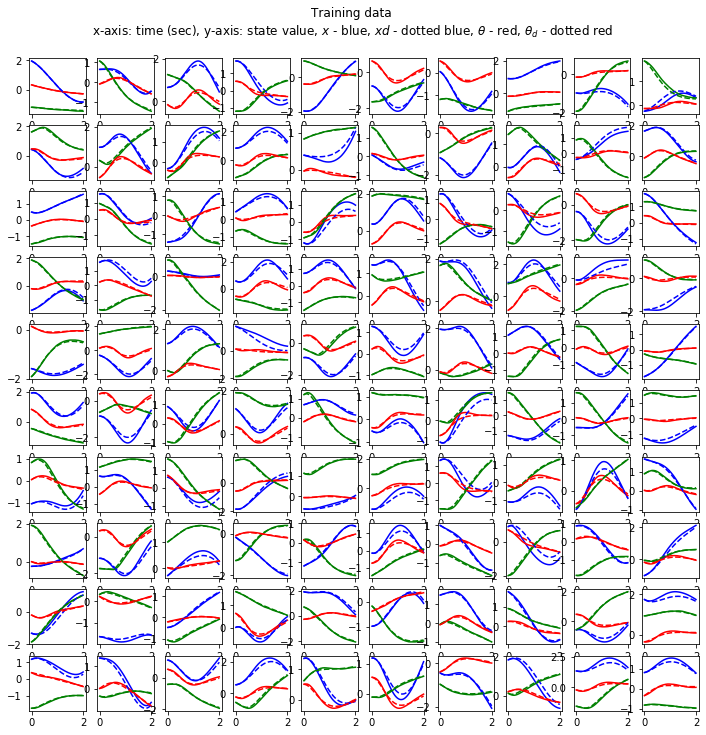

In [4]:
xd = np.empty((n_traj_dc, n_pred_dc + 1, n))
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd[ii, :, :] = mpc_trajgen.parse_result().T
    while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
    xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
    plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
    plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
    plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
    plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
    y=0.94)
plt.show()

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [5]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [6]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_dc, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [7]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [8]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_dc, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
model_edmd.reduce_mdl()
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis_reduced, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [9]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [10]:
n_lift_bedmd = n_lift_edmd
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: planar_quad_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    

/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1790: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12080469686479911, tolerance: 0.02342731354100924
  check_random_state(self.random_state), random)


### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [11]:
# Prediction performance evaluation parameters:
folder_plots = 'examples/figures/'                                  # Path to save plots
n_traj_ol = 100                                                     # Number of trajectories to execute, open loop

In [12]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_dmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_edmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

    xs_ol[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:]-hover_thrust, t_eval[:-1])

    xs_dmd_ol[ii,:,:], _ = sys_dmd.simulate(x0, ol_controller_nom, t_eval[:-1])

    z_0_edmd = sys_edmd.basis(np.atleast_2d(x0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ol_controller_nom, t_eval[:-1])
    xs_edmd_ol[ii,:,:] = np.dot(model_edmd.C, zs_edmd_tmp.T).T

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T

error_dmd = xs_ol[:,:-1,:] - xs_dmd_ol
error_dmd_mean = np.mean(error_dmd, axis=0).T
error_dmd_std = np.std(error_dmd, axis=0).T
mse_dmd = np.mean(np.square(error_dmd))
std_dmd = np.std(error_dmd)

error_edmd = xs_ol[:,:-1,:] - xs_edmd_ol
error_edmd_mean = np.mean(error_edmd, axis=0).T
error_edmd_std = np.std(error_edmd, axis=0).T
mse_edmd = np.mean(np.square(error_edmd))
std_edmd = np.std(error_edmd)

error_bedmd = xs_ol[:,:-1,:] - xs_bedmd_ol
error_bedmd_mean = np.mean(error_bedmd, axis=0).T
error_bedmd_std = np.std(error_bedmd, axis=0).T
mse_bedmd = np.mean(np.square(error_bedmd))
std_bedmd = np.std(error_bedmd)

print('\nOpen loop performance statistics:\n')
print(tabulate([['DMD', "{:.5f}".format(mse_dmd), '-', '-', "{:.5f}".format(std_dmd), '-', '-'],
               ['EDMD', "{:.5f}".format(mse_edmd), "{:.2f}".format((1 - mse_edmd / mse_dmd) * 100)+' %', '-', "{:.5f}".format(std_edmd), "{:.2f}".format((1 - std_edmd / std_dmd) * 100)+' %', '-'],
               ['bEDMD', "{:.5f}".format(mse_bedmd), "{:.2f}".format((1 - mse_bedmd / mse_dmd) * 100)+' %', "{:.2f}".format((1 - mse_bedmd / mse_edmd) * 100)+' %', "{:.5f}".format(std_bedmd), "{:.2f}".format((1 - std_bedmd / std_dmd) * 100)+' %', "{:.2f}".format((1 - std_bedmd / std_edmd) * 100)+' %']], 
               headers=['MSE', 'MSE improvement\nover DMD', 'MSE improvement\nover EDMD', 'Standard\ndeviation', 'std improvement\nover DMD', 'std improvement\nover EDMD']))

[-0.79485733 -1.9662892  -0.41690006  0.22898095 -0.01613055  0.82753317]
[-0.79236317 -1.96647612 -0.40861972  0.26972255 -0.02119566  0.8285349 ]
[-0.78952512 -1.96685086 -0.40036682  0.29779716 -0.05371507  0.82204344]
[-0.78614457 -1.96692002 -0.39225119  0.37805452  0.03999147  0.8010825 ]
[-0.78206103 -1.96627263 -0.38427654  0.43845711  0.08956791  0.79384893]
[-0.77737977 -1.96512818 -0.37645395  0.49760162  0.13939799  0.77066794]
[-0.77211526 -1.96348937 -0.3686671   0.55510872  0.18844     0.78670167]
[-0.76628308 -1.96136217 -0.3608174   0.61113496  0.23707337  0.78323845]
[-0.75986182 -1.95865404 -0.35288285  0.67289824  0.30463394  0.80367286]
[-0.75285359 -1.95533369 -0.3448735   0.7285441   0.35951118  0.798197  ]
[-0.745405   -1.9517711  -0.33692554  0.76105207  0.35304927  0.79139511]
[-0.73754465 -1.94801182 -0.32905221  0.81082904  0.3988715   0.78326964]
[-0.72910281 -1.94352839 -0.32123912  0.87728267  0.49790107  0.77934901]
[-0.72003203 -1.93813669 -0.31349792  

[ 1.52870698 -0.24643846  0.47890119 -0.46013209 -0.01345373  0.49327368]
[ 1.52385603 -0.24658464  0.48375945 -0.51013485 -0.01582146  0.47837869]
[ 1.51859461 -0.24692986  0.48859633 -0.5421991  -0.05324856  0.48899624]
[ 1.51298953 -0.24760979  0.4935357  -0.57887209 -0.08276856  0.49887704]
[ 1.50700528 -0.24856592  0.49844301 -0.61803783 -0.10849004  0.48258662]
[ 1.50034304 -0.24925939  0.50325704 -0.71455087 -0.0302813   0.48021793]
[ 1.49288704 -0.24949086  0.50807885 -0.77674016 -0.01606152  0.4841446 ]
[ 1.48483582 -0.24963421  0.51289931 -0.83358497 -0.01265395  0.47994801]
[ 1.47625024 -0.24980945  0.51762638 -0.88360047 -0.02243487  0.46546598]
[ 1.46717809 -0.25011108  0.52225288 -0.93089256 -0.03792686  0.45983269]
[ 1.45751624 -0.25036984  0.52697203 -1.00157495 -0.01388179  0.48399775]
[ 1.44724081 -0.25055451  0.53176789 -1.05358162 -0.02309378  0.47517456]
[ 1.43643405 -0.25081705  0.53649177 -1.10784337 -0.02945552  0.46960062]
[ 1.42500783 -0.25101933  0.5411495  -

[ 0.40749301 -0.61364149 -0.00889098 -1.86023111  2.19913374 -0.01043139]
[ 0.38889352 -0.59182456 -0.00900313 -1.85966556  2.16425264 -0.01199992]
[ 3.70301005e-01 -5.70214179e-01 -9.05877181e-03 -1.85883668e+00
  2.15782371e+00  8.72088968e-04]
[ 0.35171604 -0.54875124 -0.00907978 -1.85815646  2.13476488 -0.0050735 ]
[ 0.33313687 -0.52763094 -0.00914913 -1.85767691  2.08929506 -0.00879715]
[ 0.31456345 -0.5068641  -0.00927691 -1.85700596  2.06407208 -0.0167588 ]
[ 0.29599871 -0.48614273 -0.00938801 -1.8559388   2.08020246 -0.00546021]
[ 0.27744412 -0.46532198 -0.00954047 -1.85497656  2.08394659 -0.02503302]
[ 0.25889647 -0.4447529  -0.00974226 -1.85455175  2.02986929 -0.01532387]
[ 0.24035993 -0.42403    -0.00999254 -1.85274948  2.11471193 -0.03473277]
[ 0.2218371  -0.40291167 -0.01030645 -1.85181172  2.10895358 -0.02804818]
[ 0.20332365 -0.38186485 -0.01077835 -1.85087039  2.10041047 -0.06633348]
[ 0.18481777 -0.36109503 -0.01153777 -1.85029942  2.05355298 -0.08554883]
[ 0.16631767 

[ 1.72524829  0.49796495  0.29152333 -0.59467289 -2.10283637  0.18220883]
[ 1.71912028  0.4770489   0.29331984 -0.6309659  -2.08038422  0.17709291]
[ 1.71272352  0.45604233  0.29497655 -0.64840139 -2.12093315  0.15424921]
[ 1.70610003  0.43480071  0.29647516 -0.67631922 -2.12739931  0.14547336]
[ 1.69919186  0.41350999  0.29785316 -0.70533572 -2.13075025  0.13012698]
[ 1.69200339  0.39215146  0.29911039 -0.73237756 -2.14096122  0.12131854]
[ 1.6845565   0.37065007  0.30019298 -0.75701557 -2.159321    0.09519906]
[ 1.67687868  0.34891381  0.30103353 -0.77855844 -2.18793429  0.07291036]
[ 1.66890042  0.32716409  0.30159509 -0.81710501 -2.16201357  0.03940319]
[ 1.66063712e+00  3.05349873e-01  3.01786552e-01 -8.35555402e-01
 -2.20083080e+00 -1.11152187e-03]
[ 1.65216443  0.28322739  0.30162056 -0.85898076 -2.2236643  -0.03208608]
[ 1.64340949  0.26103125  0.30128388 -0.89200233 -2.21556206 -0.03525044]
[ 1.63432887  0.23890215  0.30087904 -0.9241133  -2.21025546 -0.04571864]
[ 1.62492607 

[ 1.33884778 -1.27287046  0.27820451 -0.75477817  0.06327162  0.09038335]
[ 1.33106617 -1.27191046  0.27908606 -0.80156843  0.12872122  0.08592575]
[ 1.32284553 -1.27039928  0.27989887 -0.84257898  0.1735085   0.07663579]
[ 1.31427277 -1.26864385  0.28054039 -0.87198361  0.17757367  0.05166881]
[ 1.30535158 -1.26666025  0.28104576 -0.91226652  0.21914352  0.049406  ]
[ 1.29600987 -1.26420094  0.28140581 -0.9560855   0.27271553  0.02260289]
[ 1.28620246 -1.26111159  0.28151035 -1.00539758  0.34515378 -0.00169442]
[ 1.27585548 -1.25713721  0.28133242 -1.06399414  0.4497238  -0.03389122]
[ 1.26508023 -1.252662    0.28067311 -1.09104466  0.4453221  -0.09797103]
[ 1.25395792 -1.24796338  0.27950828 -1.13338836  0.49440934 -0.13499561]
[ 1.24249915 -1.24307387  0.27794569 -1.15834369  0.48350024 -0.17752086]
[ 1.2306628  -1.23784088  0.27593708 -1.20886573  0.56311467 -0.22420123]
[ 1.21837513 -1.23199532  0.27356623 -1.24861355  0.60601254 -0.24996878]
[ 1.20561926 -1.22546123  0.27087782 -

[ 1.15385258  1.06784244  0.47810421  0.26520371 -0.80693803 -0.32910744]
[ 1.15619642  1.05987893  0.47478352  0.20362851 -0.78573062 -0.33502929]
[ 1.15801149  1.05196268  0.4713634   0.15943609 -0.79749254 -0.3489954 ]
[ 1.15923904  1.04421904  0.46781824  0.08615885 -0.75119332 -0.36003665]
[ 1.15982784  1.03675819  0.46405868  0.03166955 -0.74094316 -0.39187544]
[ 1.16005033  1.02904708  0.46021626  0.01285276 -0.80126586 -0.37660824]
[ 1.16002825  1.02084871  0.45646305 -0.0172317  -0.83838962 -0.37403297]
[ 1.15972099  1.01224999  0.45267327 -0.04418531 -0.88133725 -0.38392348]
[ 1.15900068  1.00352055  0.44871242 -0.09980048 -0.86451441 -0.40824599]
[ 1.15779826  0.99481097  0.44456603 -0.14062568 -0.87737189 -0.42103301]
[ 1.15613038  0.98609795  0.44026831 -0.19286974 -0.86519526 -0.43851136]
[ 1.15396711  0.97745538  0.43558984 -0.23970656 -0.86328341 -0.49718214]
[ 1.1515375   0.96840227  0.43057678 -0.24620377 -0.94733133 -0.50542969]
[ 1.14896262  0.95868525  0.4253552  -

[ 0.86794692 -1.91661377  0.22444572  0.1580913  -0.2482183  -0.43741909]
[ 0.86938219 -1.91894409  0.21992015  0.12905963 -0.21782502 -0.46769388]
[ 0.87057928 -1.92119144  0.21523159  0.11042396 -0.23163024 -0.47001875]
[ 0.87162062 -1.92370838  0.21049285  0.09789152 -0.27174818 -0.47772977]
[ 0.87248537 -1.92637785  0.20574831  0.07514361 -0.26212633 -0.47117735]
[ 0.8731004  -1.92883091  0.20118507  0.04796202 -0.22846617 -0.44147105]
[ 0.87337251 -1.93058091  0.19679652  0.0066101  -0.12150347 -0.43623921]
[ 0.87326314 -1.93139962  0.19244273 -0.02835609 -0.04221202 -0.43451946]
[ 0.87281738 -1.93147339  0.18811163 -0.06067363  0.02747995 -0.43170012]
[ 0.87207454 -1.93096849  0.18384264 -0.08779265  0.07352031 -0.42209675]
[ 0.87106348 -1.93000215  0.17965367 -0.11431918  0.11976616 -0.41569709]
[ 0.86970394 -1.92809436  0.17558499 -0.15742601  0.26182116 -0.39803935]
[ 0.86797024 -1.92506094  0.17155941 -0.18919191  0.3448841  -0.40707631]
[ 0.86596948 -1.92146928  0.16743415 -

[ 1.82391536 -0.04794077  0.42762855  0.93373093 -0.4633653   0.00829408]
[ 1.83292835 -0.05235343  0.42788299  0.86886194 -0.41916912  0.04259487]
[ 1.8413325  -0.05641206  0.42814895  0.81196232 -0.39255874  0.01059696]
[ 1.84923672 -0.06035622  0.42834771  0.76887825 -0.39627629  0.02915574]
[ 1.85658323 -0.06406012  0.42865422  0.7004174  -0.34450741  0.03214595]
[ 1.86336083 -0.06750002  0.42890504  0.65509765 -0.34347395  0.01801768]
[ 1.86968558 -0.07093066  0.42915855  0.60984881 -0.34265532  0.0326848 ]
[ 1.87548923 -0.07420359  0.42950815  0.55087344 -0.31193465  0.03723462]
[ 1.88078636 -0.07735159  0.42988991  0.50854561 -0.31766721  0.03911666]
[ 1.88557559 -0.08037286  0.43014752  0.44929599 -0.28659037  0.01240521]
[ 1.88990837 -0.08338018  0.43023998  0.41725956 -0.31487322  0.0060875 ]
[ 1.89379924 -0.0864055   0.43016878  0.36091485 -0.29018978 -0.02032741]
[ 1.89698937 -0.0888845   0.43000874  0.2771158  -0.20560951 -0.01168134]
[ 1.89958557 -0.09104959  0.42992457  

[ 0.39920956  0.06531707 -0.09559386 -1.9834472   0.22116645 -0.31337736]
[ 0.37939453  0.06723888 -0.09855049 -1.97953858  0.16319267 -0.27794903]
[ 0.35963184  0.06870788 -0.10128899 -1.97297027  0.1306051  -0.26975015]
[ 0.33996706  0.07015683 -0.10377706 -1.95993182  0.15917914 -0.22786414]
[ 0.32041263  0.07168601 -0.10592702 -1.95092416  0.14665478 -0.20212772]
[ 0.30095815  0.07317392 -0.10775695 -1.93994172  0.150924   -0.16385826]
[ 0.28161346  0.0746961  -0.1093613  -1.92896778  0.15350847 -0.15701156]
[ 0.26239546  0.07639038 -0.11088824 -1.91459961  0.18534381 -0.14837661]
[ 0.243287    0.07808895 -0.11221647 -1.90707866  0.154369   -0.11727086]
[ 0.2242558   0.0794921  -0.11358473 -1.89914528  0.12625929 -0.15638059]
[ 0.20533415  0.08087336 -0.11505218 -1.88515506  0.1499878  -0.13710884]
[ 0.18657378  0.08266867 -0.11635958 -1.86688469  0.20907146 -0.12437057]
[ 0.16796902  0.08481533 -0.11753877 -1.85404403  0.22025727 -0.11146898]
[ 0.14947277  0.08690037 -0.11864358 -

[ 5.07554705e-01  7.54761436e-02  1.83730833e-01 -1.03029953e+00
 -1.60337985e+00 -1.53728365e-03]
[ 0.49712413  0.05963844  0.18369607 -1.0558151  -1.56416052 -0.00541463]
[ 0.48644129  0.04417756  0.18359046 -1.08075061 -1.52801444 -0.01570789]
[ 0.47551667  0.02903784  0.18340961 -1.10416936 -1.49993033 -0.02046274]
[ 0.46433875  0.01428265  0.18325236 -1.13140984 -1.45110592 -0.01098598]
[ 4.52875564e-01  8.57812008e-05  1.83042979e-01 -1.16122222e+00
 -1.38826714e+00 -3.08909956e-02]
[ 0.44115524 -0.01370306  0.18268681 -1.18283552 -1.36949994 -0.0403427 ]
[ 0.4292208  -0.02731391  0.18224575 -1.20404331 -1.35266822 -0.04786961]
[ 0.41704599 -0.04060123  0.18169349 -1.23090539 -1.30479274 -0.0625832 ]
[ 0.40454546 -0.05309613  0.18101762 -1.26917819 -1.19418394 -0.0725889 ]
[ 0.39175465 -0.06498658  0.18016241 -1.28896859 -1.1839036  -0.09845477]
[ 0.37877362 -0.07681363  0.17911047 -1.30722007 -1.18150292 -0.11193236]
[ 0.36561723 -0.08865312  0.17788255 -1.32403883 -1.18639086 -

[-1.05202646 -1.32795588 -0.17800976  1.9915963   0.47588741  0.87406831]
[-1.03201038 -1.32312149 -0.16918631  2.01145488  0.49102082  0.89062146]
[-1.01179772 -1.31811703 -0.16031743  2.03090283  0.50989923  0.88315369]
[-0.99141959 -1.31307308 -0.15157071  2.04459734  0.49891107  0.86618999]
[-0.97092395 -1.30824287 -0.14288067  2.05443488  0.4671449   0.87181898]
[-0.95026046 -1.3032164  -0.13421106  2.07801789  0.53818246  0.86210163]
[-0.92939947 -1.29771335 -0.12560273  2.09400418  0.56245103  0.8595651 ]
[-0.90840873 -1.29216837 -0.11708099  2.10402757  0.54655824  0.84478313]
[-0.88734854 -1.28701983 -0.10874048  2.10796136  0.48315535  0.8233191 ]
[-0.86620757 -1.28210204 -0.10048548  2.12007455  0.5004191   0.82768078]
[-0.84495774 -1.27708757 -0.09211097  2.12975226  0.50248854  0.84722033]
[-0.82361972 -1.27210085 -0.08360066  2.13772244  0.4948673   0.85484263]
[-0.80219773 -1.2670895  -0.07503273  2.14651751  0.50741561  0.85874344]
[-0.78069386 -1.26197055 -0.06639296  

[ 1.40154531 -0.76773827  0.0560386   0.73280151 -0.31859571  0.18186687]
[ 1.40884436 -0.77090389  0.05777684  0.72697987 -0.31453066  0.1657828 ]
[ 1.41606995 -0.77378268  0.05947661  0.71809453 -0.26122839  0.17417045]
[ 1.42322716 -0.77649075  0.06121844  0.71332486 -0.28038756  0.17419564]
[ 1.43033029 -0.77929831  0.0629449   0.70727247 -0.28112616  0.17109641]
[ 1.43737836 -0.78221224  0.06445702  0.70232221 -0.30166078  0.13132649]
[ 1.44436531 -0.78516119  0.06570693  0.69504561 -0.28813024  0.11865661]
[ 1.45127474 -0.78791304  0.06681588  0.68681631 -0.26224178  0.10313305]
[ 1.45809738 -0.7903492   0.06785043  0.67768911 -0.22499279  0.10377802]
[ 1.46483871 -0.79256894  0.06888165  0.67055839 -0.218955    0.10246464]
[ 1.47150389 -0.79466635  0.06992934  0.66245825 -0.20052844  0.1070736 ]
[ 1.47809737 -0.79672032  0.07100979  0.65622135 -0.21026808  0.10901635]
[ 1.48462992 -0.79889841  0.07189851  0.6502764  -0.22534939  0.06872776]
[ 1.49110353 -0.80123888  0.0726052   

[-1.66430631  0.02098262 -0.24860075 -1.80184164  1.37679081 -0.29262064]
[-1.68219759  0.03475886 -0.25144578 -1.77636629  1.37844505 -0.27638503]
[-1.69980997  0.04863947 -0.25417053 -1.74605806  1.39766316 -0.26856613]
[-1.71716965  0.0625126  -0.25683919 -1.72584211  1.37695455 -0.26516553]
[-1.73432284  0.07619093 -0.25931463 -1.70476294  1.35870149 -0.2299224 ]
[-1.75127153  0.08965925 -0.26155697 -1.68494732  1.33495696 -0.21854551]
[-1.76800012  0.10296863 -0.26363241 -1.66073922  1.32690969 -0.19654345]
[-1.7844999   0.11614488 -0.26548854 -1.63919382  1.30833346 -0.17468181]
[-1.80075029  0.12925712 -0.26719601 -1.61085415  1.31410597 -0.16681207]
[-1.81675563  0.1422839  -0.26876923 -1.59019301  1.29124562 -0.14783282]
[-1.83246601  0.15540003 -0.27010758 -1.55185226  1.33197147 -0.11983591]
[-1.84784833  0.16872044 -0.2712322  -1.52459296  1.33210577 -0.10508755]
[-1.86298974  0.18192636 -0.2721018  -1.50367965  1.3090752  -0.06883397]
[-1.87794439  0.19482077 -0.27274534 -

[ 0.09439875  0.85394767 -0.41984663 -0.80892029  1.50136112  0.07776981]
[ 0.08636604  0.86859743 -0.41888935 -0.79762652  1.42859195  0.11368545]
[ 0.07862094  0.8829126  -0.4176459  -0.7514144   1.43445212  0.13500648]
[ 0.07130836  0.89722138 -0.41633393 -0.71112245  1.42731294  0.12738754]
[ 0.06453797  0.91177574 -0.41497777 -0.64298891  1.48357478  0.14384384]
[ 0.05830612  0.92657111 -0.41333645 -0.60340716  1.47551047  0.18441905]
[ 0.05236426  0.94104633 -0.41138777 -0.58497734  1.41953931  0.20531763]
[ 0.04668497  0.95514272 -0.40929045 -0.55090882  1.39974998  0.21414651]
[ 0.0413968   0.96916003 -0.40700259 -0.5067635   1.40372993  0.2434255 ]
[ 0.03655547  0.983233   -0.40445839 -0.46154826  1.41088291  0.26541415]
[ 0.03203869  0.99708249 -0.40163869 -0.44182958  1.35902488  0.29852697]
[ 0.02783152  1.0106807  -0.39867715 -0.39965351  1.36063785  0.2937799 ]
[ 0.02403256  1.02426694 -0.39562199 -0.36018613  1.35662872  0.31725192]
[ 0.02059146  1.03772881 -0.39242233 -

[ 2.21909895  0.05372048  0.45107927  0.02200492  1.2367605  -0.29659375]
[ 2.21926255  0.06571443  0.44807594  0.01072569  1.16203511 -0.30407253]
[ 2.21912804  0.07734855  0.44503487 -0.03757643  1.16481382 -0.30414141]
[ 2.21864848  0.08872439  0.44188305 -0.05831286  1.11036621 -0.3262231 ]
[ 2.21781406  0.09987025  0.43855179 -0.10851218  1.11883287 -0.34002835]
[ 2.21657182  0.11090406  0.43507531 -0.13989561  1.08794817 -0.35526799]
[ 2.21498806  0.12169191  0.4314737  -0.17680848  1.06964248 -0.3650527 ]
[ 2.21307664  0.13221016  0.42774691 -0.20543637  1.03402631 -0.38030544]
[ 2.21085843  0.14242056  0.4238693  -0.23816082  1.00807461 -0.39521732]
[ 2.20821014  0.15260395  0.41970978 -0.29141323  1.0286397  -0.43668574]
[ 2.20511166  0.1628146   0.4153866  -0.32822455  1.01351792 -0.42795196]
[ 2.20161073  0.17295706  0.41092959 -0.37188692  1.01500676 -0.46344971]
[ 2.19773623  0.18297531  0.40634386 -0.40295882  0.98866606 -0.45369541]
[ 2.19349124  0.19287414  0.40182821 -

[ 0.09474879  0.51040368  0.32135844  0.3554849   0.93016538 -0.11505054]
[ 0.09811896  0.51977034  0.32015982  0.31856994  0.94317434 -0.12467366]
[ 0.10110356  0.52931893  0.31894292  0.27837526  0.96655024 -0.11870755]
[ 0.10372423  0.53898844  0.31776597  0.24577843  0.96735973 -0.11668215]
[ 0.10600402  0.54871343  0.31658781  0.21020004  0.97764409 -0.11894989]
[ 0.10787087  0.55871813  0.31534169  0.16320046  1.0233056  -0.13027344]
[ 0.1094073   0.56875411  0.31384569  0.14410084  0.98389498 -0.16892577]
[ 0.1106752   0.57863694  0.31208923  0.10951058  0.99268207 -0.18236677]
[ 0.11167762  0.58836115  0.31031606  0.09098933  0.952165   -0.17226854]
[ 0.11249577  0.59767898  0.30834318  0.07266054  0.91140798 -0.22230572]
[ 0.11316553  0.60648151  0.30620233  0.06130316  0.84910092 -0.20586436]
[ 0.11356388  0.61516273  0.30407817  0.01841469  0.88715935 -0.21896743]
[ 0.11354548  0.62419094  0.30185086 -0.02204643  0.9184959  -0.22649569]
[ 0.11322605  0.63320409  0.29954258 -

[-1.81731637 -0.39772155 -0.3472556  -1.17799693  0.45305392 -0.17887297]
[-1.82888264 -0.39309214 -0.34903929 -1.13522177  0.4728141  -0.17786688]
[-1.84009678 -0.38847579 -0.35070601 -1.10758569  0.45044901 -0.15547554]
[-1.85098129 -0.38393959 -0.35226504 -1.06928942  0.45678047 -0.15633206]
[-1.86155012 -0.37952532 -0.35388167 -1.04445716  0.42606691 -0.16699213]
[-1.87186531 -0.37540555 -0.35559541 -1.01856146  0.39787983 -0.17575607]
[-1.88201276 -0.37181465 -0.3571838  -1.01092223  0.32029781 -0.14192193]
[-1.89194641 -0.3686324  -0.35854464 -0.97578807  0.31614507 -0.13024675]
[-1.90162408 -0.3657477  -0.35994491 -0.95973575  0.26079172 -0.14980651]
[-1.91099845 -0.36303859 -0.36120886 -0.91511349  0.28101982 -0.10298444]
[-1.91985242 -0.35993307 -0.36218419 -0.85565356  0.34007515 -0.09208076]
[-1.92830619 -0.35675185 -0.36312291 -0.83509187  0.29616586 -0.09566323]
[-1.93650481 -0.35388026 -0.36400258 -0.80462176  0.27814699 -0.08027208]
[-1.94442315 -0.35125387 -0.36469141 -

[ 0.18903431  0.76361411 -0.14966543 -1.12350306  1.81435729 -0.54782543]
[ 0.17782483  0.78143459 -0.15496188 -1.11836333  1.74973359 -0.51146395]
[ 0.16674867  0.7991218  -0.16010313 -1.09675154  1.78769015 -0.51678578]
[ 0.15586477  0.81702036 -0.16525958 -1.07994142  1.79200729 -0.5145059 ]
[ 0.14514109  0.83489934 -0.1702991  -1.06471859  1.78377599 -0.4933982 ]
[ 0.13454943  0.85256628 -0.17532868 -1.05356115  1.74960133 -0.51251763]
[ 0.12410651  0.87008995 -0.18034057 -1.03493585  1.75511753 -0.48985878]
[ 0.11383628  0.88758066 -0.18523422 -1.01903945  1.74301302 -0.48887256]
[ 0.10367605  0.90467986 -0.1901202  -1.0129798   1.67682057 -0.48832324]
[ 0.09367087  0.92159943 -0.1950261  -0.98795264  1.70707445 -0.49285587]
[ 0.08392518  0.93885141 -0.19998874 -0.96107307  1.74329818 -0.49967305]
[ 0.07441233  0.95627269 -0.20492026 -0.94141899  1.74094188 -0.48663059]
[ 0.06515438  0.97393736 -0.20967271 -0.91005252  1.79196633 -0.46385855]
[ 0.05616434  0.99188179 -0.21430887 -

[-0.83224283 -0.66933517 -0.12274936 -0.80258972  2.00552026 -1.31203924]
[-0.84022369 -0.64941805 -0.13580265 -0.79342872  1.97788278 -1.29861869]
[-0.8480562  -0.62940815 -0.14872462 -0.77276298  2.02405415 -1.28577588]
[-0.85573561 -0.60934537 -0.16152971 -0.76298421  1.98848126 -1.27524248]
[-0.86330705 -0.589602   -0.17424005 -0.75115637  1.96016717 -1.26682517]
[-0.87074546 -0.57008523 -0.18682499 -0.73635514  1.94315467 -1.25016372]
[-0.87800448 -0.55060352 -0.19924365 -0.71522559  1.95314384 -1.23356742]
[-0.885039   -0.53099155 -0.21145431 -0.69144576  1.96920167 -1.20856524]
[-0.89187633 -0.51143764 -0.22339924 -0.6758807   1.94154973 -1.18041983]
[-0.89849361 -0.49190085 -0.23516345 -0.64733619  1.96575235 -1.17242234]
[-0.90487711 -0.47236503 -0.24656166 -0.62922293  1.94137679 -1.1072195 ]
[-0.9110116  -0.45282461 -0.25751963 -0.59744978  1.96664991 -1.08437465]
[-0.91678627 -0.43290076 -0.26816366 -0.55721924  2.01804898 -1.04443109]
[-0.92220713 -0.41266736 -0.27842966 -

[ 0.5062209   1.30323348 -0.34256034  0.00638371  0.74048086  1.06847725]
[ 0.50641276  1.3105109  -0.33175775  0.03185883  0.71504946  1.09203986]
[ 0.50694101  1.3177868  -0.32076211  0.07356534  0.74020828  1.10708826]
[ 0.50792738  1.32546249 -0.3095685   0.12342328  0.79502097  1.13163386]
[ 0.50928459  1.33331177 -0.29812685  0.14787044  0.77488242  1.15669649]
[ 0.51093257  1.34112864 -0.28645348  0.18150668  0.7885575   1.17797798]
[ 0.51288194  1.3489864  -0.27460169  0.20818512  0.78304638  1.19237977]
[ 0.51514946  1.35699562 -0.26258991  0.24504971  0.81887148  1.20997733]
[ 0.51760661  1.36471902 -0.25042045  0.24637146  0.72581065  1.22391395]
[ 0.52016809  1.37187542 -0.2382527   0.26576734  0.70551039  1.20963668]
[ 0.52290646  1.37877822 -0.22610192  0.2817681   0.67508097  1.22051821]
[ 0.52579395  1.38534776 -0.21395639  0.29560579  0.63885593  1.20858726]
[ 0.52880247  1.39149201 -0.20192974  0.30599862  0.59001506  1.19674251]
[ 0.53200795  1.39762715 -0.18986678  

[-1.96169832  1.45758672  0.25876859  0.40662543 -0.1785579  -0.58757615]
[-1.95782804  1.45605691  0.2528851   0.36757636 -0.12736457 -0.58912197]
[-1.95426494  1.45473231  0.24694114  0.34513135 -0.13753414 -0.59966972]
[-1.95090528  1.45323312  0.24108011  0.32687169 -0.16228677 -0.57253645]
[-1.94774152  1.45155024  0.23514044  0.30596621 -0.17426829 -0.61539758]
[-1.94479914  1.44981112  0.22893648  0.28261069 -0.17353131 -0.62539478]
[-1.94206823  1.44799773  0.22266823  0.26365732 -0.18912577 -0.62825533]
[-1.93952792  1.4460453   0.21630667  0.24449663 -0.20134003 -0.64405666]
[-1.93717388  1.44395954  0.20970785  0.22640245 -0.21579301 -0.67570787]
[-1.93499828  1.4417312   0.20291517  0.20881361 -0.22985475 -0.68282723]
[-1.93296506  1.43921221  0.19599153  0.1978924  -0.2739315  -0.70190053]
[-1.93105926  1.43635538  0.18867832  0.18335803 -0.29741706 -0.76074196]
[-1.92929119  1.43323857  0.18094213  0.17034715 -0.32592741 -0.78649478]
[-1.92761851  1.42965968  0.17293822  

[-1.24153399 -0.16076433 -0.18378171 -0.94216894 -0.98387121  0.89456672]
[-1.25086243 -0.17058342 -0.17478538 -0.92367335 -0.97991989  0.90469923]
[-1.25997885 -0.18017959 -0.1657822  -0.89981772 -0.93927717  0.89593768]
[-1.2688544  -0.18931634 -0.15688922 -0.87551451 -0.88803849  0.88265807]
[-1.27752999 -0.19817456 -0.14809298 -0.85975353 -0.88358071  0.87659016]
[-1.28606625 -0.20708177 -0.13939938 -0.84761963 -0.89784383  0.86212882]
[-1.29443594 -0.21577543 -0.13076755 -0.82654161 -0.84085911  0.86423836]
[-1.30256481 -0.22361267 -0.12215317 -0.79953715 -0.72654982  0.8586379 ]
[-1.31050757 -0.23092985 -0.11370402 -0.78913938 -0.73687168  0.83119068]
[-1.31833548 -0.23821919 -0.10549293 -0.77659755 -0.72097834  0.81102803]
[-1.32599619 -0.24489925 -0.09752215 -0.75581611 -0.61500678  0.78312892]
[-1.33349348 -0.2509005  -0.08976958 -0.74380723 -0.58522668  0.76738494]
[-1.34082509 -0.25602572 -0.08212919 -0.72282516 -0.43979101  0.76069253]
[-1.34798421 -0.26004762 -0.07468197 -

[-0.70722139  0.52798498 -0.90827935 -0.93677391  0.0107702   0.65193207]
[-0.71629763  0.52783061 -0.9018202  -0.87852315 -0.04158138  0.63989786]
[-0.72469212  0.52723457 -0.89541066 -0.80044192 -0.07754378  0.64201029]
[-0.73195408  0.526566   -0.88897748 -0.65207726 -0.05601013  0.64462626]
[-0.73781632  0.52605227 -0.88244794 -0.52048956 -0.04659233  0.66128179]
[-0.7425199   0.52551009 -0.87568061 -0.4203194  -0.06173053  0.69218344]
[-0.74618031  0.5248571  -0.86866393 -0.31186863 -0.06874142  0.71115232]
[-0.7489394   0.52398486 -0.86146038 -0.24002251 -0.10562049  0.72955843]
[-0.75102988  0.52270535 -0.85405621 -0.17813913 -0.15020415  0.75127531]
[-0.75245755  0.5210226  -0.84628213 -0.10747568 -0.18625451  0.80353951]
[-0.75306139  0.51908865 -0.83797895 -0.01340973 -0.20040653  0.85709719]
[-0.75278248  0.51696796 -0.82923299  0.06908354 -0.22361111  0.89209495]
[-0.75146343  0.51482025 -0.82013913  0.1945512  -0.20574089  0.92667634]
[-0.74894189  0.51281306 -0.81057161  

[ 1.06945139  1.43165338  0.39309012 -0.31269059  0.95566078 -0.82965686]
[ 1.06609792  1.44127021  0.3846119  -0.35784788  0.9677683  -0.86598675]
[ 1.06229572  1.45101467  0.37607248 -0.40243204  0.9811883  -0.84189834]
[ 1.05818243  1.46056326  0.36754928 -0.4201622   0.92855396 -0.86274025]
[ 1.0537863   1.46986781  0.35896597 -0.45891836  0.93241217 -0.85392181]
[ 1.04899036  1.47925728  0.35034492 -0.50010978  0.94554149 -0.87028856]
[ 1.04384939  1.48860842  0.34159971 -0.52796982  0.92472769 -0.87875466]
[ 1.03838475  1.49789027  0.33278495 -0.56480542  0.93169633 -0.8841968 ]
[ 1.0325852   1.50715925  0.32394739 -0.59497349  0.92214375 -0.88331458]
[ 1.02638977  1.51662911  0.31513213 -0.64389508  0.97189878 -0.87973738]
[ 1.01976464  1.52643441  0.30638849 -0.68096197  0.9892158  -0.86899084]
[ 1.01287136  1.53610323  0.29776487 -0.69761891  0.9445718  -0.85573426]
[ 1.00581365  1.54532677  0.28942775 -0.71384827  0.90015923 -0.81168963]
[ 0.99852099  1.55436077  0.28130234 -

[0.19962824 1.56934122 0.26982751 1.44675999 0.86843384 0.12156118]
[0.21396631 1.57800274 0.27088976 1.42083557 0.86386579 0.09088734]
[0.22804427 1.58661985 0.27186167 1.39474212 0.85955007 0.10349598]
[0.24187201 1.5951536  0.27287073 1.37079223 0.84719611 0.09831596]
[0.25534363 1.60397836 0.27387927 1.32350352 0.91774915 0.10339172]
[0.26845225 1.61311476 0.27486993 1.29820505 0.90952534 0.09473974]
[0.28128263 1.62225666 0.27588438 1.26785257 0.91885109 0.10814998]
[0.29379574 1.63153814 0.27701966 1.23474772 0.9374378  0.11890763]
[0.30608173 1.64063796 0.27801347 1.22244377 0.8825243  0.07985312]
[0.31820652 1.64932153 0.27876371 1.20250406 0.85418766 0.07019432]
[0.33023907 1.6573467  0.27942412 1.20400639 0.75084542 0.06188792]
[0.34209517 1.66500529 0.27999618 1.16720264 0.78087032 0.05252507]
[0.353636   1.67277946 0.28051468 1.14095524 0.77396029 0.05117479]
[0.36495652 1.68033739 0.28100484 1.1231435  0.7376249  0.04685701]
[0.37606412 1.68765191 0.28147143 1.09836993 0.7

[-0.33077254  0.67196176  0.17881702 -1.12500445 -0.39870867 -0.16606612]
[-0.34212136  0.66803238  0.17721425 -1.14473097 -0.38716219 -0.15448751]
[-0.35372485  0.66454488  0.17567367 -1.17592097 -0.31032974 -0.15362867]
[-0.3655468   0.66130563  0.17409276 -1.1884509  -0.33751733 -0.16255273]
[-0.3775038   0.6578535   0.17232956 -1.20292463 -0.35290463 -0.19008767]
[-0.38963827  0.65444086  0.17026009 -1.22392713 -0.32961629 -0.22380549]
[-0.40194423  0.65104387  0.16801315 -1.23723687 -0.34977655 -0.22558349]
[-0.41436315  0.64733131  0.16583501 -1.24652757 -0.39273184 -0.21004363]
[-0.42693479  0.6435518   0.16362673 -1.26775358 -0.36316104 -0.23161347]
[-0.4397261   0.64012219  0.16121016 -1.29045212 -0.32275317 -0.25170054]
[-0.45271029  0.63689667  0.15864273 -1.30634284 -0.3223443  -0.26178437]
[-0.46588298  0.63386958  0.15596852 -1.32813501 -0.28306324 -0.27305734]
[-0.47922144  0.63091385  0.15309085 -1.33952166 -0.30807667 -0.30247702]
[-0.49271478  0.62798287  0.14994149 -

[-1.18901683 -0.80817883 -0.10132028 -1.23555878 -0.8109899  -1.70275238]
[-1.2013312  -0.81639541 -0.11827324 -1.227098   -0.83235002 -1.6878393 ]
[-1.21349504 -0.82434902 -0.13504051 -1.20519041 -0.75843325 -1.66561397]
[-1.22548572 -0.83199114 -0.15156682 -1.19270602 -0.77002523 -1.63964817]
[-1.23737019 -0.83991291 -0.16793603 -1.18404156 -0.81435183 -1.63419498]
[-1.2490993  -0.84791141 -0.18423234 -1.16143662 -0.78541124 -1.62506574]
[-1.26064159 -0.85588045 -0.20031221 -1.14681887 -0.80843549 -1.5909099 ]
[-1.2719737  -0.86380278 -0.21607818 -1.11926069 -0.7761019  -1.56228426]
[-1.28303714 -0.87148011 -0.23160029 -1.09313106 -0.75943307 -1.54213657]
[-1.29382281 -0.87896122 -0.24687916 -1.06369507 -0.73686221 -1.51363695]
[-1.30432431 -0.88629407 -0.26188013 -1.03634289 -0.72977626 -1.4865575 ]
[-1.31454273 -0.89355179 -0.27660288 -1.00708062 -0.72184098 -1.45799331]
[-1.32456317 -0.90108649 -0.29108344 -0.99692272 -0.78512242 -1.43811898]
[-1.33434609 -0.90881691 -0.3051759  -

[-0.09304453 -1.20966541  0.15017883  2.36430052  0.1484713   0.97373286]
[-0.069487   -1.20811853  0.15995021  2.34702692  0.16087735  0.9805446 ]
[-0.04608587 -1.2065804   0.1698074   2.33305964  0.14672517  0.99089299]
[-0.02283887 -1.20512559  0.17963925  2.31618544  0.14420993  0.97547637]
[ 2.19779618e-04 -1.20361595e+00  1.89339304e-01  2.29536337e+00
  1.57684213e-01  9.64534928e-01]
[ 0.02303705 -1.20183013  0.19887927  2.26786804  0.19943642  0.94345859]
[ 0.04566034 -1.20005584  0.20823563  2.25670689  0.1554039   0.92781242]
[ 0.06809613 -1.19838032  0.21744663  2.23026247  0.17966031  0.91438773]
[ 0.09030052 -1.19663593  0.22656907  2.21048243  0.16918639  0.91010083]
[ 0.11228222 -1.19490773  0.23555154  2.18569979  0.17641761  0.88639329]
[ 0.13402368 -1.19315878  0.24420509  2.16245528  0.17333865  0.8443166 ]
[ 0.15559128 -1.19169004  0.2526869   2.15100043  0.12039329  0.85204493]
[ 0.17696732 -1.1904638   0.26116613  2.12406372  0.12481537  0.84380172]
[ 0.19812922 

[ 1.43024031  0.06549574  0.02855332 -0.27294062  1.07724834  0.11681224]
[ 1.42749296  0.07639747  0.02972426 -0.27655331  1.10309746  0.11737572]
[ 1.42471558  0.08733156  0.03068844 -0.27893473  1.08372073  0.07545999]
[ 1.42190413  0.09839286  0.03136296 -0.28337216  1.12853752  0.05944463]
[ 1.41905801  0.1095802   0.03198953 -0.28585894  1.10893069  0.06586925]
[ 1.41619094  0.12044206  0.03273736 -0.28756138  1.06344053  0.0836971 ]
[ 1.41329756  0.13112392  0.03362626 -0.29113183  1.07293146  0.09408283]
[ 1.41037645  0.14165107  0.03465361 -0.29310048  1.03249784  0.11138699]
[ 1.40743511  0.15178026  0.03576068 -0.29517658  0.99333965  0.11002581]
[ 1.40445973  0.16187643  0.03689438 -0.29992433  1.02589497  0.11671589]
[ 1.40144135  0.17215783  0.03814113 -0.30377365  1.03038315  0.13263361]
[ 1.39838819  0.18237057  0.03952634 -0.30687654  1.01216521  0.14440749]
[ 1.39530572  0.1923442   0.04091809 -0.3096336   0.98255893  0.13394303]
[ 1.39218687  0.20222327  0.04223138 -

[ 0.76453507  0.31450744  0.06431769 -1.18952916 -1.35813219 -0.33045919]
[ 0.75261569  0.30081628  0.06087461 -1.19430294 -1.38009673 -0.35815665]
[ 0.74063678  0.28712543  0.05720757 -1.20140539 -1.35806893 -0.37525052]
[ 0.72858818  0.273671    0.05344073 -1.20823715 -1.3328142  -0.37811888]
[ 0.71648469  0.2602566   0.04964498 -1.21240841 -1.35006174 -0.38103087]
[ 0.70432681  0.2469634   0.04591542 -1.21908113 -1.30857406 -0.36488113]
[ 0.69211212  0.23392115  0.04225426 -1.22379266 -1.29987407 -0.36735064]
[ 0.67985834  0.22081821  0.03849952 -1.22691503 -1.32071144 -0.3835979 ]
[ 0.66756558  0.20775463  0.03467014 -1.23155624 -1.29200263 -0.38227684]
[ 0.65523806  0.19470198  0.03082712 -1.23390136 -1.31852596 -0.38632703]
[ 0.64288463  0.18151446  0.02685532 -1.23672029 -1.31897457 -0.40803257]
[ 0.63049839  0.16858059  0.02282185 -1.24042772 -1.26779767 -0.39866287]
[ 0.61808079  0.15603203  0.01874266 -1.24300671 -1.24191188 -0.41717469]
[ 0.60563627  0.14395604  0.01449496 -

[-0.52313388  0.79455256 -0.36556286  0.38782008 -0.10050798  0.2958257 ]
[-0.51897979  0.79377986 -0.36262585  0.44292567 -0.05400443  0.29157714]
[-0.51427838  0.79346877 -0.35969901  0.49728761 -0.008188    0.2937906 ]
[-0.50916551  0.79326979 -0.35660286  0.52524743 -0.0315937   0.32543772]
[-0.50382649  0.79269645 -0.35328514  0.54253079 -0.08306426  0.33810633]
[-0.49822053  0.79186691 -0.34987232  0.57860514 -0.08282203  0.34445796]
[-0.49229389  0.79093492 -0.34621124  0.60667585 -0.10356066  0.38775946]
[-0.48607254  0.78983908 -0.34231813  0.63753743 -0.11558626  0.39086266]
[-0.47955732  0.7885868  -0.33828798  0.66545323 -0.13485049  0.41516551]
[-0.47269068  0.78735342 -0.33404212  0.70779028 -0.11179555  0.43400702]
[-0.46549921  0.78607376 -0.32954559  0.7304539  -0.14411994  0.46530003]
[-0.45798628  0.7847545  -0.32482722  0.77203656 -0.11970047  0.47837366]
[-0.45010152  0.78355775 -0.31998057  0.80483509 -0.11962217  0.49095642]
[-0.44192657  0.78225524 -0.31486086  

[ 0.31874751 -0.52448352 -0.11466025 -1.38927043 -1.41199532 -0.44052593]
[ 0.30493847 -0.53837676 -0.11902995 -1.37243397 -1.36666687 -0.43341378]
[ 0.29130893 -0.55175082 -0.12334941 -1.3533607  -1.30815767 -0.43047885]
[ 0.27786471 -0.56461031 -0.12766805 -1.3353811  -1.26375426 -0.43324945]
[ 0.26457758 -0.57722471 -0.13197243 -1.32196998 -1.25913368 -0.42762638]
[ 0.251486   -0.58935184 -0.13625229 -1.29621055 -1.16631228 -0.4283459 ]
[ 0.2386416  -0.60065594 -0.14049333 -1.2725503  -1.0945246  -0.4198614 ]
[ 0.22595125 -0.61184552 -0.14454386 -1.26548518 -1.14339605 -0.39024507]
[ 0.21339355 -0.62310864 -0.14849873 -1.24596805 -1.10923925 -0.40072845]
[ 0.20104511 -0.63395462 -0.15243333 -1.22362359 -1.05997199 -0.38619164]
[ 0.18884559 -0.64480785 -0.15631722 -1.21624888 -1.11067963 -0.39058531]
[ 0.17679733 -0.6556865  -0.16026044 -1.19330936 -1.06506437 -0.39805933]
[ 0.1649609  -0.66623465 -0.16429747 -1.17389597 -1.04457957 -0.40934751]
[ 0.15328936 -0.67676766 -0.16827913 -

[-2.2557454   0.13387823 -0.406004   -0.17690555  0.14799466  0.01057605]
[-2.2572935   0.1353818  -0.40555269 -0.13272147  0.15272259  0.07968488]
[-2.25846155  0.13678955 -0.40454078 -0.10090054  0.12883232  0.12269639]
[-2.25931578  0.13794928 -0.40317741 -0.06996323  0.10312122  0.14997833]
[-2.2597009   0.13922844 -0.40148867 -0.00710176  0.15272785  0.18777042]
[-2.25946916  0.14097955 -0.39967484  0.05340579  0.19751411  0.1749942 ]
[-2.25874431  0.14291664 -0.39778043  0.0915362   0.18991581  0.20388796]
[-2.25773013  0.14456096 -0.39558829  0.11128342  0.13895416  0.23454124]
[-2.25635971  0.14607821 -0.39311545  0.16274931  0.16451787  0.26002707]
[-2.25449593  0.14780411 -0.39033605  0.20995385  0.18068452  0.29585127]
[-2.25219528  0.14961067 -0.38709641  0.2501222   0.18064947  0.35207755]
[-2.24957617  0.15121683 -0.3834565   0.2736643   0.14059682  0.37590373]
[-2.24671555  0.15244076 -0.37956195  0.29842088  0.10420469  0.40300686]
[-2.24348507  0.15361209 -0.37556628  

[ 0.02338209  0.17683393 -0.32133672 -0.73051929 -0.93333961  0.87697176]
[ 0.01621454  0.1674276  -0.31247654 -0.70311517 -0.94788451  0.89506367]
[ 0.00935266  0.1579876  -0.30355214 -0.66941892 -0.94006631  0.88981717]
[ 0.00288841  0.14883822 -0.29467717 -0.62365064 -0.88974256  0.88517659]
[-0.00325279  0.13976769 -0.28583332 -0.60468174 -0.92433543  0.88359363]
[-0.00915541  0.13052992 -0.27691666 -0.57598976 -0.92317519  0.89973739]
[-0.01467587  0.1216598  -0.26792736 -0.52835844 -0.85077726  0.8981239 ]
[-0.01992421  0.11279145 -0.25886666 -0.52134828 -0.92288256  0.91401502]
[-0.0250173   0.10353246 -0.24962891 -0.49741148 -0.92887861  0.93353537]
[-0.02980501  0.09449397 -0.24024483 -0.4603626  -0.87876188  0.94328073]
[-0.03429333  0.08569304 -0.23068384 -0.43745448 -0.88138642  0.96891767]
[-0.03859803  0.07669044 -0.22099646 -0.42358269 -0.91911115  0.96855768]
[-0.04268838  0.0676663  -0.21129063 -0.39469959 -0.88567149  0.97260744]
[-0.04654435  0.05875029 -0.20154324 -

[-1.02788521 -0.20757631 -0.51097953  1.08375109  0.18192234 -0.5159183 ]
[ 0.07959599 -1.09067808  0.11667964  0.15101446 -0.91854501 -0.03599132]
[ 0.0810527  -1.09989764  0.11631912  0.14033211 -0.92536581 -0.03611283]
[ 8.23856866e-02 -1.10903939e+00  1.16136575e-01  1.26269035e-01
 -9.02984232e-01 -3.95668067e-04]
[ 0.08356618 -1.11785511  0.11607877  0.10983141 -0.86015975 -0.01116494]
[ 0.08457675 -1.12619433  0.11588245  0.09228659 -0.80768335 -0.02809934]
[ 0.08539817 -1.13388943  0.11555033  0.07200798 -0.73133516 -0.0383255 ]
[ 0.08603374 -1.14096419  0.11501526  0.05511896 -0.68361622 -0.06868728]
[ 0.08651454 -1.14768033  0.11432294  0.0410554  -0.6596105  -0.06977779]
[ 0.08683224 -1.15395653  0.11358741  0.02250357 -0.59562549 -0.07732813]
[ 0.08695144 -1.15947343  0.11282394  0.00136019 -0.50775173 -0.07536539]
[ 0.08685848 -1.16409877  0.11203815 -0.01992813 -0.41731363 -0.08179256]
[ 0.0865862  -1.16811204  0.11122913 -0.03450928 -0.38533887 -0.08001058]
[ 0.08611722 

[-0.2720319  -0.16024822 -0.0550031  -0.23312894  0.89295228  0.02164296]
[-0.27435574 -0.15167354 -0.05468222 -0.23163899  0.82198407  0.04253408]
[-0.27664085 -0.14337142 -0.05434484 -0.22538966  0.83843942  0.02494265]
[-0.27886484 -0.13492695 -0.05407204 -0.2194141   0.85045652  0.02961599]
[-0.28104379 -0.12663164 -0.05378102 -0.21637797  0.80860408  0.02858808]
[-0.28319924 -0.11888127 -0.0536077  -0.21471424  0.7414703   0.00607561]
[-0.28532176 -0.11149805 -0.053589   -0.20978963  0.73517419 -0.00233391]
[-2.87389618e-01 -1.04076856e-01 -5.36034601e-02 -2.03781454e-01
  7.49064542e-01 -5.59005910e-04]
[-0.28940201 -0.09660281 -0.05351363 -0.19869879  0.74574485  0.01852404]
[-0.2913617  -0.08912552 -0.05322945 -0.19324433  0.74971406  0.0383133 ]
[-0.29326272 -0.08152757 -0.05283743 -0.18696646  0.76987541  0.04009078]
[-0.29512636 -0.07420512 -0.05245564 -0.18576304  0.69461411  0.03626715]
[-0.29695801 -0.06725353 -0.0520915  -0.18057326  0.69570437  0.03656071]
[-0.29873831 

[-1.26335227 -0.06508205 -0.08958932  1.52028323 -0.07797454  0.69624997]
[-1.24810118 -0.06580073 -0.08268038  1.52980853 -0.0657507   0.68553775]
[-1.23277388 -0.06658618 -0.07591492  1.53556994 -0.09133383  0.66755553]
[-1.21740348 -0.06779094 -0.06931838  1.53846606 -0.14961435  0.65175132]
[-1.20199113 -0.06936591 -0.06283328  1.5439142  -0.16537479  0.64526886]
[-1.18653647 -0.07125487 -0.05649969  1.5469635  -0.21241268  0.62145018]
[-1.17103753 -0.07333121 -0.05011109  1.5527111  -0.20284953  0.65626906]
[-1.15547541 -0.07512006 -0.04342965  1.55954912 -0.15491409  0.68001944]
[-1.13986764 -0.07686144 -0.0366841   1.56193946 -0.19335883  0.66909066]
[-1.1242388  -0.07901181 -0.03011818  1.56376757 -0.23671306  0.64409252]
[-1.10858544 -0.08130856 -0.02364639  1.56678451 -0.22263375  0.65026671]
[-1.09290304 -0.08334871 -0.01722575  1.56954889 -0.18539193  0.6338602 ]
[-1.07719706 -0.0849986  -0.01088435  1.57150144 -0.14458449  0.63441993]
[-1.0614782  -0.08649605 -0.00448557  

[-1.97437132  0.21747469 -0.48995574  1.2598712  -1.20906144  0.7986951 ]
[-1.96146377  0.20547642 -0.48182243  1.32148136 -1.19050877  0.82796793]
[-1.94799479  0.1935702  -0.47333471  1.3721762  -1.19066304  0.86957668]
[-1.93397329  0.1817625  -0.46463303  1.43195192 -1.17078996  0.87075871]
[-1.91939482  0.1700845  -0.45588485  1.48359007 -1.16473453  0.87887676]
[-1.90428926  0.15850076 -0.44694366  1.53735794 -1.15193451  0.90936209]
[-1.88857929  0.14719829 -0.43769709  1.60441691 -1.10845519  0.93995086]
[-1.87223884  0.13626162 -0.42810789  1.66346911 -1.07878555  0.97788897]
[-1.85542332  0.12538298 -0.41823121  1.69950234 -1.09688268  0.99744743]
[-1.8380529   0.11477596 -0.40815387  1.77429648 -1.02439605  1.01802008]
[-1.82007886  0.10458092 -0.39777124  1.82032494 -1.01453156  1.05850682]
[-1.80170549  0.09435408 -0.38690732  1.8542008  -1.03077545  1.11427658]
[-1.78297582  0.08402137 -0.37565051  1.89155844 -1.03569533  1.13708653]
[-1.76384665  0.0737216  -0.36417754  

[-0.51535943  0.5898714   0.14863032  1.33183091 -0.84695303  0.66064285]
[-0.50215165  0.58163859  0.15524251  1.30956499 -0.79963389  0.66179367]
[-0.4891064   0.57346921  0.16176088  1.2994168  -0.83425201  0.64188071]
[-0.47622671  0.5653285   0.16806514  1.27637475 -0.79391477  0.61897252]
[-0.46356995  0.5575216   0.17429529  1.25484836 -0.76748771  0.62705682]
[-0.45113248  0.54997909  0.18055175  1.23251498 -0.74103692  0.62423574]
[-0.43889694  0.5425634   0.18677412  1.21449333 -0.742121    0.62023673]
[-0.42690178  0.53543544  0.19284933  1.1843801  -0.68350091  0.59480557]
[-0.41521651  0.5289134   0.19866787  1.15251723 -0.62093743  0.56890261]
[-0.40378892  0.52269356  0.20426824  1.1329113  -0.62304955  0.55117128]
[-0.39255651  0.51643512  0.20963849  1.11348921 -0.6286564   0.52287891]
[-0.38153664  0.51019417  0.21468503  1.09039373 -0.6195526   0.48642878]
[-0.37071322  0.50387458  0.21948258  1.0742316  -0.64437857  0.47308212]
[-0.3600438   0.49726467  0.22419946  

[-1.65558827 -0.08245294 -0.41020086 -1.16124611  2.01700028 -0.09640176]
[-1.66689431 -0.06206942 -0.41112497 -1.09994101  2.05969318 -0.08842063]
[-1.67769349 -0.04150407 -0.41199635 -1.05988031  2.05337226 -0.08585475]
[-1.68817253 -0.02118697 -0.41262689 -1.03592136  2.01004464 -0.0402539 ]
[-1.69835230e+00 -1.16725180e-03 -4.12921593e-01 -1.00002979e+00
  1.99389730e+00 -1.86864597e-02]
[-1.70818759  0.01865779 -0.41309589 -0.96702644  1.97111037 -0.01617386]
[-1.71758758  0.03849492 -0.41329849 -0.91296678  1.99631333 -0.02434433]
[-1.72673141  0.05793526 -0.4134533  -0.91580006  1.8917545  -0.00661758]
[-1.73565028  0.07690733 -0.41344267 -0.86797348  1.90266046  0.00874174]
[-1.74419546  0.09575017 -0.4132898  -0.8410634   1.86590767  0.02183316]
[-1.75226864  0.11468839 -0.4130002  -0.77358126  1.92173955  0.03608771]
[-1.75989749  0.13365947 -0.41261466 -0.7521915   1.87247708  0.04101858]
[-1.76712861  0.1525583  -0.41219302 -0.69404071  1.90729486  0.04331093]
[-1.77383483 

[ 0.90032526  1.58236289  0.33003755  0.07378129 -0.05814358 -0.1696937 ]
[ 0.90087611  1.58183778  0.32818266  0.03642296 -0.04686808 -0.20128387]
[ 0.90110768  1.58126906  0.32609622  0.00991923 -0.06686559 -0.2160044 ]
[ 0.90114823  1.58028376  0.32383184 -0.00179725 -0.13019105 -0.23687105]
[ 0.90099982  1.57888096  0.3214918  -0.02785337 -0.15035823 -0.23113773]
[ 0.90058477  1.57729785  0.31911235 -0.05512407 -0.16625252 -0.24475079]
[ 0.89978407  1.57590196  0.31654892 -0.10495131 -0.11290423 -0.26793649]
[ 0.89852367  1.57492821  0.31381615 -0.14707093 -0.08182719 -0.27861803]
[ 0.89691935  1.57403247  0.31087522 -0.17375242 -0.09730771 -0.30956783]
[ 0.89494483  1.57330918  0.30765901 -0.22107113 -0.04732468 -0.33367277]
[ 0.89249791  1.57309173  0.3042376  -0.26822775  0.00386119 -0.35061085]
[ 0.88963034  1.57323241  0.30072196 -0.30521743  0.02429612 -0.35251577]
[ 0.8865105   1.57320398  0.29719272 -0.31872555 -0.02997408 -0.35333283]
[ 0.88328304  1.57254556  0.29361277 -

[-1.05678008  0.80038644 -0.09448002  1.79372114 -0.27868559  0.88138809]
[-1.03879439  0.79763721 -0.08561204  1.80326019 -0.27114738  0.89220804]
[-1.02071567  0.79499201 -0.07666133  1.81231665 -0.2578793   0.89793503]
[-1.00255585  0.79241945 -0.06761514  1.81949782 -0.25662009  0.91130182]
[-0.98432251  0.78995611 -0.0584195   1.82698846 -0.23603697  0.92782676]
[-0.96602417  0.78761901 -0.04918864  1.83252201 -0.2313749   0.91834498]
[-0.9476849   0.78511903 -0.04000807  1.83523797 -0.26861642  0.91776927]
[-0.9293224   0.78221626 -0.03086015  1.83717966 -0.31193435  0.91181426]
[-0.91093477  0.77917554 -0.0217192   1.84017329 -0.2962063   0.91637576]
[-0.89252361  0.77622691 -0.01274952  1.84190723 -0.29351726  0.87755997]
[-0.87409786  0.77348157 -0.00393709  1.84304336 -0.25554789  0.88492636]
[-0.8556671   0.77077059  0.00506343  1.84300732 -0.28664929  0.91517714]
[-0.83723832  0.76757282  0.01422239  1.84270027 -0.35290418  0.91661642]
[-0.81882382  0.76427715  0.02332884  

[ 0.99200322  1.26645065  0.32059338 -1.84631829  0.14637838 -1.16977902]
[ 0.97332139  1.26809117  0.3087368  -1.88978495  0.18181312 -1.20153865]
[ 0.95426402  1.26992596  0.29673556 -1.92148542  0.18520847 -1.19870886]
[ 0.93483509  1.27199778  0.28482602 -1.96401813  0.22923987 -1.18319781]
[ 0.91513721  1.27399967  0.27306004 -1.9754798   0.17115987 -1.16999998]
[ 0.89524323  1.27572532  0.26135018 -2.00311902  0.17402387 -1.17197076]
[ 0.87515739  1.27718264  0.24960987 -2.01396818  0.11746113 -1.17609143]
[ 0.85491988  1.27825687  0.23786513 -2.03338057  0.09742319 -1.17285608]
[ 0.83440046  1.27951939  0.2262317  -2.07020113  0.15515213 -1.15383145]
[ 0.81355941  1.28119532  0.21461838 -2.09777054  0.18008653 -1.16883254]
[ 0.79248642  1.28295119  0.20290856 -2.11665468  0.17112412 -1.17313095]
[ 0.771214    1.28469684  0.19132693 -2.1376264   0.17804804 -1.1431946 ]
[ 0.74970408  1.28669116  0.17996583 -2.16409037  0.22086623 -1.12902592]
[ 0.72795506  1.28901656  0.16868649 -

[ 0.71111981  0.49382993  0.43599225  1.1597701   0.38738093 -0.17130381]
[ 0.7224529   0.49778211  0.43398866  1.10688706  0.40307302 -0.229413  ]
[ 0.73333854  0.50171853  0.43151577  1.07027312  0.38422526 -0.26516518]
[ 0.74368876  0.50583771  0.4286602   0.99984327  0.43964456 -0.30594942]
[ 0.75335099  0.51048138  0.42537141  0.93268411  0.48912759 -0.35180918]
[ 0.76243943  0.51541009  0.42163164  0.8850699   0.49664369 -0.39614454]
[ 0.77108191  0.52035195  0.41747707  0.84349017  0.49175574 -0.43476932]
[ 0.77934111  0.52517672  0.41291446  0.8084109   0.47322488 -0.47775352]
[ 0.78716875  0.53000645  0.40806766  0.75721139  0.492763   -0.49160491]
[ 0.79458432  0.53480733  0.40296747  0.72596511  0.46743901 -0.5284337 ]
[ 0.8017483   0.53921676  0.39744711  0.70687291  0.41446527 -0.57563822]
[ 0.80856421  0.54347646  0.39157469  0.65642706  0.43752433 -0.59884524]
[ 0.81487884  0.54796922  0.38568533  0.60661858  0.46107604 -0.57902761]
[ 0.82070442  0.55268541  0.37980016  

[-0.86993694 -1.09223576 -0.26443525  0.57763616 -0.72693797  0.42398178]
[-0.86410845 -1.09980206 -0.26029258  0.58803475 -0.78631484  0.40455357]
[-0.85809689 -1.10766033 -0.25617464  0.61420949 -0.78532214  0.41903494]
[-0.85173458 -1.11515847 -0.25190475  0.65813106 -0.71427416  0.43494257]
[-0.84495484 -1.12201613 -0.24764168  0.69770641 -0.65722845  0.41767   ]
[-0.83788242 -1.12869953 -0.24343158  0.71672446 -0.67943803  0.42435092]
[-0.83069689 -1.13591034 -0.2392536   0.720371   -0.76272245  0.41124578]
[-0.82332129 -1.14331908 -0.23500352  0.75464935 -0.71900041  0.43876966]
[-0.81562069 -1.15035169 -0.23052778  0.78537493 -0.68749929  0.45637738]
[-0.80759567 -1.15698238 -0.22589533  0.81951564 -0.63861194  0.4701132 ]
[-0.79927518 -1.1633097  -0.22119277  0.84449577 -0.62683378  0.47039925]
[-0.79077483 -1.16982041 -0.2164369   0.85553366 -0.67529947  0.48077442]
[-0.78208156 -1.17643172 -0.21159527  0.88301962 -0.64694033  0.48755226]
[-0.77315186 -1.18292469 -0.20664889  

[-0.96619723 -1.69078169  0.0778773   0.40324655 -0.99184252  0.25067612]
[-0.96220689 -1.70065645  0.08022021  0.3947812  -0.98311249  0.21790495]
[-0.95828085 -1.71070964  0.08232577  0.39040778 -1.02752761  0.20320689]
[-0.95442404 -1.72090695  0.08413339  0.38091913 -1.01193664  0.15831691]
[-0.95067644 -1.730791    0.08569967  0.36856257 -0.96487715  0.15493961]
[-0.94705488 -1.74018905  0.08722505  0.35571267 -0.91473621  0.15013662]
[-0.94357314 -1.74896985  0.0887935   0.34059    -0.84142771  0.16355345]
[-0.94022694 -1.75720819  0.09041349  0.32861478 -0.80624267  0.16044419]
[-0.93702231 -1.76486715  0.09194211  0.3122656  -0.72555379  0.14527969]
[-0.93395309 -1.77203664  0.09335466  0.30155116 -0.70834697  0.13722989]
[-0.93100884 -1.77885333  0.09478325  0.2872634  -0.65499406  0.14848762]
[-0.92820515 -1.78517226  0.09623937  0.27343838 -0.60879433  0.142738  ]
[-0.92556282 -1.7908018   0.0976155   0.25498453 -0.51711941  0.13248754]
[-0.92312018 -1.79537371  0.09895211  

[ 0.24192056  1.08507816 -0.04502232  1.98956436  1.47482091  0.37505666]
[ 0.26184417  1.09997422 -0.04132586  1.99507883  1.50439481  0.36423647]
[ 0.28182272  1.11521939 -0.03768862  2.00054732  1.54464302  0.36321053]
[ 0.30183657  1.1304046  -0.03412804  2.00219409  1.492399    0.34890613]
[ 0.32186998  1.14518607 -0.03064521  2.00444884  1.46389667  0.34765969]
[ 0.34193021  1.15986814 -0.02719349  2.00753563  1.47252002  0.34268359]
[ 0.3620124   1.17436494 -0.02386629  2.00887332  1.42683977  0.32275733]
[ 0.38211219  1.18862825 -0.0204977   2.01102948  1.42582435  0.35096064]
[ 0.40223309  1.20294421 -0.01705036  2.01308705  1.43736854  0.33850602]
[ 0.4223697   1.21718832 -0.01360833  2.01419437  1.41145327  0.34990018]
[ 0.4425167   1.23121802 -0.01016951  2.01515822  1.39448903  0.33786474]
[ 0.46267212  1.2450972  -0.00683502  2.01587994  1.38134708  0.32903357]
[ 0.48283269  1.25872743 -0.00361311  2.01620027  1.3446981   0.31534693]
[ 5.02995518e-01  1.27200843e+00 -3.60

[ 1.63733086 -1.69236542  0.23119851 -0.5386796  -0.19199784 -0.28013677]
[ 1.63177092 -1.69403726  0.22834092 -0.57323823 -0.14235479 -0.29138188]
[ 1.62594724 -1.6955567   0.22534634 -0.5914579  -0.16152387 -0.30753401]
[ 1.61999698 -1.697506    0.22211615 -0.59857879 -0.22833257 -0.33850347]
[ 1.61397031 -1.70009784  0.21850882 -0.60673232 -0.29003065 -0.38296348]
[ 1.60779608 -1.70300424  0.21460165 -0.62805103 -0.29123567 -0.39847046]
[ 1.60145442 -1.70612472  0.21054322 -0.64024277 -0.33285219 -0.4132155 ]
[ 1.59494581 -1.70944355  0.20638927 -0.66140865 -0.33089761 -0.41757487]
[ 1.58818718 -1.71254776  0.20215652 -0.69022052 -0.28992558 -0.42897399]
[ 1.58110761 -1.71506583  0.19788462 -0.72556891 -0.21366226 -0.4254061 ]
[ 1.57373209 -1.71709087  0.19355344 -0.74944726 -0.19132898 -0.44083026]
[ 1.56610246 -1.71879969  0.18915156 -0.77637736 -0.15041456 -0.43954534]
[ 1.55818919 -1.72000712  0.18464109 -0.80615784 -0.09104848 -0.46254974]
[ 1.5500648  -1.72106882  0.17987945 -

[ 0.88970113  1.33252537  0.30567792 -0.56375163 -1.19840062 -0.18299345]
[ 0.883875    1.32064987  0.30373418 -0.60143526 -1.17668786 -0.20575545]
[ 0.87774766  1.30875386  0.30151893 -0.62400539 -1.20250453 -0.23729437]
[ 0.87135683  1.29672451  0.29903428 -0.65412009 -1.20335361 -0.25963582]
[ 0.86469892  1.28458029  0.29621548 -0.67742727 -1.22547908 -0.30412316]
[ 0.85774792  1.27241621  0.29311027 -0.71271326 -1.20731924 -0.31692053]
[ 0.85042521  1.26050305  0.28986582 -0.75175806 -1.17529061 -0.33196905]
[ 0.84278117  1.24868536  0.28641239 -0.77699959 -1.18823355 -0.35871559]
[ 0.83488955  1.23672735  0.28283334 -0.8012764  -1.20335428 -0.357095  ]
[ 0.82664793  1.22499431  0.27917486 -0.84694999 -1.14322668 -0.37460097]
[ 0.81803905  1.21356005  0.27550095 -0.87476683 -1.14360763 -0.36018187]
[ 0.8092528   1.20177057  0.27181814 -0.88246544 -1.21428276 -0.37637893]
[ 0.80026831  1.18971353  0.26802426 -0.91436021 -1.19710548 -0.38239698]
[ 0.79096481  1.17783717  0.26405217 -

[-0.51538375  0.49673298 -0.24292888 -0.6855123  -0.46685102 -0.07246497]
[-0.52206855  0.49226049 -0.24372687 -0.65142971 -0.42765065 -0.08713158]
[-0.52843214  0.48809875 -0.24471145 -0.62126805 -0.40470363 -0.10978466]
[-0.5345373   0.48399109 -0.24582396 -0.59974895 -0.41683195 -0.11271771]
[-0.54031186  0.48021946 -0.2468466  -0.55513236 -0.3375021  -0.09180981]
[-0.54574631  0.47681718 -0.2477599  -0.53174212 -0.34295727 -0.09085115]
[-0.55096214  0.47329826 -0.24845735 -0.51141498 -0.3608288  -0.04863819]
[-0.55590391  0.46987849 -0.24888777 -0.4769297  -0.323127   -0.03744666]
[-0.56051977  0.46676015 -0.24913474 -0.44623817 -0.30054224 -0.01194652]
[-0.56481475  0.46392213 -0.24921109 -0.41275513 -0.2670621  -0.0033239 ]
[-0.5688229   0.46123012 -0.24926556 -0.38887483 -0.27133983 -0.00757072]
[-0.57258921  0.45850716 -0.24938649 -0.36438438 -0.27325403 -0.01661389]
[-0.57611107  0.45576302 -0.24939131 -0.33998696 -0.27557259  0.01565003]
[-0.57932546  0.45324523 -0.24916244 -

[ 1.88537312 -0.04429518  0.10289946  0.38602567 -0.07430433 -0.00782474]
[ 1.88919606 -0.04516724  0.10283162  0.37856257 -0.10010722 -0.00574271]
[ 1.89293377e+00 -4.61944576e-02  1.02806320e-01  3.68980356e-01
 -1.05335985e-01  6.82172291e-04]
[ 1.89656580e+00 -4.71783139e-02  1.02812628e-01  3.57424872e-01
 -9.14352866e-02  5.79522372e-04]
[ 1.90006793 -0.04788427  0.10284804  0.34300117 -0.04975629  0.00650333]
[ 1.90344347 -0.04834473  0.10293362  0.33210586 -0.04233479  0.01061275]
[ 1.90674554 -0.04907474  0.10294891  0.32830701 -0.10366757 -0.00755528]
[ 1.9099618  -0.04995506  0.10289012  0.31494547 -0.07239761 -0.00420333]
[ 1.91307739 -0.05084166  0.10297422  0.3081731  -0.10492212  0.02102335]
[ 1.91607885 -0.05160492  0.1029998   0.29211835 -0.04772938 -0.01590711]
[ 1.91893181 -0.05191221  0.10274862  0.27847833 -0.01372796 -0.03432804]
[ 1.92170026 -0.05238141  0.10241523  0.27521353 -0.08011293 -0.03234964]
[ 1.92436607 -0.0528323   0.10212855  0.25795733 -0.01006283 -

[ 0.69034428  0.83778967  0.07845417 -0.08159102 -0.4944204   0.11745472]
[ 0.68950829  0.83260926  0.07947696 -0.08561676 -0.5416617   0.08710369]
[ 0.68861212  0.82720275  0.08019192 -0.0936294  -0.53964209  0.05588795]
[ 0.68761631  0.82205472  0.08072207 -0.10554557 -0.48996458  0.05014136]
[ 0.68653026  0.81704201  0.08111197 -0.11166853 -0.51257758  0.02783892]
[ 6.85367387e-01  8.11993455e-01  8.12511136e-02 -1.20909182e-01
 -4.97133390e-01 -1.01743243e-05]
[ 0.6841102   0.80712228  0.08121787 -0.13052739 -0.47710147 -0.0066383 ]
[ 0.68275379  0.80248923  0.08110105 -0.14075206 -0.44950876 -0.01672551]
[ 0.68130268  0.79804047  0.08079778 -0.14946485 -0.44024162 -0.04392951]
[ 0.67974568  0.79391904  0.08032361 -0.16192298 -0.38404475 -0.05090405]
[ 0.67809021  0.79003938  0.07965988 -0.16916076 -0.39188551 -0.08184145]
[ 0.6763907   0.78572944  0.07875006 -0.17073911 -0.4701036  -0.10012369]
[ 0.67465862  0.78085205  0.07769445 -0.17566447 -0.50537308 -0.11099844]
[ 0.67286406 

[ 1.51346728 -0.65799663  0.37225185  1.00487511  0.37992186 -0.14717946]
[ 1.52332584 -0.6542001   0.37069121  0.96686352  0.37939404 -0.16494793]
[ 1.53273692 -0.65023283  0.36887232  0.91539197  0.41407429 -0.19883124]
[ 1.54178438 -0.64630662  0.36676307  0.8941188   0.37117511 -0.22301822]
[ 1.55053911 -0.64259891  0.3645083   0.8568642   0.37038233 -0.22793606]
[ 1.55882776 -0.6386501   0.36220014  0.80092324  0.41940146 -0.23369667]
[ 1.56656981 -0.63423976  0.35978149  0.74754309  0.46268708 -0.25003297]
[ 1.57385019 -0.62958352  0.35723757  0.70857699  0.46857697 -0.25875064]
[ 1.58085548 -0.62517205  0.35461903  0.69249902  0.41372439 -0.26495809]
[ 1.58760407 -0.6210476   0.35193374  0.65726217  0.41118125 -0.27209991]
[ 1.5940116  -0.61697549  0.34928725  0.62428455  0.40325637 -0.25719693]
[ 1.60010219 -0.61301427  0.34669724  0.59386941  0.38900047 -0.26080642]
[ 1.60592686 -0.60929829  0.34409112  0.57109161  0.35420428 -0.26041695]
[ 1.61153395 -0.60595621  0.34145401  

[-1.39204924  0.24864813  0.04735225  0.18724582 -1.93911864  0.09873808]
[-1.39019871  0.22922569  0.04845605  0.18284433 -1.94537046  0.12202237]
[-1.38840188  0.20992807  0.0496333   0.17649608 -1.91415515  0.11342766]
[-1.38663199  0.1901976   0.05063343  0.17748416 -2.03193879  0.08659748]
[-1.38489187  0.17006905  0.05141333  0.17052336 -1.99377196  0.0693826 ]
[-1.38320196  0.14993726  0.05205165  0.16745308 -2.0325863   0.05828211]
[-1.38156115  0.12976578  0.05268176  0.16069389 -2.00171075  0.06773938]
[-1.37998606  0.10985974  0.0532328   0.15431394 -1.97949769  0.04246936]
[-1.37846781  0.09004041  0.05355454  0.14932973 -1.98436815  0.02187753]
[-1.37699681  0.0701216   0.05377675  0.1448672  -1.99939286  0.02256428]
[-1.37557849  0.05020044  0.05387211  0.13879545 -1.98484062 -0.003492  ]
[-1.37421642  0.03034161  0.05387287  0.13361837 -1.98692433  0.0036446 ]
[-1.37290217  0.01038841  0.05398826  0.12923018 -2.00371591  0.01943351]
[-1.37163755e+00 -9.62760865e-03  5.40

[ 1.46234964 -0.10270234  0.30559537 -0.83102369  0.08724082 -0.69330286]
[ 1.45394702 -0.10202522  0.29871804 -0.84943333  0.04820463 -0.68216255]
[ 1.44522009 -0.1012722   0.29190418 -0.89577806  0.10245183 -0.68060839]
[ 1.43607027 -0.10009374  0.2849732  -0.93403711  0.13328482 -0.70558802]
[ 1.42660733 -0.09882928  0.27780507 -0.95845039  0.11963669 -0.72803755]
[ 1.41682236 -0.0974139   0.27045795 -0.99836993  0.16348636 -0.74138799]
[ 1.40675816 -0.09597636  0.26303602 -1.0143984   0.12404272 -0.74299752]
[ 1.39643293 -0.0945466   0.25552514 -1.05047748  0.16195379 -0.75917829]
[ 1.38578486 -0.09286332  0.24796987 -1.07899685  0.17473878 -0.75187555]
[ 1.37483    -0.09094824  0.24041221 -1.11180764  0.20831902 -0.75965737]
[ 1.36351347 -0.08853706  0.23281974 -1.15129223  0.27396564 -0.75883656]
[ 1.35179341 -0.08540443  0.2252775  -1.19249761  0.3526127  -0.74961109]
[ 1.33984942 -0.08228489  0.21782533 -1.19627888  0.27130031 -0.74082325]
[ 1.32783349 -0.07981945  0.21041278 -

[ 1.42968672  1.72041     0.06240252 -0.6975954  -0.36591027  0.28132646]
[ 1.42266296  1.71701395  0.0653301  -0.70723061 -0.3133052   0.30418988]
[ 1.41557028  1.71369712  0.06827916 -0.71133557 -0.35006363  0.28562073]
[ 1.40843766  1.70998369  0.07122164 -0.71521496 -0.39262413  0.3028758 ]
[ 1.40126253  1.70588454  0.07435746 -0.71984539 -0.42720696  0.32428815]
[ 1.39402709  1.70161125  0.07763273 -0.72729538 -0.42745629  0.33076592]
[ 1.38672547  1.69720957  0.08089445 -0.73306845 -0.45288203  0.32157914]
[ 1.37934635  1.69277986  0.08412822 -0.74281968 -0.43306562  0.32517324]
[ 1.37186688  1.68855884  0.08739336 -0.75313792 -0.4111434   0.3278557 ]
[ 1.36428943  1.68447617  0.090743   -0.7624107  -0.40539614  0.34207203]
[ 1.35659882  1.68065345  0.0942001  -0.77579547 -0.35915471  0.34934755]
[ 1.34878302  1.67717607  0.09770343 -0.78743399 -0.33632963  0.35131954]
[ 1.3408389   1.67402571  0.10120689 -0.80147182 -0.29375023  0.34937167]
[ 1.33276549  1.67116915  0.10459743 -

[-0.4387485   1.43394277  0.00815105 -2.09558909 -0.10498795 -0.2343211 ]
[-0.45970761  1.43283917  0.00582288 -2.09619923 -0.1157315  -0.23131336]
[-0.48067038  1.43134402  0.00362543 -2.09634289 -0.18329828 -0.2081767 ]
[-5.01635561e-01  1.42961617e+00  1.63052667e-03 -2.09665423e+00
 -1.62271839e-01 -1.90803824e-01]
[-5.22602827e-01  1.42821993e+00 -1.90498495e-04 -2.09675540e+00
 -1.16976621e-01 -1.73401209e-01]
[-5.43569974e-01  1.42709349e+00 -1.88818831e-03 -2.09664378e+00
 -1.08310566e-01 -1.66136753e-01]
[-0.56453545  1.42591474 -0.00348952 -2.09643065 -0.12744044 -0.15412979]
[-0.58549717  1.42479925 -0.00493969 -2.09588127 -0.09565735 -0.1359043 ]
[-0.60645203  1.42408594 -0.00620681 -2.09506112 -0.04700354 -0.11751845]
[-0.62740003  1.4235214  -0.00743265 -2.09452168 -0.06590633 -0.12764973]
[-0.64834129  1.42287508 -0.0086691  -2.09371067 -0.06335642 -0.11964145]
[-0.66927552  1.42206835 -0.00989099 -2.09312195 -0.09799023 -0.12473543]
[-0.69020121  1.42113576 -0.01101947 

[-0.53290648  0.10569608 -0.37228347 -0.37965138 -1.17993647  0.07848042]
[-0.53656119  0.09376966 -0.37142604 -0.35130075 -1.20534485  0.09300553]
[-0.53983868  0.08183091 -0.37047111 -0.30421779 -1.18239641  0.09797938]
[-0.54277357  0.06979295 -0.36943289 -0.28276965 -1.22519192  0.10966484]
[-0.54526342  0.057924   -0.36836851 -0.21523008 -1.14858726  0.10321147]
[-0.54717683  0.04656715 -0.36740375 -0.16747161 -1.12277457  0.08974085]
[-0.54867855  0.03529879 -0.36640272 -0.13288918 -1.13089225  0.11046543]
[-0.54988042  0.02383076 -0.36528862 -0.10749624 -1.1627083   0.11235323]
[-0.5507656   0.01221001 -0.36397157 -0.06956117 -1.16143292  0.15105661]
[-5.51275150e-01  5.94326694e-04 -3.62511640e-01 -3.23731151e-02
 -1.16169500e+00  1.40930137e-01]
[-0.55139688 -0.01097978 -0.36113787  0.00800275 -1.15311624  0.13382331]
[-0.55121915 -0.02274238 -0.35960214  0.02753039 -1.19939994  0.17332348]
[-0.55073365 -0.03466678 -0.35782853  0.06953677 -1.18546636  0.18139932]
[-0.5497705  

[-1.20013842  0.27146053 -0.25946685 -1.41203877 -1.31540196 -1.14026085]
[-1.21423334  0.2579105  -0.27070463 -1.40691034 -1.39461301 -1.10729578]
[-1.22826965  0.24359036 -0.28182529 -1.40030883 -1.46942777 -1.11683623]
[-1.24214537  0.22883946 -0.2928689  -1.37467631 -1.48079914 -1.09188558]
[-1.2557629   0.21396399 -0.30375607 -1.34867564 -1.49434247 -1.08554905]
[-1.26915662  0.1988232  -0.31442055 -1.32996344 -1.53384921 -1.04734698]
[-1.2823602   0.18328611 -0.32481536 -1.31065164 -1.57360189 -1.03161449]
[-1.29525633  0.16767737 -0.33500095 -1.26836527 -1.54821877 -1.00550343]
[-1.30782002  0.15204563 -0.34487981 -1.24425985 -1.57816715 -0.97026948]
[-1.32019658  0.13595544 -0.35442528 -1.23099575 -1.63989371 -0.93882281]
[-1.33225243  0.11974614 -0.36382786 -1.17995998 -1.60204454 -0.94169329]
[-1.3439799   0.10342286 -0.37305049 -1.16547743 -1.66263525 -0.90283344]
[-1.35544197  0.08679408 -0.38196393 -1.12679089 -1.66317681 -0.87985517]
[-1.3666455   0.06983073 -0.39061215 -

[ 0.80953559 -1.89028084 -0.38774894  0.88855188 -0.59114985  0.74978418]
[ 0.81855295 -1.89635775 -0.38031938  0.91483792 -0.62419904  0.73612825]
[ 0.82792993 -1.90251426 -0.37273776  0.96041296 -0.60704626  0.78019476]
[ 0.83778064 -1.9084397  -0.36484136  1.00956268 -0.57797661  0.79908472]
[ 0.84798794 -1.91441522 -0.35675672  1.03181722 -0.61709815  0.81784521]
[ 0.85845166 -1.9206829  -0.34846699  1.06081729 -0.63639623  0.8400995 ]
[ 0.86931899 -1.9268177  -0.34000493  1.11244601 -0.59049173  0.85231283]
[ 0.88060028 -1.93276572 -0.33143397  1.14368397 -0.59906846  0.86187837]
[ 0.89217032 -1.93885615 -0.32266162  1.17021084 -0.61897766  0.89259195]
[ 0.90402469 -1.94507644 -0.31355494  1.20052314 -0.62503384  0.92874421]
[ 0.91622194 -1.9512188  -0.30430413  1.23874125 -0.60338075  0.92141784]
[ 0.92873548 -1.95733706 -0.29480355  1.26383956 -0.62023008  0.97869782]
[ 0.94150599 -1.96358958 -0.28480522  1.29011437 -0.63022999  1.02096933]
[ 0.95451331 -1.97001503 -0.2744668   

[ 0.5816276  -0.8588216  -0.04819696 -2.17173654  0.76798085 -0.80788147]
[ 0.55992757 -0.85129174 -0.05611328 -2.16817945  0.73798577 -0.77538226]
[ 0.53827131 -0.84396787 -0.06387034 -2.16296014  0.72678252 -0.77602927]
[ 0.51666349 -0.83686301 -0.07141571 -2.15852033  0.69418346 -0.73304558]
[ 0.49512421 -0.82979089 -0.07860856 -2.14918744  0.7202303  -0.7055233 ]
[ 0.4736541  -0.82281073 -0.08551138 -2.14477244  0.67579487 -0.67504202]
[ 0.45226458 -0.81588177 -0.09225305 -2.1329829   0.70998548 -0.67329145]
[ 0.43096468 -0.80895667 -0.09900353 -2.12692652  0.67502678 -0.67680399]
[ 0.4097312  -0.80234461 -0.10566434 -2.11969053  0.64737702 -0.65535759]
[ 0.38856882 -0.79604249 -0.11213549 -2.11271824  0.61304035 -0.63887309]
[ 0.36751474 -0.78976562 -0.11852148 -2.09796243  0.64231802 -0.63832549]
[ 0.34658511 -0.78342055 -0.12493643 -2.08787444  0.62668442 -0.64466487]
[ 0.32575758 -0.7772433  -0.13121465 -2.07754772  0.60875527 -0.61097743]
[ 0.30506307 -0.77104227 -0.13739753 -

[-1.02373404  1.67226061 -0.24901455  0.66143994 -0.86907774 -0.3197088 ]
[-1.01700873  1.66351359 -0.25210211  0.68366703 -0.88033832 -0.29780244]
[-1.01006267  1.65464267 -0.25498725  0.7055856  -0.89385559 -0.27922547]
[-1.0028857   1.64567653 -0.25758155  0.72984683 -0.89938449 -0.23963489]
[-0.99545035  1.63671016 -0.25983678  0.75726238 -0.89389864 -0.21141237]
[-0.98779376  1.62759567 -0.2618056   0.77407707 -0.92900508 -0.18235129]
[-0.97991191  1.61834033 -0.26368295  0.80232623 -0.92207107 -0.19311925]
[-0.9717803   1.60902947 -0.26542638  0.8240181  -0.94010899 -0.15556626]
[-0.96339259  1.59967948 -0.26697646  0.85355209 -0.92989647 -0.1544484 ]
[-0.95475439  1.59026467 -0.26850509  0.87410664 -0.95307017 -0.15127893]
[-0.94590918  1.58062125 -0.26996266  0.89495461 -0.97561854 -0.14023425]
[-0.93680529  1.57093136 -0.27121838  0.92584596 -0.96236638 -0.11091002]
[-0.92737851  1.56142173 -0.27215013  0.95952961 -0.93956491 -0.07543957]
[-0.91762674  1.55209574 -0.27277863  

[-1.42289205 -0.51587399 -0.37416215 -0.32394743 -0.76321628 -0.61613986]
[-1.42596719 -0.52358063 -0.38033986 -0.29099327 -0.77814606 -0.61940174]
[-1.42868279 -0.53136943 -0.38657944 -0.25202629 -0.77965473 -0.62851275]
[-1.4309521  -0.53904363 -0.39269677 -0.20171202 -0.75523561 -0.59495367]
[-1.43275704 -0.54657705 -0.39853796 -0.15917586 -0.75149111 -0.57328535]
[-1.43408985 -0.55397075 -0.40424804 -0.10726951 -0.72729757 -0.56873032]
[-1.43508661 -0.56155764 -0.40972599 -0.09205018 -0.79009368 -0.52685979]
[-1.43585955 -0.56961092 -0.414856   -0.06248024 -0.82058752 -0.49914164]
[-1.43625789 -0.57779537 -0.41968725 -0.01710621 -0.8163407  -0.46710846]
[-1.43632279 -0.58621232 -0.4240813   0.00416082 -0.86706376 -0.41170211]
[-1.43603007 -0.59481927 -0.42816845  0.05445964 -0.85436    -0.40572688]
[-1.43539321 -0.60365193 -0.43199002  0.07293668 -0.91218437 -0.35858753]
[-1.4345006  -0.61291128 -0.43547543  0.10562696 -0.93970445 -0.33849503]
[-1.43328308 -0.62245324 -0.43867388  

[ 0.429983    0.34168893  0.4128885  -0.58439311  0.40064547 -0.11567995]
[ 0.42394641  0.34564514  0.41173942 -0.62290832  0.39060367 -0.11413757]
[ 0.41751426  0.34952616  0.41058825 -0.66350385  0.38560896 -0.11609642]
[ 0.41063561  0.35345193  0.40954288 -0.71220733  0.39955179 -0.09297626]
[ 0.40333313  0.35737289  0.40864276 -0.74827578  0.38464562 -0.08704901]
[ 0.39567243  0.36114009  0.40783612 -0.78385302  0.36879999 -0.07427826]
[ 0.38765372  0.36475491  0.40703777 -0.81987832  0.35416948 -0.08539188]
[ 0.37930327  0.36815818  0.40614572 -0.85020002  0.32648801 -0.09301864]
[ 0.37058021  0.37144702  0.40521186 -0.89439598  0.331288   -0.09375209]
[ 0.36140136  0.37481746  0.40432973 -0.94135786  0.34280514 -0.08267453]
[ 0.35183963  0.37810151  0.40345347 -0.9709784   0.31400954 -0.09257768]
[ 0.341937    0.38120327  0.40245986 -1.00953227  0.30634871 -0.10614489]
[ 0.3316231   0.38429023  0.40135206 -1.05322928  0.31105292 -0.11541436]
[ 0.32087097  0.3874288   0.40033994 -

[ 0.64257881 -1.26305374  0.02805769 -1.95913557 -1.37307882 -0.29820966]
[ 0.62296914 -1.2765992   0.02516902 -1.96273157 -1.33601148 -0.27952406]
[ 0.60333116 -1.2900094   0.02230353 -1.96482378 -1.34602735 -0.29357412]
[ 0.58366432 -1.30308922  0.01950519 -1.96846171 -1.26993492 -0.26609382]
[ 0.5639742  -1.31598362  0.01690393 -1.96953696 -1.30894399 -0.25415853]
[ 0.54427233 -1.32915842  0.0142524  -1.97080083 -1.32601492 -0.27614737]
[ 0.52455022 -1.3418519   0.01154818 -1.97352654 -1.21267982 -0.26469657]
[ 0.50480608 -1.35363694  0.00887443 -1.97522703 -1.14432807 -0.27005319]
[ 0.48504859 -1.3649179   0.00632435 -1.97621598 -1.11186417 -0.23996259]
[ 0.46528433 -1.3761482   0.00397733 -1.9766056  -1.1341944  -0.22944116]
[ 4.45516546e-01 -1.38744643e+00  1.86344288e-03 -1.97691441e+00
 -1.12545153e+00 -1.93336435e-01]
[ 4.25746485e-01 -1.39843885e+00 -7.52222426e-05 -1.97704912e+00
 -1.07303264e+00 -1.94396591e-01]
[ 4.05976298e-01 -1.40922948e+00 -1.92093493e-03 -1.97696184e+

[ 1.22231503  0.14315709  0.46705971  0.30864031  2.00359776 -0.22424569]
[ 1.22520108  0.16310062  0.46477824  0.26860049  1.98512343 -0.23204822]
[ 1.22765311  0.1829289   0.46237816  0.22184311  1.98055132 -0.24796765]
[ 1.2296579   0.20267349  0.45974518  0.17915148  1.96838393 -0.27862858]
[ 1.2310864   0.2226017   0.45695932  0.10661794  2.01729207 -0.27854274]
[ 1.23194524  0.24270686  0.45398158  0.06519125  2.00376054 -0.31700611]
[ 1.23235267  0.26275634  0.45068685  0.01635094  2.00616269 -0.34194062]
[ 1.23219889  0.28298508  0.44722882 -0.04703143  2.03962189 -0.34966501]
[ 1.23147481  0.30342147  0.44366102 -0.09772067  2.04768538 -0.36389391]
[ 1.23037358  0.32366961  0.43996384 -0.12249381  2.00195894 -0.37554187]
[ 1.22895872  0.34360348  0.43617788 -0.16042705  1.98483811 -0.38165195]
[ 1.22716595  0.36336711  0.43229222 -0.19807373  1.96791327 -0.3954783 ]
[ 1.22493938  0.3830904   0.42837842 -0.24717161  1.976776   -0.38728323]
[ 1.22216309  0.40303692  0.42443115 -

[ 0.30287247 -0.54185859  0.15123207 -0.73449417  1.3515554  -0.41221689]
[ 0.29548214 -0.52853289  0.14698159 -0.74352924  1.31359153 -0.4378788 ]
[ 0.28801432 -0.51566561  0.14273639 -0.75000207  1.2598691  -0.41116154]
[ 0.2804434  -0.50305916  0.13849152 -0.76411122  1.26143058 -0.43781122]
[ 0.2727298  -0.49040973  0.13420205 -0.77853399  1.26846586 -0.42008376]
[ 0.26491143 -0.47796831  0.13007722 -0.78510689  1.21982287 -0.40488236]
[ 0.25702893 -0.46601778  0.12599968 -0.79135947  1.17028754 -0.410626  ]
[ 0.24908157 -0.45453582  0.12175879 -0.79807479  1.12610863 -0.43755174]
[ 0.24103652 -0.44323334  0.11741437 -0.81085787  1.13439717 -0.43133156]
[ 0.23289812 -0.43212385  0.11310623 -0.81678629  1.08750464 -0.43029674]
[ 0.22464128 -0.42094575  0.1087214  -0.8344656   1.14812761 -0.4466698 ]
[ 0.21627801 -0.40978204  0.10418475 -0.83816221  1.08461786 -0.46066026]
[ 0.20784941 -0.39897041  0.09960625 -0.84748662  1.07771467 -0.45503936]
[ 0.19935631 -0.38849845  0.09507757 -

[ 1.95591505 -0.35910526  0.23015664 -0.24299719  1.03936939 -0.06881701]
[ 1.95335753 -0.34865719  0.22956741 -0.2684959   1.05024734 -0.04902803]
[ 1.95053174 -0.33804215  0.22916167 -0.29665456  1.07276271 -0.03212115]
[ 1.9474607  -0.32735676  0.2286269  -0.31754526  1.06431663 -0.07483202]
[ 1.94414865 -0.31661638  0.22780128 -0.34484816  1.08376276 -0.09029285]
[ 1.94060348 -0.30585156  0.22669805 -0.36417001  1.06920614 -0.13035226]
[ 1.93681431 -0.29500933  0.2252633  -0.39363349  1.09924687 -0.15659733]
[ 1.93281384 -0.2842268   0.22363292 -0.40644496  1.0572622  -0.16948033]
[ 1.92863931 -0.27365937  0.2218699  -0.42843292  1.0562298  -0.18312216]
[ 1.9243038  -0.26336006  0.22008599 -0.43865513  1.003635   -0.17365946]
[ 1.91977454 -0.25317462  0.21846644 -0.46716228  1.03346206 -0.15025143]
[ 1.91501221 -0.24292092  0.216936   -0.48528388  1.01728177 -0.15583733]
[ 1.91007236 -0.23284286  0.21547023 -0.50266718  0.99833351 -0.13731656]
[ 1.90500211 -0.2231505   0.21399667 -

[-1.50355283  0.19570962 -0.53886869  0.41438984  0.58622577  0.43768845]
[-1.49931164  0.20124465 -0.53438779  0.43382351  0.52079405  0.45849134]
[-1.49463578  0.20653461 -0.52960422  0.50125755  0.53725192  0.49822328]
[-1.48932239  0.21193248 -0.52456488  0.56133389  0.54237232  0.50964383]
[-1.48330997  0.21755815 -0.51927563  0.64102799  0.58283287  0.54820808]
[-1.47675027  0.22315851 -0.51364651  0.67086178  0.53726597  0.57761411]
[-1.46970082  0.22864757 -0.50773707  0.73890851  0.56061368  0.60427517]
[-1.46204306  0.23424842 -0.50154781  0.79254358  0.55961224  0.63357607]
[-1.45389384  0.23976427 -0.49495968  0.83721058  0.54360684  0.68404995]
[-1.44529177  0.24513824 -0.48797104  0.8831038   0.53123992  0.71367902]
[-1.43627659  0.25030907 -0.48077536  0.91984772  0.50296943  0.7254558 ]
[-1.42682156  0.25534306 -0.47341954  0.97103742  0.50389225  0.74570868]
[-1.41687151  0.26036226 -0.46584204  1.01885445  0.50000804  0.76979225]
[-1.40656352  0.26511095 -0.45806709  

[ 0.28813504 -0.71078909 -0.1204404  -1.83476183 -0.8618762  -0.49823672]
[ 0.26985688 -0.71933216 -0.12525039 -1.82077858 -0.84674803 -0.46376175]
[ 0.25175205 -0.72748245 -0.12981067 -1.80006518 -0.78332687 -0.44829316]
[ 0.23383559 -0.73516865 -0.13426687 -1.78313085 -0.75392475 -0.4429475 ]
[ 0.21607878 -0.74265297 -0.13869663 -1.76815113 -0.74295081 -0.44300416]
[ 0.19845537 -0.7501611  -0.14295268 -1.75647201 -0.75868323 -0.40820574]
[ 0.18095618 -0.75778749 -0.14701538 -1.74330486 -0.76660453 -0.40433432]
[ 0.1636275  -0.76524566 -0.15094448 -1.72233985 -0.72504157 -0.38148493]
[ 0.14648863 -0.77243554 -0.15466304 -1.70536735 -0.71294532 -0.36222713]
[ 0.12947011 -0.77983174 -0.15812803 -1.69831056 -0.76630002 -0.33077121]
[ 0.11260257 -0.78726555 -0.16138087 -1.67511869 -0.72047353 -0.31979729]
[ 0.09595401 -0.79433467 -0.16468421 -1.65452452 -0.69336161 -0.34087031]
[ 0.07947715 -0.80135016 -0.16814664 -1.64079952 -0.70974554 -0.35161588]
[ 0.06316462 -0.80837975 -0.17167667 -

[ 0.02397311  0.40328252 -0.33576558  0.69645733  1.02951489  0.28659615]
[ 0.03108704  0.4135165  -0.33282354  0.72628772  1.01729614  0.30181217]
[ 0.03856529  0.42382402 -0.32978397  0.76929779  1.04423043  0.30610194]
[ 0.04632563  0.43397331 -0.32668207  0.78275083  0.98563319  0.31427838]
[ 0.05439765  0.44406329 -0.32348596  0.83157485  1.03238958  0.32494381]
[ 0.06283814  0.45427014 -0.32014649  0.85648291  1.00899366  0.34294958]
[ 0.0715267   0.46424419 -0.31675256  0.88118684  0.98583059  0.33583712]
[ 0.08047112  0.47401792 -0.31333393  0.90765053  0.96893038  0.34788797]
[ 0.08969333  0.48366822 -0.30980154  0.93673874  0.96114768  0.35859106]
[ 0.09911614  0.49296307 -0.30605248  0.94780143  0.89782799  0.3912214 ]
[ 0.10877832  0.50203631 -0.30217303  0.98455769  0.91684497  0.38466694]
[ 0.11880088  0.51128465 -0.2982393   1.01988101  0.93284649  0.40207942]
[ 0.12905569  0.52030567 -0.29416845  1.03105616  0.87136339  0.41209037]
[ 0.13943556  0.5287587  -0.29008368  

[ 0.79708168 -1.10887786 -0.03251454  0.54945862 -0.35283864  0.19462909]
[ 0.80259643 -1.11226404 -0.03057095  0.5534514  -0.32439545  0.19408953]
[ 0.80814978 -1.11536986 -0.02877686  0.55718024 -0.29676815  0.16472797]
[ 0.81373882 -1.11821761 -0.0271691   0.56059548 -0.27278052  0.15682566]
[ 0.81936345 -1.1207346  -0.02542835  0.56428912 -0.2306169   0.19132357]
[ 0.82501914 -1.12301491 -0.02348764  0.56681592 -0.22544494  0.19681928]
[ 0.83071042 -1.12474853 -0.02166101  0.57137799 -0.12127699  0.16850517]
[ 0.83642956 -1.12619757 -0.01996067  0.57243641 -0.16853135  0.17156369]
[ 0.84216589 -1.12775643 -0.01824501  0.57479383 -0.14323961  0.17156777]
[ 0.84792186 -1.1292245  -0.01651088  0.57637506 -0.15037414  0.1752585 ]
[ 0.8536918  -1.13083063 -0.01479611  0.57758974 -0.1708511   0.16769585]
[ 0.85947746 -1.13234376 -0.01311453  0.57950432 -0.13177459  0.16861925]
[ 0.86527468 -1.13397835 -0.01139467  0.57993016 -0.19514252  0.17535247]
[ 0.87108281 -1.13560367 -0.00965977  

[ 1.01722847 -0.91400679  0.21457269 -0.01115198  0.12107885  0.04452014]
[ 1.01697339 -0.91262824  0.2150114  -0.0398728   0.15463001  0.04322246]
[ 1.01652714 -0.91135497  0.21540005 -0.04938021  0.10002263  0.03450689]
[ 1.01591344 -0.91029753  0.21563803 -0.07336336  0.11146586  0.01308946]
[ 1.0151098  -0.90935379  0.21571898 -0.08736664  0.07728007  0.00310161]
[ 1.01412183 -0.90854994  0.21584603 -0.11022937  0.08349114  0.02230689]
[ 1.01288493 -0.90759177  0.21597416 -0.13715408  0.10814136  0.00332088]
[ 1.0113891  -0.90643446  0.21610887 -0.1620132   0.12332113  0.02361974]
[ 1.00971029 -0.90542453  0.21619017 -0.17374978  0.07866469 -0.00735845]
[ 1.0078527  -0.90458146  0.21601227 -0.1977648   0.08994892 -0.02822319]
[ 1.00570185 -0.90338278  0.21566554 -0.2323955   0.14978844 -0.04112195]
[ 1.0033632  -0.90230825  0.21502574 -0.23533356  0.0651179  -0.08683805]
[ 1.00091777 -0.9017253   0.21411304 -0.25373947  0.0514751  -0.09570175]
[ 0.99826599 -0.90117419  0.21309948 -

[ 1.02219617 -0.17356318  0.14675974 -0.61481624 -0.69914809 -0.22261481]
[ 1.01598174 -0.18059452  0.14449957 -0.62803633 -0.70711551 -0.22941872]
[ 1.00960698 -0.18750392  0.1421921  -0.64686656 -0.67475627 -0.23207507]
[ 1.0030673  -0.19424325  0.1399995  -0.66103304 -0.67310487 -0.20644436]
[ 0.9963943  -0.20101795  0.13803409 -0.67353663 -0.68183125 -0.18663865]
[ 0.98960302 -0.20792244  0.13615721 -0.68469346 -0.69906288 -0.18873607]
[ 0.98267427 -0.21480363  0.13439719 -0.70102268 -0.67717171 -0.16326901]
[ 0.97560972 -0.22166249  0.13287638 -0.71186694 -0.69459671 -0.14089344]
[ 0.96836586 -0.22815907  0.13149738 -0.73686054 -0.60471435 -0.13490486]
[ 0.96093399 -0.23421676  0.13022355 -0.74949331 -0.6068205  -0.11986118]
[ 0.95338887 -0.24039102  0.12898941 -0.7595155  -0.6280297  -0.12696864]
[ 0.94572728 -0.24664793  0.12768859 -0.77277962 -0.62334969 -0.13319524]
[ 0.93793623 -0.25287752  0.12644679 -0.78541131 -0.62256433 -0.11516368]
[ 0.93005282 -0.25936255  0.12537056 -

[-0.280953    0.65520456 -0.24092461 -1.95220365  1.23183354 -0.04550429]
[-0.30030138  0.66773869 -0.24143611 -1.91746055  1.27498967 -0.0567961 ]
[-0.31932383  0.68061552 -0.24199209 -1.88701762  1.30037221 -0.05440005]
[-0.33808181  0.69358297 -0.24242594 -1.86457171  1.2931174  -0.03236936]
[-0.35669098  0.70617137 -0.24279687 -1.85726049  1.2245603  -0.04181572]
[-3.75189962e-01  7.18223567e-01 -2.43015049e-01 -1.84253439e+00
  1.18587945e+00 -1.82100538e-03]
[-0.3935798   0.72973509 -0.24284018 -1.83543411  1.11642625  0.03679405]
[-0.41185004  0.74074855 -0.24230324 -1.8186207   1.08626635  0.07059423]
[-0.43000095  0.7512637  -0.24163326 -1.81156295  1.01676365  0.06340189]
[-0.44794088  0.76165444 -0.2409403  -1.77643923  1.06139     0.07519129]
[-0.46550454  0.7725957  -0.24007526 -1.73631795  1.12686673  0.09781692]
[-0.48276056  0.78381227 -0.23904595 -1.71490021  1.11645091  0.10804364]
[-0.49979519  0.79495633 -0.2379684  -1.69204202  1.11236549  0.10746705]
[-0.5166254  

[ 0.45881081  0.03620036  0.25255019  1.19828542 -1.65616728  0.79560066]
[ 0.47067498  0.01960314  0.26040592  1.17442983 -1.66330975  0.77554503]
[ 0.48218479  0.00335056  0.26802735  1.12731224 -1.58726499  0.74874167]
[ 0.49327078 -0.01233771  0.2753377   1.08972065 -1.55043573  0.71332765]
[ 0.50405728 -0.0279442   0.28234819  1.06748796 -1.57088704  0.68877079]
[ 0.51460896 -0.04372248  0.28911008  1.04275364 -1.58479665  0.66360657]
[ 0.52489275 -0.05958153  0.29565913  1.01390009 -1.58704639  0.64620344]
[ 0.53488902 -0.0754774   0.30187269  0.98525657 -1.592157    0.59650923]
[ 0.54455479 -0.0912938   0.30788721  0.94777908 -1.5711607   0.60639463]
[ 0.55385325 -0.10693591  0.31403706  0.91179709 -1.55729733  0.62357385]
[ 0.56273234 -0.122269    0.32014865  0.86387275 -1.50937068  0.59874553]
[ 0.57121828 -0.13739543  0.32605497  0.83322536 -1.51594508  0.58251874]
[ 0.57934717 -0.15244779  0.33192449  0.79243658 -1.49456591  0.59138424]
[ 0.58696513 -0.1670006   0.33775965  

[ 0.23489481  0.443344    0.22680772  0.41144001 -0.91367361  0.1671262 ]
[ 0.23883689  0.43446162  0.22833956  0.37693867 -0.86281046  0.13924045]
[ 0.24243761  0.42606733  0.22968759  0.34317145 -0.81605572  0.130366  ]
[ 0.2456955   0.41815828  0.23090754  0.30837727 -0.76576195  0.11362413]
[ 0.24867889  0.41043643  0.23202209  0.28828426 -0.77861114  0.10928511]
[ 0.25139634  0.40285867  0.23310279  0.25518116 -0.73694716  0.10685474]
[ 0.25381962  0.39553925  0.23410539  0.22945608 -0.72694035  0.0936658 ]
[ 0.2559808   0.3883379   0.23494648  0.20276501 -0.71333389  0.07455311]
[ 0.25792519  0.38106149  0.23571429  0.186105   -0.74195034  0.07900923]
[ 0.25961078  0.37388123  0.23644633  0.15099444 -0.69410691  0.06739817]
[ 0.26102657  0.36684009  0.23691166  0.13215736 -0.71412137  0.02566647]
[ 0.26215823  0.35999471  0.23706412  0.09417082 -0.65495648  0.004826  ]
[ 0.26298747  0.35342014  0.23707601  0.07167628 -0.65995761 -0.00244747]
[ 0.26362638  0.34665229  0.23705928  

[ 1.12661527 -0.29592083  0.11772269 -1.99744253  1.45068679 -0.71150955]
[ 1.10659058 -0.28147073  0.11065534 -2.00739205  1.43934586 -0.70195988]
[ 1.08644409 -0.2669005   0.10373617 -2.02175221  1.47471534 -0.68187497]
[ 1.06618592 -0.25224462  0.09698506 -2.02979269  1.45647116 -0.66834574]
[ 1.04587921 -0.23807801  0.09040898 -2.03152908  1.3768524  -0.64687068]
[ 1.02551445 -0.22424092  0.08392861 -2.04130149  1.39057481 -0.64920278]
[ 1.00507019 -0.21044441  0.07743274 -2.04746757  1.36873408 -0.64997223]
[ 0.98457699 -0.19700194  0.07097853 -2.05111965  1.31976435 -0.64086851]
[ 0.96400868 -0.18346675  0.06470769 -2.06236941  1.38728634 -0.61329946]
[ 0.94336751 -0.1698059   0.0585895  -2.0658075   1.34488712 -0.61033835]
[ 0.92267538 -0.15624587  0.05246728 -2.07249688  1.36712425 -0.6141057 ]
[ 0.90193567 -0.14277315  0.04636475 -2.07538467  1.3274226  -0.60640082]
[ 0.88117096 -0.12974452  0.04042308 -2.07751057  1.27830554 -0.58193324]
[ 0.86037612 -0.11693958  0.03461399 -

[ 1.63176136 -0.19317585  0.27021652 -1.93969712  1.46161532 -1.18814977]
[ 1.61219925 -0.1784447   0.25837747 -1.97248614  1.48467777 -1.1796599 ]
[ 1.59244331 -0.16396893  0.24658409 -1.97865489  1.41048901 -1.17901687]
[ 1.57252684 -0.14982967  0.2348747  -2.00443567  1.41741277 -1.16285978]
[ 1.55241696 -0.13586747  0.22331785 -2.01743296  1.37505263 -1.14851126]
[ 1.53217033 -0.12228337  0.21182973 -2.03176795  1.3417952  -1.14911308]
[ 1.51178723 -0.10904594  0.20037599 -2.04473439  1.30571624 -1.141635  ]
[ 1.49136779 -0.09661942  0.18902494 -2.03920531  1.17957649 -1.12857454]
[ 1.47087903 -0.08479817  0.17779184 -2.05835351  1.18471026 -1.11804606]
[ 1.45016953 -0.07272517  0.16653091 -2.08327719  1.22993503 -1.13413867]
[ 1.42927332 -0.06053001  0.15526138 -2.09581965  1.20912081 -1.11976873]
[ 1.40824915 -0.04849726  0.14412158 -2.10885454  1.19745347 -1.10819124]
[ 1.38712026 -0.03672775  0.13294334 -2.11681816  1.15646413 -1.12745543]
[ 1.3658966  -0.02522656  0.12159994 -

[ 1.99589961  0.25100874  0.43332604  0.21565058 -0.68364032 -0.14847898]
[ 1.99777275  0.24429514  0.43175938  0.15900943 -0.65906573 -0.16485218]
[ 1.99897645  0.23805381  0.43010266  0.08177729 -0.58917847 -0.16649185]
[ 1.99946682  0.23238627  0.42836822  0.01633914 -0.54430989 -0.18039521]
[ 1.99934795  0.22707185  0.42635144 -0.0400734  -0.51855484 -0.22296074]
[ 1.99872485  0.22188636  0.42401525 -0.08450827 -0.5185268  -0.24427756]
[ 1.99767896  0.21665642  0.42145662 -0.12463016 -0.52744354 -0.26744876]
[ 1.99624462  0.21131197  0.41853494 -0.16219763 -0.54142789 -0.31688786]
[ 1.99448734  0.20571226  0.41527229 -0.18922548 -0.57850074 -0.33564274]
[ 1.99235971  0.19997222  0.41181613 -0.23623824 -0.56947876 -0.35558936]
[ 1.98967329  0.19453125  0.40809911 -0.30095365 -0.51867515 -0.38781305]
[ 1.98645555  0.18933723  0.40430317 -0.34253247 -0.52010403 -0.37137616]
[ 1.98285165  0.18406449  0.4005507  -0.37819576 -0.53442141 -0.37911688]
[ 1.97882168  0.17881756  0.39674012 -

[-0.55283733  0.11709802  0.00388205  1.10188222 -0.24541578  0.17415575]
[-0.54182095  0.11470201  0.0056294   1.10136048 -0.23378655  0.17531571]
[-0.53080939  0.11220086  0.00747393  1.10093271 -0.26644325  0.19359018]
[-0.51980487  0.10963695  0.00949227  1.09993156 -0.24633791  0.21007674]
[-0.50880902  0.10702381  0.011586    1.09921325 -0.27629092  0.20866959]
[-0.49782359  0.10431556  0.01368897  1.0978356  -0.26536028  0.21192379]
[-0.4868511   0.10157978  0.01571778  1.09663353 -0.2817958   0.19383787]
[-0.47589608  0.09896213  0.01767461  1.09432698 -0.24173486  0.19752994]
[-0.46496083  0.09649187  0.01963648  1.09269391 -0.25231703  0.19484412]
[-0.45404934  0.09423985  0.02153932  1.08955617 -0.19808804  0.18572357]
[-0.44317169  0.09257754  0.02324873  1.08592793 -0.13437512  0.15615806]
[-0.43232572  0.09130294  0.02493772  1.08323304 -0.12054543  0.18163879]
[-0.42150717  0.09014629  0.02676673  1.08044426 -0.11078669  0.1841647 ]
[-0.41071588  0.08902813  0.02857976  

[ 0.00547838  1.38415485 -0.22526014  0.55028416 -0.27723165  0.00461261]
[ 0.01110683  1.38144021 -0.22517335  0.57540271 -0.26569658  0.01274629]
[ 0.01691891  1.37854629 -0.22496447  0.58701305 -0.31308805  0.02903013]
[ 0.02292775  1.37553133 -0.22460842  0.61474665 -0.2899017   0.04217884]
[ 0.02921174  1.37273988 -0.22402104  0.64204095 -0.26838603  0.07529769]
[ 0.03573646  1.37002381 -0.22334883  0.66289167 -0.27482552  0.05914421]
[ 0.04250133  1.3673842  -0.22266895  0.69006939 -0.2530924   0.07683264]
[ 0.04943781  1.36452101 -0.22177127  0.69722091 -0.31954491  0.10270236]
[ 0.05649352  1.36120601 -0.22074614  0.71390987 -0.34345235  0.1023228 ]
[ 0.06377789  1.3579294  -0.21962642  0.74293824 -0.31186408  0.1216222 ]
[ 0.0713619   1.35501425 -0.21844711  0.77383624 -0.27116017  0.1142403 ]
[ 0.07913145  1.35195293 -0.21730996  0.78007005 -0.34110284  0.1131885 ]
[ 0.08708751  1.3487563  -0.21617185  0.81111544 -0.29821618  0.11443454]
[ 0.09527201  1.34561821 -0.21503197  

[1.05781614 1.60200444 0.20259406 0.58291465 0.59738534 0.06834439]
[1.06359138 1.60774994 0.20326391 0.57212681 0.55171366 0.06562512]
[1.06921444 1.61325252 0.20394402 0.5524745  0.54880036 0.07039817]
[1.07468237 1.61852442 0.20470891 0.54110363 0.50557703 0.08257931]
[1.08005354 1.62328142 0.2056545  0.53312436 0.44582238 0.10653976]
[1.08528789 1.6277128  0.20668097 0.51373051 0.44045111 0.09875401]
[1.09029833 1.63223095 0.20756676 0.48833876 0.4631749  0.07840357]
[1.09509832 1.63676771 0.2082181  0.47165171 0.44417424 0.05186425]
[1.09972339 1.64115143 0.20866964 0.45335567 0.43256898 0.03844434]
[1.10419488 1.64527956 0.20903493 0.44093836 0.39305603 0.03461247]
[1.10851762 1.64912782 0.20931394 0.42360711 0.37659506 0.02118928]
[1.11270683 1.65262382 0.2094553  0.4142333  0.32260476 0.00708437]
[ 1.11664594  1.65631534  0.20942827  0.3735899   0.4156994  -0.01249038]
[ 1.12025839  1.66056283  0.20921777  0.348903    0.43380056 -0.02961087]
[ 1.12366756  1.66478666  0.20885981

[ 0.57920421  0.85452115 -0.06251499  1.06053271  0.73590208  0.29006252]
[ 0.58984307  0.86193383 -0.0596733   1.06718914  0.74663755  0.27827497]
[ 0.60054304  0.86938723 -0.05684392  1.07276032  0.74404517  0.2876022 ]
[ 0.61127963  0.8764977  -0.05394499  1.07454066  0.67804931  0.2921834 ]
[ 0.62203135  0.88290682 -0.0510066   1.0757922   0.60377595  0.29549397]
[ 0.63281339  0.88893578 -0.04813303  1.08057047  0.60201819  0.27921965]
[ 0.64362523  0.89459525 -0.04532378  1.08178436  0.52987527  0.28263097]
[ 0.65446644  0.8999297  -0.04251448  1.08640917  0.53701718  0.27922806]
[ 0.66535489  0.90539487 -0.03962404  1.09122307  0.5560187   0.29886073]
[ 0.67626962  0.91052921 -0.03664333  1.09171641  0.47085017  0.29728177]
[ 0.68720153  0.91516081 -0.03364747  1.09462516  0.45547044  0.30188963]
[ 0.69816359  0.9197091  -0.03064452  1.09773833  0.4541897   0.2986996 ]
[ 0.70915413  0.92420423 -0.02764325  1.10032573  0.44483751  0.30155553]
[ 0.72017011  0.92863943 -0.02471716  

[ 0.56518408  0.6380954   0.15726946  1.29658112  1.77296962 -0.08197493]
[ 0.5780846   0.65574713  0.15629031  1.28353611  1.75737843 -0.1138546 ]
[ 0.59083389  0.67337803  0.1551334   1.26634194  1.76880537 -0.11752834]
[ 0.60339954  0.69120237  0.15388883  1.24681522  1.79606594 -0.13138494]
[ 0.61581298  0.7090263   0.15254719  1.23588798  1.76872307 -0.13694266]
[ 0.62810752  0.72664285  0.15112459  1.22303906  1.75459049 -0.14757752]
[ 0.64031437  0.74385333  0.14961053  1.21833978  1.68750523 -0.1552342 ]
[ 0.65242725  0.76070731  0.14812307  1.20425966  1.68329443 -0.14225877]
[ 0.66439494  0.77755338  0.14674217  1.18930098  1.68592421 -0.13392034]
[ 0.67622047  0.79438006  0.14549944  1.17582334  1.67941328 -0.11462731]
[ 0.68794741  0.81089774  0.14442441  1.16957405  1.62412431 -0.10037746]
[ 0.69962808  0.82675239  0.14338666  1.16656246  1.5468064  -0.10717382]
[ 0.71119933  0.8423852   0.14236559  1.14771082  1.57975914 -0.09703875]
[ 0.72260198  0.85821291  0.14146984  

[0.86967505 0.64627744 0.16983016 1.78044182 0.04539371 0.59554136]
[8.87432375e-01 6.46512276e-01 1.75780939e-01 1.77096917e+00
 1.56357318e-03 5.94615326e-01]
[ 0.90506143  0.64648621  0.18173611  1.7547537  -0.00679237  0.59641876]
[ 0.92256777  0.64614958  0.18754063  1.74646951 -0.0605428   0.56448446]
[ 0.93993939  0.64553906  0.1932561   1.72776308 -0.06157786  0.5786112 ]
[ 0.95707481  0.64515222  0.19886572  1.69918639 -0.01581826  0.54331175]
[ 0.97401887  0.64473854  0.20433123  1.68958247 -0.06692528  0.54979139]
[ 0.99079631  0.64414484  0.20987788  1.66580063 -0.05183708  0.5595385 ]
[ 1.00730263  0.64384163  0.21541313  1.63533328 -0.00883239  0.54751155]
[1.02352513 0.64385555 0.22085907 1.6090601  0.0115924  0.54167475]
[1.03948102 0.64407597 0.22619985 1.58201198 0.03246805 0.52648169]
[1.0551545  0.64454232 0.23134751 1.5525752  0.06077629 0.50305042]
[ 1.07065286  0.64477499  0.23640959  1.54707764 -0.01424729  0.50936526]
[ 1.08604773  0.6444548   0.24144495  1.531

[ 1.58541931 -0.60005686  0.01825112 -0.05210791 -1.48814933 -0.01545321]
[ 1.58488579 -0.61474513  0.01805325 -0.05459138 -1.44950509 -0.02412087]
[ 1.58432808 -0.62907455  0.01782404 -0.05694539 -1.41637879 -0.02172155]
[ 1.58375136 -0.64331938  0.01758679 -0.05839574 -1.43258748 -0.02572721]
[ 1.58315271 -0.6572955   0.01725418 -0.06132569 -1.36263565 -0.04079609]
[ 1.58252406 -0.67051279  0.01677173 -0.06438908 -1.28082179 -0.05569343]
[ 1.58186639 -0.68298039  0.01617415 -0.06712867 -1.21269709 -0.0638231 ]
[ 1.58118294 -0.6948356   0.01552505 -0.06954545 -1.15834502 -0.06599647]
[ 1.58047844 -0.7063183   0.01483197 -0.07134109 -1.13819563 -0.07261877]
[ 1.57975725 -0.71765743  0.01403702 -0.07288209 -1.12962965 -0.08637283]
[ 1.57902558 -0.72923758  0.01328836 -0.073446   -1.18640044 -0.06335792]
[ 1.57827882 -0.74065102  0.01261483 -0.07588505 -1.09628698 -0.07134784]
[ 1.57751463 -0.75167346  0.01198057 -0.07694387 -1.10820055 -0.05550491]
[ 1.57673937 -0.7627526   0.01147324 -

[-0.07529946 -0.07361304 -0.26022109  1.11314504  0.78814377  0.48701238]
[-0.06399407 -0.06556451 -0.25531552  1.14782608  0.82159092  0.49410197]
[-0.05245772 -0.05761504 -0.25031071  1.15940544  0.76831102  0.50685848]
[-0.04075532 -0.04999568 -0.24527317  1.18100248  0.75557964  0.5006501 ]
[-0.02888034 -0.04266901 -0.24019463  1.19394998  0.70976549  0.51505901]
[-0.01679681 -0.0354694  -0.23507013  1.22265477  0.73018037  0.50984117]
[-0.0044622  -0.02820345 -0.22988636  1.24418884  0.72302814  0.52691225]
[ 0.0081927  -0.0205462  -0.22461647  1.28662972  0.80845937  0.52706636]
[ 0.02109629 -0.01278753 -0.21928513  1.29405976  0.74328239  0.53920162]
[ 0.03414208 -0.00536915 -0.2137775   1.31501054  0.74041307  0.56232364]
[ 0.04736313  0.00187426 -0.20813631  1.32913763  0.70828244  0.56591347]
[ 0.06075967  0.00896925 -0.20235522  1.35007225  0.71073375  0.59030519]
[ 0.07437145  0.0161329  -0.196408    1.37217633  0.72201982  0.59913796]
[ 0.08812586  0.0230284  -0.19043407  

[-0.05884568  1.03311008 -0.00557883  1.91510186  1.11961899  0.41707876]
[-3.96934875e-02  1.04409678e+00 -1.39476221e-03  1.91529795e+00
  1.07771991e+00  4.19734363e-01]
[-0.02054051  1.05508125  0.00277641  1.91520093  1.11917493  0.41449912]
[-1.38970907e-03  1.06607375e+00  6.90797841e-03  1.91491875e+00
  1.07932441e+00  4.11815531e-01]
[0.01776032 1.0762752  0.01098857 1.91510015 0.96096623 0.40430311]
[0.0369015  1.08618905 0.01512838 1.91302714 1.02180217 0.42365915]
[0.05602484 1.09633535 0.01941083 1.91158123 1.00745664 0.43283046]
[0.07513607 1.10613922 0.02368474 1.91063343 0.95331719 0.42195209]
[0.09422787 1.11576139 0.02786323 1.90764484 0.97111453 0.4137448 ]
[0.11329414 1.12532997 0.03201236 1.90556112 0.9426     0.41608199]
[0.13233103 1.13482525 0.03629325 1.90173837 0.95645274 0.44009553]
[0.1513233  1.14456414 0.04072565 1.896616   0.99132099 0.44638446]
[0.17026914 1.1544679  0.04518665 1.89248067 0.98942951 0.44581502]
[0.18916621 1.16446553 0.04967554 1.886844

[-0.91919765  0.16320681  0.05683662  0.0356897   0.70073576  0.27910316]
[-0.91887611  0.17033505  0.05961115  0.02856206  0.72490937  0.27580142]
[-0.9186256   0.17767295  0.06239235  0.02148615  0.74266795  0.28043943]
[-0.9184288   0.18489394  0.06522342  0.01784693  0.7015286   0.2857744 ]
[-0.91825712  0.19152111  0.0680658   0.01648027  0.62390411  0.28270103]
[-0.91812325  0.19771739  0.07082658  0.01025071  0.61534891  0.26945476]
[-0.91805599  0.20387086  0.07356664  0.0031571   0.61534258  0.27855805]
[-0.91804657  0.20983069  0.07622393 -0.00129971  0.57662156  0.25289998]
[-0.91807457  0.2153006   0.07878964 -0.00431571  0.51735933  0.26024306]
[-0.9181469   0.22034911  0.08152265 -0.01018456  0.49234016  0.28635719]
[-0.91830676  0.2254837   0.08443817 -0.0218548   0.53457032  0.29674841]
[-0.91855721  0.23071151  0.08739867 -0.0282732   0.51098892  0.29535101]
[-0.91889091  0.235906    0.09032661 -0.03852132  0.52790501  0.29023743]
[-0.91929836  0.24093754  0.0931266  -

[-2.40331463  1.03714321 -0.32261254 -0.08133082  1.27884557  0.13647517]
[-2.40403187  1.04972896 -0.32123761 -0.06213187  1.23830861  0.13851005]
[-2.40463339  1.06168116 -0.31974918 -0.05817403  1.15213138  0.15917637]
[-2.40508595  1.0731028  -0.31819102 -0.03235812  1.13220443  0.15245501]
[-2.40528339  1.08431794 -0.31674986 -0.00714897  1.11082847  0.13577739]
[-2.40527851  1.09516908 -0.31531493  0.00811433  1.05940436  0.15120771]
[-2.40511535  1.10552448 -0.31376395  0.02450382  1.01167975  0.15898862]
[-2.40477625  1.1154412  -0.31221746  0.04330221  0.97166756  0.15031044]
[-2.40422931  1.12502092 -0.31067738  0.06606745  0.94428222  0.15770519]
[-2.40347816  1.13425553 -0.30916265  0.0841486   0.90264561  0.14524009]
[-2.40239968  1.1435347  -0.30773395  0.13151168  0.95319952  0.14050001]
[-2.40098074  1.15290339 -0.306326    0.15226126  0.92054395  0.1410902 ]
[-2.39941029  1.16176982 -0.30493579  0.16182109  0.85274329  0.13695242]
[-2.39764195  1.17028448 -0.30362566  

[ 1.79117048 -0.34672443  0.29846362  0.00589777 -2.02939215  0.08757996]
[ 1.79104935 -0.366924    0.29923966 -0.03013869 -2.01052736  0.06762819]
[ 1.79051461 -0.38676401  0.29998157 -0.07682756 -1.95748062  0.08075256]
[ 1.78961848 -0.40641631  0.300643   -0.10240889 -1.97298165  0.05153459]
[ 1.78841112 -0.42604579  0.30094148 -0.13906922 -1.95291558  0.00816166]
[ 1.78672795 -0.4451231   0.30084124 -0.19756011 -1.86254589 -0.02820959]
[ 1.78463116 -0.46384827  0.30040375 -0.22179339 -1.88248581 -0.05928863]
[ 1.78225826 -0.48266299  0.2996373  -0.25277314 -1.88045426 -0.09400127]
[ 1.77958738 -0.50149413  0.29863427 -0.28138823 -1.88576894 -0.10660585]
[ 1.77660435 -0.52029213  0.29740685 -0.31519357 -1.87382487 -0.13887701]
[ 1.77328609 -0.5389773   0.29595287 -0.3484321  -1.86320061 -0.15191978]
[ 1.76954832 -0.557267    0.29433999 -0.39907804 -1.79472581 -0.17065523]
[ 1.76544238 -0.57532406  0.29249191 -0.42208637 -1.81668025 -0.19896187]
[ 1.76099585 -0.59323005  0.29030276 -

[0.05835107 1.54669826 0.03127634 1.55921964 0.61067273 0.19350312]
[0.07392495 1.55288802 0.03318747 1.55552066 0.62727999 0.18872165]
[0.08946916 1.55899558 0.03509298 1.55329915 0.59423068 0.19238041]
[0.10499202 1.56473068 0.0370806  1.55125428 0.5527883  0.20514409]
[0.12049384 1.57005153 0.03923862 1.54909084 0.51138167 0.22646048]
[0.13596316 1.5752143  0.04156531 1.5447307  0.52116969 0.2388768 ]
[0.15139639 1.58026774 0.04380777 1.54189089 0.48951817 0.20961559]
[0.16678209 1.58541827 0.04586319 1.53519741 0.54058534 0.20146764]
[0.18211697 1.59070088 0.04777818 1.53175474 0.51593447 0.18153121]
[0.19741351 1.59580349 0.04961743 1.52752707 0.50458723 0.18631948]
[0.2126574  1.60098343 0.05125728 1.52121691 0.53139768 0.14165004]
[0.22786502 1.60589485 0.05261422 1.52030236 0.45088764 0.1297374 ]
[0.24303214 1.61058934 0.05392757 1.51309254 0.48800897 0.13293263]
[0.25814136 1.61537755 0.05534871 1.50873356 0.46963095 0.15129611]
[0.27319118 1.62025441 0.05683406 1.5011971  0.5

[ 1.45443633  0.09578651  0.24380776 -2.03766487  2.00789457 -1.05138898]
[ 1.43400593  0.11559429  0.23344164 -2.0483393   1.95368013 -1.02183325]
[ 1.41348875  0.13478491  0.22321826 -2.05504901  1.88445359 -1.02284371]
[ 1.3928327   0.15361141  0.21301743 -2.07600024  1.88088214 -1.01732167]
[ 1.37196279  0.17244633  0.20282635 -2.09780599  1.88613967 -1.02089563]
[ 1.35094714  0.19100317  0.19266049 -2.10525954  1.8252415  -1.012276  ]
[ 1.32978466  0.20933865  0.18259327 -2.12704468  1.84189046 -1.00116796]
[ 1.30849068  0.22739694  0.17250688 -2.13170792  1.7697764  -1.01610939]
[ 1.28710575  0.24500152  0.1623956  -2.14514284  1.75116093 -1.00614637]
[ 1.26561187  0.26228731  0.15237727 -2.15354578  1.70601233 -0.99751931]
[ 1.24402912  0.2791719   0.14235311 -2.16289944  1.6709213  -1.00731292]
[ 1.22231594  0.2959924   0.13222652 -2.17953283  1.69320654 -1.01800536]
[ 1.20044456  0.31302105  0.12199462 -2.19454296  1.71254901 -1.02837506]
[ 1.17841731  0.33034275  0.11184849 -

[ 1.66124052  0.42430371  0.03229796 -0.42452818  1.83983338  0.03613975]
[ 1.65698882  0.44240935  0.03269363 -0.42581395  1.78129382  0.04299369]
[ 1.65271179  0.46030639  0.03328469 -0.4296034   1.79811537  0.07521891]
[ 1.64839058  0.47854736  0.03402938 -0.43465617  1.85007822  0.07371886]
[ 1.64403038  0.49695542  0.03481885 -0.43739517  1.83153318  0.08417398]
[ 1.63962846  0.51557697  0.03560311 -0.44300962  1.89277575  0.07267868]
[ 1.63518588  0.5343623   0.03630541 -0.44551388  1.86428893  0.06778117]
[ 1.63071202  0.55302694  0.03697369 -0.44926946  1.86863944  0.06587503]
[ 1.62621259  0.57140395  0.03754019 -0.45062023  1.80676309  0.0474254 ]
[ 1.62169864  0.58918661  0.03800622 -0.45217372  1.74976884  0.04577919]
[ 1.61717677  0.60619718  0.03842817 -0.45219952  1.65234348  0.03861121]
[ 1.61263753  0.6226772   0.03883556 -0.45565527  1.64366073  0.0428663 ]
[ 1.6080738   0.63880731  0.03918597 -0.45709211  1.5823615   0.02721711]
[ 1.60347617  0.65482038  0.03937756 -

[-0.26810573 -1.83631486 -0.40823972  0.90269494 -0.24787361  0.66422518]
[-0.25871574 -1.83843961 -0.40148941  0.97511226 -0.17699556  0.68583707]
[-0.24870747 -1.84009046 -0.39445589  1.02639813 -0.15311409  0.72086787]
[-0.23814202 -1.84138289 -0.38706887  1.08651299 -0.10529758  0.75653576]
[-0.22719254 -1.84271793 -0.37933017  1.1033287  -0.1616879   0.79120314]
[-0.21594795 -1.84429114 -0.37135331  1.1454469  -0.15289808  0.80417007]
[-0.2043424  -1.84591954 -0.36323785  1.1755572  -0.17274263  0.81892151]
[-0.19247774 -1.84784809 -0.35505268  1.19729638 -0.21293733  0.8181116 ]
[-0.18015967 -1.84952922 -0.34667073  1.26605599 -0.12319177  0.85827989]
[-0.16727685 -1.85063081 -0.33792153  1.31032557 -0.09706243  0.89155854]
[-0.15391907 -1.85136066 -0.32897127  1.36101231 -0.04883249  0.89849448]
[-0.14017926 -1.85195582 -0.3198724   1.38683303 -0.07015942  0.9212789 ]
[-0.12616791 -1.85271163 -0.31050309  1.41530074 -0.08095819  0.95258399]
[-0.11199086 -1.85393594 -0.30092705  

[2.18280323 0.84076076 0.20017016 0.43948016 1.23066046 0.33722937]
[2.18710047 0.85305495 0.20358977 0.41991332 1.2281671  0.34669382]
[2.1912176  0.86524109 0.20688633 0.40346908 1.20905048 0.31261652]
[2.19515187 0.8773171  0.20999007 0.38333495 1.20614094 0.30813277]
[2.19890585 0.88925855 0.21291928 0.3674261  1.18214235 0.27770947]
[2.20241801 0.901336   0.21558894 0.33493869 1.23333244 0.25622219]
[2.20564288 0.91374515 0.21806715 0.30998789 1.24848771 0.23941979]
[2.20866957 0.92606854 0.220452   0.29532527 1.21618547 0.23754906]
[2.21157992 0.93793066 0.22289324 0.28672777 1.15623475 0.25069926]
[2.21439694 0.94922339 0.22540301 0.27665752 1.10230665 0.2512559 ]
[2.21701043 0.96042102 0.22788575 0.24598614 1.13720671 0.24529138]
[2.21935849 0.97178288 0.23028529 0.22358844 1.13515651 0.23461565]
[2.22151612 0.98297658 0.23269191 0.20790949 1.10357633 0.24670884]
[2.22352248 0.99382765 0.23512954 0.19333754 1.06663173 0.24081798]
[2.22538384 1.00430298 0.2376079  0.17891085 1.0

[-1.49205409  1.7702704  -0.09249898 -0.98448887  0.43994199 -0.15645293]
[-1.50186283  1.77456684 -0.09401802 -0.97723951  0.41934415 -0.14735429]
[-1.5115685   1.77897376 -0.09547152 -0.96385969  0.46203598 -0.14334651]
[-1.52116933  1.78349595 -0.09696537 -0.95628738  0.44240039 -0.1554238 ]
[-1.53064592  1.7883117  -0.09855352 -0.93898407  0.52074533 -0.16220592]
[-1.53997002  1.7936899  -0.1001823  -0.92579982  0.554891   -0.1635487 ]
[-1.54917477  1.79927525 -0.10168126 -0.91512439  0.56217639 -0.13624431]
[-1.55831904  1.80447457 -0.10302625 -0.91372646  0.47768615 -0.13275351]
[-1.56742847  1.80902903 -0.10422812 -0.90814897  0.43320509 -0.10762089]
[-1.5764476   1.81346468 -0.10526238 -0.89565671  0.45392388 -0.09923021]
[-1.58536905  1.81784483 -0.10623367 -0.88862122  0.42210416 -0.09502904]
[-1.59422782  1.82183187 -0.10718405 -0.88312639  0.37530225 -0.09504552]
[-1.60300973  1.82555184 -0.10801219 -0.87324225  0.36869157 -0.07058349]
[-1.61167631  1.82935415 -0.10869752 -

[-1.81466138 -0.54642753 -0.41453551 -0.35054058  0.48308267  0.13206631]
[-1.81791129 -0.54150584 -0.41312063 -0.2994677   0.50126651  0.15091033]
[-1.82066224 -0.53642691 -0.41156807 -0.25075245  0.51453349  0.15960203]
[-1.82300201 -0.53138716 -0.40977743 -0.2172245   0.49342606  0.19852503]
[-1.82502733 -0.52660451 -0.40764267 -0.18786336  0.46311466  0.22842689]
[-1.82672381 -0.52204113 -0.40526756 -0.15146482  0.4495757   0.24659475]
[-1.82802733 -0.51754263 -0.4027838  -0.10928067  0.45014049  0.25015776]
[-1.82895927 -0.51315332 -0.4003375  -0.07713866  0.42773588  0.23910317]
[-1.82960618 -0.50907166 -0.39789929 -0.05226747  0.38860536  0.24853877]
[-1.82995362 -0.50525819 -0.39519034 -0.01725833  0.37410527  0.29325144]
[-1.82996545 -0.50162119 -0.39217809  0.01485309  0.35331068  0.30919857]
[-1.82968626 -0.49826174 -0.38911583  0.04095413  0.31859263  0.30325332]
[-1.82917303 -0.49531271 -0.38608922  0.06166527  0.27122365  0.30206723]
[-1.82834542 -0.49257048 -0.38298885  

[ 1.08012701 -0.27658346  0.36777504  0.46101545 -0.08303049 -0.17510248]
[ 1.08458592 -0.27751104  0.36602925  0.43078913 -0.10247807 -0.17405646]
[ 1.08870869 -0.27854253  0.36431635  0.39379258 -0.10380821 -0.16852325]
[ 1.09243743 -0.27952159  0.36252803  0.35198738 -0.09199131 -0.18913983]
[ 1.09572193 -0.28031025  0.36061779  0.30495216 -0.0657264  -0.19290821]
[ 1.09863177 -0.28108688  0.35857836  0.2770419  -0.08959009 -0.21497885]
[ 1.1011775  -0.28187245  0.35641691  0.23214779 -0.06750803 -0.21731133]
[ 1.10335726 -0.28265652  0.35414088  0.20383192 -0.08929355 -0.23789472]
[ 1.10528466 -0.28373919  0.35163925  0.18167264 -0.12723211 -0.2624308 ]
[ 1.10694267 -0.28506827  0.3490822   0.14996798 -0.13857097 -0.24897968]
[ 1.10811757 -0.28604984  0.34648063  0.08508976 -0.05771501 -0.27133337]
[ 1.10869906 -0.28636914  0.34368237  0.03127692 -0.00611891 -0.28831972]
[ 1.10885684e+00 -2.86486431e-01  3.40777235e-01  3.20654711e-04
 -1.73245732e-02 -2.92706477e-01]
[ 1.10869801 

[ 0.13563971 -0.53466094  0.41050646  1.20977628  1.42281062  0.31652691]
[ 0.14744743 -0.52025887  0.4136944   1.15169889  1.45757246  0.32106182]
[ 0.15868462 -0.50553815  0.41682335  1.09567227  1.48654169  0.30472813]
[ 0.16945929 -0.49075319  0.41988586  1.05921981  1.4704315   0.30777409]
[ 0.17973066 -0.47582267  0.42289537  0.99498122  1.51563958  0.29412748]
[ 0.1895526  -0.46087338  0.42567434  0.9693811   1.47420781  0.2616667 ]
[ 0.19914156 -0.44639109  0.42833064  0.9483914   1.42224003  0.26959255]
[ 0.20839794 -0.43216203  0.43096266  0.90284016  1.4235521   0.25681302]
[ 0.21721517 -0.41795877  0.43352501  0.86056726  1.41708263  0.25565592]
[ 0.22560398 -0.40381099  0.43605406  0.8171556   1.41245434  0.25015396]
[ 0.23358972 -0.38977903  0.43859209  0.77995738  1.39392155  0.25745192]
[ 0.24113668 -0.37579295  0.44108456  0.72939043  1.40327368  0.24104301]
[ 0.24813405 -0.36162388  0.4433735   0.67003629  1.43051735  0.2167442 ]
[ 0.25471748 -0.34756344  0.44541569  

[ 1.80675833  0.71666051  0.36182393  0.89392563 -2.02021094  0.40569683]
[ 1.8154163   0.69670808  0.36582342  0.83756977 -1.97031198  0.39420062]
[ 1.82367602  0.67681603  0.3698305   0.81433353 -2.00811338  0.40721605]
[ 1.83160554  0.65679373  0.37391233  0.7714956  -1.99637698  0.40915101]
[ 1.8392683   0.63647196  0.37778914  0.76103967 -2.06798285  0.36620948]
[ 1.84659253  0.61602017  0.38139496  0.70372084 -2.02240887  0.35495479]
[ 1.85351512  0.59559044  0.38485661  0.68076366 -2.06355147  0.33737566]
[ 1.86012599  0.57494864  0.38817154  0.64135755 -2.0648299   0.32561108]
[ 1.86632451  0.55433418  0.39129689  0.59829025 -2.05808453  0.29945824]
[ 1.87198966  0.53403087  0.39416474  0.5346672  -2.00260787  0.27411113]
[ 1.87718138  0.51388591  0.3966907   0.50364601 -2.0263978   0.23108222]
[ 1.88201794  0.49360764  0.39891633  0.46362968 -2.02927144  0.21404358]
[ 1.88643117  0.4733526   0.40090532  0.41898139 -2.02174946  0.18375439]
[ 1.8903862   0.45319761  0.40263715  

[ 1.1869422   0.15079982  0.05525256  1.03741575 -0.784932    0.30885336]
[ 1.19727373  0.14321659  0.05837111  1.02881089 -0.73171926  0.31485639]
[ 1.20753976  0.13577987  0.06158207  1.02435655 -0.7556274   0.3273367 ]
[ 1.21775577  0.12817249  0.06469672  1.0187984  -0.76585148  0.29559305]
[ 1.22790365  0.1206331   0.06771887  1.0107158  -0.74203028  0.30883572]
[ 1.23795842  0.11348312  0.07075654  1.00016241 -0.68796996  0.29869996]
[ 1.24793233  0.10649851  0.07371399  0.99458195 -0.70895573  0.29278912]
[ 1.25786419  0.09910508  0.07651951  0.9917722  -0.76973113  0.26831529]
[ 1.26772991  0.09158788  0.07909182  0.98131354 -0.7337142   0.24614532]
[ 1.27747776  0.0845754   0.08160255  0.96818786 -0.66878705  0.25600197]
[ 1.28711333  0.0779573   0.08413947  0.95888042 -0.65483713  0.25138105]
[ 1.29665982  0.07141526  0.08663882  0.95037489 -0.65357319  0.2484888 ]
[ 1.30615701  0.06446377  0.08895467  0.94905873 -0.73672554  0.21468286]
[ 1.31559264  0.05721715  0.09125237  

[-1.88804119  0.83654307 -0.24054603  1.16454923  1.31680272  0.65151262]
[-1.8762003   0.85002476 -0.23398334  1.20345357  1.37957887  0.6610255 ]
[-1.86409183  0.86364329 -0.22734581  1.21817037  1.34414373  0.66647895]
[-1.85186787  0.87677874 -0.22077102  1.22658121  1.28295461  0.64847908]
[-1.83947395  0.88969443 -0.21430341  1.25207857  1.30021064  0.64504365]
[-1.82689015  0.90249859 -0.20783485  1.2646182   1.26063496  0.6486683 ]
[-1.81415488  0.91504146 -0.20135046  1.28234345  1.24795968  0.64820956]
[-1.80118125  0.92777457 -0.19490092  1.31222222  1.29869258  0.64169906]
[-1.78796363  0.94075981 -0.18841248  1.33119714  1.29837589  0.65598957]
[-1.77457219  0.9536748  -0.18202436  1.34700145  1.28463922  0.62163431]
[-1.76101121  0.96653065 -0.17590365  1.36509157  1.28654926  0.6025061 ]
[-1.74730238  0.97923539 -0.1697196   1.37660725  1.25441145  0.63430542]
[-1.73346452  0.9917132  -0.1635561   1.3908768   1.24116504  0.59839463]
[-1.71950718  1.00393235 -0.15766864  

[-1.27200109 -0.63203645  0.00425957  1.11566024  0.384197    0.17668755]
[-1.26084756 -0.62805114  0.0060268   1.11500825  0.41286477  0.17675788]
[-1.24970053 -0.62395146  0.0077454   1.11437185  0.40707154  0.16696206]
[-1.23855882 -0.62012985  0.00944544  1.11395711  0.35724978  0.17304649]
[-1.22742487 -0.61648628  0.011138    1.11280046  0.37146346  0.1654649 ]
[-1.21630416 -0.6126377   0.01276371  1.11130726  0.39825227  0.15967755]
[-1.2051958  -0.60879137  0.01429021  1.11034784  0.3710131   0.1456238 ]
[-1.1941002  -0.60503788  0.0156569   1.10874738  0.37968465  0.12771384]
[-1.18302132 -0.60119685  0.01688418  1.10700641  0.38852203  0.11774229]
[-1.17195903 -0.5973526   0.01809474  1.10543433  0.38032821  0.12436806]
[-1.16091151 -0.59367067  0.01924757  1.1040546   0.35605634  0.10619824]
[-1.14988265 -0.59000434  0.02021473  1.10169939  0.37721045  0.08723398]
[-1.13887946 -0.58604909  0.02102059  1.09891973  0.41383822  0.07393754]
[-1.12789956 -0.58196442  0.02181254  

[ 1.4079038   1.44286628  0.26419431 -1.16980645 -0.69163538 -0.38833851]
[ 1.39601768  1.43615821  0.26022464 -1.20732448 -0.64995357 -0.40559519]
[ 1.38376878  1.42983147  0.25623504 -1.24236802 -0.61537076 -0.39232483]
[ 1.37115008  1.42393562  0.2522456  -1.28127062 -0.56377364 -0.40556202]
[ 1.35819984  1.41834401  0.2482134  -1.30870584 -0.55452965 -0.40087779]
[ 1.34499379  1.41278038  0.24419663 -1.33244132 -0.55818066 -0.40247729]
[ 1.33157619  1.4070842   0.24016074 -1.35102713 -0.58104332 -0.40469969]
[ 1.31795648  1.4012328   0.23608251 -1.37285435 -0.58922029 -0.4109466 ]
[ 1.30407983  1.39546951  0.23193288 -1.40239053 -0.56341751 -0.41897949]
[ 1.28994506  1.38981722  0.22766155 -1.42449648 -0.56702493 -0.43528638]
[ 1.27562846  1.38396774  0.22328449 -1.43877842 -0.60286104 -0.44012669]
[ 1.2610939   1.37809946  0.21880535 -1.46803567 -0.57077287 -0.45570031]
[ 1.24635394  1.37217116  0.21435947 -1.47991518 -0.61487856 -0.43347522]
[ 1.2314669   1.3659384   0.2100557  -

[-0.4261097   0.51371474  0.03138006  0.45830816  0.02650267  0.19356843]
[-0.42153924  0.5138833   0.03331205  0.45575811  0.00721016  0.19283021]
[-0.41700597  0.51418059  0.03527636  0.45084834  0.05224513  0.20003265]
[-0.41251769  0.51477428  0.0372673   0.44677138  0.06649115  0.1981547 ]
[-0.40807226  0.51553593  0.03930053  0.44227387  0.08583794  0.20849118]
[-0.40366962  0.51640607  0.04132621  0.43822115  0.08818943  0.19664571]
[-0.39931572  0.51747106  0.04342588  0.43251202  0.12480483  0.22328769]
[-0.39500828  0.51862888  0.04557485  0.42894609  0.1067593   0.20650524]
[-0.39072937  0.51943365  0.04779121  0.42682006  0.05419255  0.2367679 ]
[-0.38649668  0.52021539  0.05017513  0.41966024  0.1021528   0.24001617]
[-0.38231478  0.5210346   0.05256444  0.4166968   0.06168847  0.23784572]
[-0.37816197  0.52142608  0.05494749  0.41384406  0.01660643  0.23876385]
[-0.37405761  0.52171242  0.05739096  0.40697672  0.0406597   0.24993092]
[-0.37000268  0.52188295  0.05984978  

[ 1.30784936 -0.19255184  0.17592574 -1.41829072 -1.14097906 -0.33514949]
[ 1.29361317 -0.20415042  0.17249822 -1.42891251 -1.17873111 -0.35035384]
[ 1.27924484 -0.21597051  0.16904291 -1.44470008 -1.18527814 -0.34070944]
[ 1.26465524 -0.22747253  0.16565771 -1.47312506 -1.11510985 -0.33633024]
[ 1.24980314 -0.23838627  0.16227011 -1.49721271 -1.06762412 -0.34118865]
[ 1.23471839 -0.24886016  0.15889774 -1.51965915 -1.02714179 -0.3332855 ]
[ 1.2194241  -0.25900813  0.15571149 -1.53913419 -1.00244064 -0.30396594]
[ 1.20398109 -0.26919171  0.15259494 -1.54943239 -1.03427127 -0.31934292]
[ 1.18841824 -0.2795761   0.14937316 -1.56309089 -1.04259935 -0.32501446]
[ 1.1727054  -0.28994406  0.14600916 -1.57941596 -1.03098336 -0.34778477]
[ 1.15682081 -0.30012452  0.14257804 -1.59743031 -1.00509914 -0.33843891]
[ 1.14078513 -0.31023501  0.13922731 -1.60965783 -1.01699082 -0.33170746]
[ 1.12459663 -0.32023422  0.13596801 -1.62796948 -0.98284127 -0.32015272]
[ 1.10819306 -0.32964034  0.13270492 -

[-0.35166031  0.78726318 -0.09806363 -1.56696322  0.51868683  0.12352914]
[-0.36727005  0.79257101 -0.09675172 -1.55501127  0.54288268  0.13885306]
[-0.38276028  0.79812927 -0.09543406 -1.54306143  0.56877216  0.12467932]
[-0.39815274  0.80372681 -0.09417055 -1.53544811  0.55073635  0.12802185]
[-0.41347029  0.80913648 -0.09287922 -1.52807884  0.53119975  0.13024562]
[-0.42869757  0.81453507 -0.09168477 -1.51739937  0.54852016  0.10864353]
[-0.44384581  0.81981094 -0.0906451  -1.51225886  0.50665564  0.09928955]
[-0.45891607  0.824965   -0.08945553 -1.5018169   0.52415664  0.13862602]
[-0.47388873  0.83022607 -0.08810727 -1.49273765  0.52806038  0.13102423]
[-0.4887509   0.83575786 -0.08690989 -1.47972621  0.57830029  0.10845211]
[-0.50350653  0.84153024 -0.08577747 -1.47141781  0.57617688  0.11803282]
[-0.518216    0.84685655 -0.08463274 -1.47047761  0.48908539  0.11091226]
[-0.5328808   0.85173017 -0.08350517 -1.46250099  0.48564017  0.11460248]
[-0.54747762  0.8564344  -0.08241756 -

[-1.18486363  1.28761344 -0.20250397  1.7974122  -0.80175942  0.51315699]
[-1.16678957  1.27959641 -0.19728368  1.81731513 -0.80162907  0.53089969]
[-1.14847967  1.27178016 -0.19187532  1.84453965 -0.76159673  0.55077232]
[-1.12998203  1.26394526 -0.18640161  1.85493821 -0.80537367  0.54397095]
[-1.11133675  1.25591468 -0.18091796  1.87402498 -0.80072436  0.55275908]
[-1.09244796  1.24823752 -0.17537866  1.9035806  -0.73468044  0.55510034]
[-1.07333544  1.2408378  -0.1699482   1.91884418 -0.74524954  0.53099241]
[-1.05405488  1.23343741 -0.16461656  1.93717206 -0.7348133   0.53533545]
[-1.03464563  1.22582724 -0.15921011  1.94463729 -0.78721309  0.54595348]
[-1.01507282  1.21826133 -0.1536818   1.96977684 -0.72594651  0.55970863]
[-0.99533139  1.21079669 -0.14819781  1.97845649 -0.76697257  0.53708912]
[-0.97545903  1.20323186 -0.14282848  1.99590955 -0.74597869  0.53677766]
[-0.95542472  1.19581137 -0.13737804  2.01085606 -0.73810605  0.55330984]
[-0.93525873  1.18836084 -0.13201032  

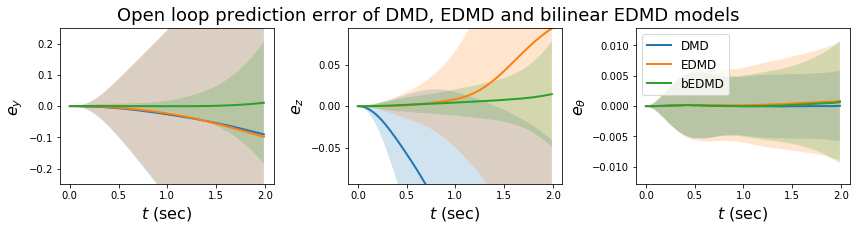

In [13]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 16
y_lim_gain = 1.2

#Plot open loop results:
ylabels = ['$e_{y}$', '$e_z$', '$e_{\\theta}$']
plt.figure(figsize=(figwidth,3))
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(t_eval[:-1], error_dmd_mean[ii,:], linewidth=lw, label='DMD')
    plt.fill_between(t_eval[:-1], error_dmd_mean[ii,:] - error_dmd_std[ii,:], error_dmd_mean[ii,:] + error_dmd_std[ii,:], alpha=0.2)
    plt.plot(t_eval[:-1], error_edmd_mean[ii, :], linewidth=lw, label='EDMD')
    plt.fill_between(t_eval[:-1], error_edmd_mean[ii, :] - error_edmd_std[ii, :],error_edmd_mean[ii, :] + error_edmd_std[ii, :], alpha=0.2)
    plt.plot(t_eval[:-1], error_bedmd_mean[ii, :], linewidth=lw, label='bEDMD')
    plt.fill_between(t_eval[:-1], error_bedmd_mean[ii, :] - error_bedmd_std[ii, :],error_bedmd_mean[ii, :] + error_bedmd_std[ii, :], alpha=0.2)
    ylim = max(max(np.abs(error_bedmd_mean[ii, :] - error_bedmd_std[ii, :])), max(np.abs(error_bedmd_mean[ii, :] + error_bedmd_std[ii, :])))
    plt.ylim([-ylim * y_lim_gain, ylim * y_lim_gain])
    plt.xlabel('$t$ (sec)', fontsize=fs)
    plt.ylabel(ylabels[ii], fontsize=fs)

plt.legend(loc='upper left', fontsize=fs-4)
suptitle = plt.suptitle('Open loop prediction error of DMD, EDMD and bilinear EDMD models', y=1.05, fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()


# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [14]:
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
#QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
QN_mpc = Q_mpc
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

ctrl_offset = np.array([hover_thrust, hover_thrust])

# Design trajectory:
x0_cl = np.array([0., 0., 0., 0., 0., 0.])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.5, 0.5, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xmax = np.array([2, 2, np.pi/3, 1.,1.,1.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = np.zeros((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [15]:
from koopman_core.controllers import MPCController, NonlinearMPCController, BilinearMPCController

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCController(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)
z0_cl = sys_bedmd.basis(x0_cl.reshape((1,-1))).squeeze()
z_init = sys_bedmd.basis(x_init)
controller_bedmd.construct_controller(z_init, u_init)

#### Design controller using full knowledge of nonlinear controller

In [16]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCController(quadrotor_d, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init+hover_thrust)

#### Design trajectories with the contructed MPCs

In [17]:
max_iter = 50

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction() + hover_thrust

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction() + hover_thrust

controller_bedmd.solve_to_convergence(z0_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = sys_bedmd.C@controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T + hover_thrust

/Users/carlaxelfolkestad/OneDrive - California Institute of Technology/Research/Learning to fly/Code/koopman-learning-control/koopman_core/controllers/nonlinear_mpc_controller.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  while (iter == 0 or np.linalg.norm(u_prev-self.cur_u)/np.linalg.norm(u_prev) > eps) and iter < max_iter:


In [18]:

controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init + ctrl_offset.reshape(1,-1), max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [19]:
ol_controller_dmd = OpenLoopController(quadrotor, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = quadrotor.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(quadrotor, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = quadrotor.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[ 1.60396519e-08  4.71542286e-10 -1.96203505e-04  6.41586077e-06
  9.40570418e-08 -3.92407010e-02]
[ 2.56634400e-07  1.83615668e-09 -7.84813762e-04  5.13268745e-05
  1.74334807e-07 -7.84813505e-02]
[ 1.29921127e-06  3.72963911e-09 -1.76583027e-03  1.73228120e-04
  1.84221389e-07 -1.17721950e-01]
[ 4.12268635e-06  7.66987034e-06 -3.13618650e-03  4.14222303e-04
  1.53298859e-03 -1.56349296e-01]
[ 1.01765562e-05  5.08121428e-05 -4.88475577e-03  8.26761795e-04
  7.09534530e-03 -1.93364559e-01]
[ 2.14139998e-05  1.65534157e-04 -6.99428691e-03  1.45829540e-03
  1.58488351e-02 -2.28541670e-01]
[ 4.01489438e-05  3.66991266e-04 -9.44023519e-03  2.33218781e-03
  2.44422300e-02 -2.60647986e-01]
[ 6.89753260e-05  6.53587843e-04 -1.21924269e-02  3.48195578e-03
  3.28765575e-02 -2.89790351e-01]
[ 1.10805678e-04  1.02373733e-03 -1.52217491e-02  4.93782253e-03
  4.11526040e-02 -3.16074094e-01]
[ 1.68838853e-04  1.47585985e-03 -1.85001347e-02  6.72684989e-03
  4.92709216e-02 -3.39603020e-01]
[ 2.465290

[0.72237302 0.30367868 0.02070476 0.85894758 0.2836087  0.11625647]
[0.73095184 0.3065291  0.02190817 0.85679671 0.28647496 0.12442665]
[0.73950853 0.30940862 0.02319555 0.85451809 0.2894289  0.13304807]
[0.74804175 0.312318   0.02457107 0.85210337 0.29244646 0.14205724]
[0.75655011 0.31525775 0.0260383  0.84954391 0.29550165 0.15138779]
[0.76503212 0.31822809 0.02760009 0.84683091 0.29856671 0.1609711 ]
[0.77348619 0.32122899 0.02925863 0.84395545 0.30161244 0.17073718]
[0.78191066 0.3242601  0.0310154  0.8409086  0.30460908 0.18061577]
[0.79030376 0.3273208  0.03287117 0.83768146 0.30752816 0.1905383 ]
[0.79866366 0.33041018 0.03482607 0.834265   0.31034781 0.20044199]
[0.80698841 0.33352721 0.03687964 0.83065001 0.31305613 0.21027249]
[0.81527597 0.33667074 0.03903092 0.8268272  0.31564814 0.21998189]
[0.82352423 0.3398396  0.04127846 0.82278727 0.31812322 0.22952692]
[0.83173097 0.34303263 0.04362043 0.81852109 0.32048148 0.23886646]
[0.83989388 0.34624866 0.04605456 0.81401977 0.3

[ 0.00149067  0.02042824 -0.03911146  0.02951784  0.20371692 -0.33106031]
[ 0.00180737  0.02250967 -0.04244869  0.03388118  0.21256606 -0.33638722]
[ 0.00216945  0.02467866 -0.04583444  0.03859655  0.22122943 -0.34076298]
[ 0.00258047  0.02693336 -0.04925937  0.04366751  0.22970713 -0.34422214]
[ 0.00304398  0.02927191 -0.05271447  0.04909659  0.23799929 -0.34679879]
[ 0.00356359  0.03169245 -0.0561911   0.05488542  0.24610606 -0.34852657]
[ 0.00414288  0.03419314 -0.05968093  0.06103469  0.25402766 -0.34943869]
[ 0.00478546  0.03677212 -0.06317596  0.06754425  0.26176433 -0.34956788]
[ 0.00549494  0.03942754 -0.06666853  0.07441312  0.26931641 -0.34894644]
[ 0.0062749   0.04215756 -0.07015129  0.08163957  0.27668427 -0.34760618]
[ 0.0071289   0.04496035 -0.07361722  0.08922108  0.2838684  -0.34557847]
[ 0.00806048  0.04783406 -0.07705958  0.09715447  0.29086934 -0.34289421]
[ 0.00907313  0.05077687 -0.08047197  0.10543587  0.29768773 -0.33958383]
[ 0.01017032  0.05378695 -0.08384828  

[ 1.13088315  0.51890273 -0.05971614  1.47600111  0.20362056  0.06512159]
[ 1.14567144  0.52092318 -0.0590463   1.48164618  0.20046879  0.06884586]
[ 1.16051586  0.52291233 -0.05833814  1.48722836  0.19736354  0.07278595]
[ 1.17541578  0.52487056 -0.05758968  1.49274252  0.19428225  0.07690554]
[ 1.19037047  0.52679797 -0.05679932  1.49818329  0.19120018  0.08116716]
[ 1.20537919  0.52869456 -0.05596573  1.50354675  0.1881195   0.08555152]
[ 1.22044113  0.53056037 -0.05508777  1.50882885  0.18504239  0.09003981]
[ 1.23555548  0.53239543 -0.0541645   1.51402543  0.18197099  0.09461369]
[ 1.25072134  0.53419982 -0.05319516  1.51913224  0.17890744  0.09925532]
[ 1.26593781  0.53597362 -0.05217914  1.52414498  0.17585384  0.10394735]
[ 1.28120391  0.53771695 -0.05111604  1.52905926  0.17281224  0.10867289]
[ 1.29651865  0.53942993 -0.0500056   1.53387068  0.16978468  0.11341557]
[ 1.31188097  0.54111271 -0.04884772  1.53857479  0.16677311  0.1181595 ]
[ 1.32728978  0.54276547 -0.04764248  

[ 0.0524769   0.14837964 -0.17555801  0.43300178  0.94348016 -0.21805523]
[ 0.05690884  0.15789621 -0.17758403  0.45342565  0.95982794 -0.18714726]
[ 0.06154412  0.16756495 -0.17930032  0.4736627   0.97391462 -0.15611083]
[ 0.06638059  0.17736291 -0.18070619  0.4936569   0.98567309 -0.12506495]
[ 0.07141556  0.18726652 -0.18180213  0.51335542  0.99504371 -0.09412179]
[ 0.07664581  0.19725162 -0.18258967  0.53270897  1.00197446 -0.06338633]
[ 0.08206767  0.20729361 -0.18307138  0.55167202  1.00642097 -0.03295623]
[ 0.08767703  0.21736745 -0.18325077  0.57020309  1.00834666 -0.00292179]
[ 0.09346988  0.22745048 -0.18313221  0.58836443  1.00826024  0.02663389]
[ 0.09944423  0.23753263 -0.18272087  0.60649831  1.00817086  0.05563505]
[ 0.10559964  0.2476138  -0.18202262  0.62457297  1.00806555  0.08401364]
[ 0.11193539  0.25769387 -0.18104402  0.64256118  1.00795229  0.11170752]
[ 0.11845047  0.26777275 -0.17979218  0.66043422  1.00782719  0.13865988]
[ 0.12514359  0.2778503  -0.17827479  

[ 1.38188268  0.70428734  0.11441177  0.97277375 -0.67473766  0.37416988]
[ 1.39156441  0.69744549  0.11811676  0.96352349 -0.69363833  0.36682944]
[ 1.4011513   0.69042181  0.12174379  0.95380583 -0.7111043   0.35857571]
[ 1.41063861  0.68323106  0.1252837   0.94360621 -0.72705097  0.34940663]
[ 1.42002143  0.67588885  0.12872734  0.93291081 -0.74139773  0.3393219 ]
[ 1.42929476  0.66841155  0.13206557  0.92170677 -0.75406843  0.32832308]
[ 1.43845344  0.66081628  0.13528925  0.90998242 -0.7649918   0.31641372]
[ 1.44749222  0.65312084  0.13838932  0.89772756 -0.77410191  0.30359942]
[ 1.45640575  0.64534367  0.14135675  0.88493363 -0.78133857  0.28988798]
[ 1.4651886   0.63750377  0.14418264  0.87159402 -0.78664778  0.2752895 ]
[ 1.47383531  0.62962065  0.14685817  0.85770426 -0.78998211  0.2598165 ]
[ 1.48234034  0.62171427  0.14937467  0.8432623  -0.79130109  0.24348403]
[ 1.49069819  0.61380493  0.15172364  0.82826872 -0.79057162  0.22630978]
[ 1.49890335  0.60591326  0.15389676  

[ 0.1973638   0.32012638 -0.12435481  0.79044799  0.99885428  0.3128101 ]
[ 0.20532907  0.33011494 -0.12117899  0.80255429  0.99886399  0.32235444]
[ 0.21341384  0.34010386 -0.11791218  0.81434617  0.99892692  0.33100685]
[ 0.2216149   0.35009355 -0.11456333  0.82581187  0.99901683  0.33876277]
[ 0.2299289   0.36008375 -0.11114142  0.8369318   0.99902835  0.34561963]
[ 0.23835237  0.37007386 -0.10765544  0.84770429  0.99900094  0.35157681]
[ 0.24688181  0.38006359 -0.10411437  0.85812565  0.99895051  0.35663567]
[ 0.25551298  0.39004592 -0.1005272   0.8680521   0.99752148  0.36079944]
[ 0.26424098  0.40000702 -0.09690284  0.87748891  0.99470454  0.36407322]
[ 0.27306097  0.40993345 -0.09325015  0.88645174  0.99058805  0.36646385]
[ 0.28196829  0.41981268 -0.08957793  0.89495635  0.98526135  0.36797995]
[ 0.29095845  0.42963303 -0.08589487  0.9030184   0.97881443  0.36863184]
[ 0.30002708  0.43938377 -0.08220956  0.91065345  0.97133756  0.36843151]
[ 0.30917001  0.44905504 -0.07853043  

[ 1.45568757  0.55674046  0.15911749  0.43357467 -0.6487279  -0.14050696]
[ 1.45992345  0.55038698  0.15759168  0.41363237 -0.621964   -0.16465633]
[ 1.46395986  0.54430786  0.15582454  0.39368793 -0.59385269 -0.18877101]
[ 1.46779707  0.53851602  0.1538168   0.37379541 -0.56451015 -0.21277646]
[ 1.47143586  0.53302312  0.15156995  0.35401033 -0.53406182 -0.23659487]
[ 1.47487759  0.52783956  0.14908625  0.33438928 -0.50264216 -0.26014515]
[ 1.47812418  0.52297433  0.14636881  0.31498945 -0.47039443 -0.28334301]
[ 1.48117815  0.51843496  0.14342159  0.29586817 -0.43747034 -0.30610101]
[ 1.48404256  0.51422741  0.14024944  0.27708242 -0.4040297  -0.32832865]
[ 1.48672104  0.51035601  0.13685813  0.25868833 -0.37023993 -0.34993244]
[ 1.48921778  0.50682338  0.13325439  0.24074063 -0.33627557 -0.37081603]
[ 1.49153753  0.50363036  0.12944591  0.2232921  -0.3023176  -0.39088033]
[ 1.49368552  0.50077595  0.12544139  0.20639305 -0.26855277 -0.41002366]
[ 1.49566747  0.49825726  0.12125056  

##### Compare performance

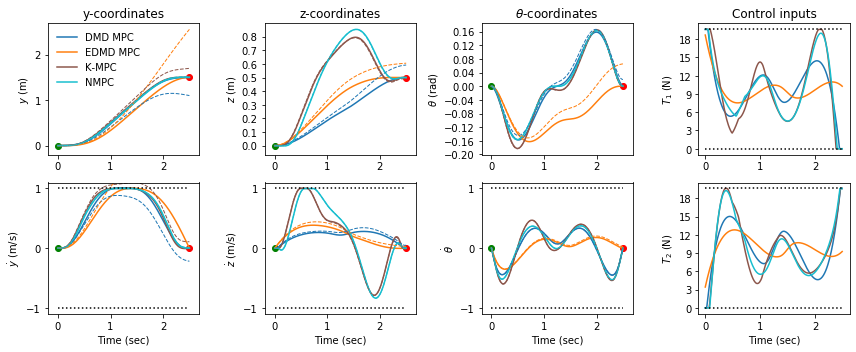

Solution statistics:

                       Normalized cost,    Realized terminal,  # of SQP      Mean comp. time           Total comp.
                    designed trajectory                 error  iterations    per iteration (secs)      time (secs)
----------------  ---------------------  --------------------  ------------  ----------------------  -------------
DMD MPC                          0.9291                0.4687  -             -                            0.197346
EDMD MPC                         0.8385                1.7587  -             -                            2.94766
bEDMD MPC                        1.04                  0.2261  15            2.4204                      36.3063
NMPC (benchmark)                 1                     0.0174  8             0.1517                       1.21389


In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:cyan']

plt.figure(figsize=(12,5))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='K-MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[3], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[3], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
            plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [21]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T+hover_thrust
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T+hover_thrust
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))
    
for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

[ 0.        -0.0004905  0.         0.        -0.0981     0.       ]
[ 0.       -0.001962  0.        0.       -0.1962    0.      ]
[ 0.        -0.0044145  0.         0.        -0.2943     0.       ]
[ 0.       -0.007848  0.        0.       -0.3924    0.      ]
[ 0.        -0.0122625  0.         0.        -0.4905     0.       ]
[ 0.       -0.017658  0.        0.       -0.5886    0.      ]
[ 0.        -0.0240345  0.         0.        -0.6867     0.       ]
[ 0.       -0.031392  0.        0.       -0.7848    0.      ]
[ 0.        -0.0397305  0.         0.        -0.8829     0.       ]
[ 0.      -0.04905  0.       0.      -0.981    0.     ]
[ 0.        -0.0593505  0.         0.        -1.0791     0.       ]
[ 0.       -0.070632  0.        0.       -1.1772    0.      ]
[ 0.        -0.0828945  0.         0.        -1.2753     0.       ]
[ 0.       -0.096138  0.        0.       -1.3734    0.      ]
[ 0.        -0.1103625  0.         0.        -1.4715     0.       ]
[ 0.       -0.125568  0.    

[  0.        -27.0878625   0.          0.        -23.0535      0.       ]
[  0.       -27.318888   0.         0.       -23.1516     0.      ]
[  0.        -27.5508945   0.          0.        -23.2497      0.       ]
[  0.       -27.783882   0.         0.       -23.3478     0.      ]
[  0.        -28.0178505   0.          0.        -23.4459      0.       ]
[  0.     -28.2528   0.       0.     -23.544    0.    ]
[  0.        -28.4887305   0.          0.        -23.6421      0.       ]
[  0.       -28.725642   0.         0.       -23.7402     0.      ]
[  0.        -28.9635345   0.          0.        -23.8383      0.       ]
[  0.       -29.202408   0.         0.       -23.9364     0.      ]
[  0.        -29.4422625   0.          0.        -24.0345      0.       ]
[  0.       -29.683098   0.         0.       -24.1326     0.      ]
[  0.        -29.9249145   0.          0.        -24.2307      0.       ]
[  0.       -30.167712   0.         0.       -24.3288     0.      ]
[  0.        -30.4

[ 0.40266737  0.18651431 -0.09125038  0.96950485  0.33016832  0.19069885]
[ 0.41240841  0.18983169 -0.08933327  0.9786713   0.33331069  0.1927227 ]
[ 0.42224015  0.19318058 -0.08739679  0.98764257  0.33646966  0.19457297]
[ 0.43216061  0.19656114 -0.08544266  0.99641676  0.33964501  0.19625266]
[ 0.44216782  0.19997353 -0.08347257  1.00499212  0.34283649  0.19776501]
[ 0.45225978  0.20341792 -0.08148818  1.0133671   0.3460438   0.19911358]
[ 0.46243449  0.20689446 -0.0794911   1.0215403   0.34926665  0.20030216]
[ 0.47268991  0.2104033  -0.07748292  1.02951048  0.35250471  0.20133487]
[ 0.48302402  0.2139446  -0.07546516  1.03727657  0.35575763  0.20221606]
[ 0.49343476  0.2175185  -0.07343933  1.04483764  0.35902505  0.20295039]
[ 0.50392008  0.22112515 -0.07140686  1.05219292  0.36230659  0.20354279]
[ 0.51447793  0.22476468 -0.06936916  1.05934178  0.36560185  0.20399848]
[ 0.52510623  0.22843723 -0.06732755  1.06628373  0.36891042  0.20432293]
[ 0.53580291  0.23214293 -0.06528333  

[1.74309343 0.94243134 0.15055515 0.37448371 0.72272011 0.05762372]
[1.74676251 0.94966678 0.15112661 0.35932259 0.72436675 0.05666723]
[1.7502797  0.95691862 0.15168984 0.34410573 0.72599941 0.05597952]
[1.75364444 0.96418671 0.15224761 0.32883381 0.72761823 0.05557543]
[ 1.60362253e-08  6.88078547e-06 -1.93448067e-04  6.41449010e-06
  1.37615685e-03 -3.86896135e-02]
[ 2.60161417e-07  3.86900605e-05 -7.69325473e-04  5.21725857e-05
  4.98569365e-03 -7.64858678e-02]
[ 1.33107245e-06  1.18614346e-04 -1.71835745e-03  1.78477453e-04
  1.09991433e-02 -1.13320527e-01]
[ 4.24966326e-06  2.71430277e-04 -3.03063276e-03  4.28569649e-04
  1.95639879e-02 -1.49134536e-01]
[ 1.04798485e-05  5.23279264e-04 -4.69569340e-03  8.47810821e-04
  3.08056929e-02 -1.83877592e-01]
[ 2.19498246e-05  9.01458086e-04 -6.70262222e-03  1.48368862e-03
  4.48298583e-02 -2.17508171e-01]
[ 4.09743889e-05  1.42106093e-03 -9.03486283e-03  2.36489953e-03
  5.90903686e-02 -2.48939951e-01]
[ 7.01939482e-05  2.08475540e-03 -1

[ 0.61474102  0.79781177 -0.04109306  1.12581921  0.69608191  0.17449657]
[ 0.62601537  0.80468067 -0.03937409  1.12902792  0.6776996   0.1692963 ]
[ 0.63732116  0.81136672 -0.03770671  1.13210893  0.65951116  0.16418019]
[ 0.64865718  0.81787289 -0.03608979  1.13507336  0.6417244   0.15920401]
[ 0.6600223   0.82420402 -0.03452167  1.13792965  0.62450161  0.15442053]
[ 0.67141547  0.83036636 -0.03300017  1.14068409  0.60796626  0.14987946]
[ 0.6828357   0.83636721 -0.03152264  1.1433411   0.59220572  0.1456269 ]
[ 0.69428202  0.84221461 -0.03008598  1.1459036   0.57727474  0.14170503]
[ 0.70575351  0.84791698 -0.02868669  1.14837324  0.5631992   0.13815177]
[ 0.71724922  0.85348287 -0.02732093  1.15075061  0.54997954  0.1350006 ]
[ 0.72876825  0.85892073 -0.02598453  1.15303548  0.53759393  0.1322803 ]
[ 0.74030966  0.86423871 -0.02467305  1.15522691  0.52600135  0.1300148 ]
[ 0.7518725   0.86944444 -0.02338186  1.15732341  0.51514444  0.12822299]
[ 0.76345583  0.87454492 -0.02210615  

  8.28921572e-08 -7.84798434e-02]
[ 1.30087889e-06  1.62046037e-06 -1.76514898e-03  1.73605730e-04
  3.23807007e-04 -1.17590272e-01]
[ 4.14628606e-06  2.12048666e-05 -3.13071245e-03  4.18546718e-04
  3.59301819e-03 -1.55522422e-01]
[ 1.02516961e-05  8.84135962e-05 -4.86878925e-03  8.32764969e-04
  9.84860738e-03 -1.92092939e-01]
[ 2.15041856e-05  2.24562873e-04 -6.96133031e-03  1.45457296e-03
  1.73810307e-02 -2.26415272e-01]
[ 4.01941464e-05  4.43075189e-04 -9.38808449e-03  2.32671252e-03
  2.63210793e-02 -2.58935564e-01]
[ 6.90390004e-05  7.58521711e-04 -1.21304239e-02  3.49187022e-03
  3.67676919e-02 -2.89532323e-01]
[ 1.11181952e-04  1.18632363e-03 -1.51685814e-02  4.99248262e-03
  4.87919325e-02 -3.18099166e-01]
[ 1.70187595e-04  1.74248049e-03 -1.84818170e-02  6.87035300e-03
  6.24384018e-02 -3.44547966e-01]
[ 2.50033406e-04  2.44331346e-03 -2.20486091e-02  9.16621468e-03
  7.77268265e-02 -3.68810439e-01]
[ 3.55096715e-04  3.30522532e-03 -2.58468568e-02  1.19192639e-02
  9.465380

[ 0.79106892  0.77611033 -0.00172241  1.1019767   0.35635042 -0.00641252]
[ 0.80208951  0.77965939 -0.00179144  1.1021439   0.35346117 -0.00739237]
[ 0.81311181  0.78317797 -0.00186504  1.1023174   0.35025543 -0.00732714]
[ 0.82413588  0.78666246 -0.00193294  1.10249691  0.34664195 -0.0062536 ]
[ 0.83516177  0.79010835 -0.00198528  1.10268122  0.34253685 -0.00421522]
[ 0.84618951  0.79351036 -0.00201267  1.10286821  0.33786543 -0.00126137]
[ 0.85721913  0.79686251 -0.00200621  1.10305498  0.33256426  0.00255345]
[ 0.8682506   0.80015825 -0.00195759  1.1032379   0.32658336  0.00717046]
[ 0.87928386  0.80339061 -0.0018591   1.10341274  0.31988875  0.01252738]
[ 0.89031881  0.80655238 -0.00170367  1.10357473  0.31246616  0.01855845]
[ 0.90135529  0.80963629 -0.00148486  1.10371863  0.30431445  0.02520285]
[ 0.9123931   0.81263506 -0.00119683  1.1038388   0.29544051  0.03240347]
[ 9.23431965e-01  8.15541546e-01 -8.34282650e-04  1.10392926e+00
  2.85856262e-01  4.01062383e-02]
[ 9.34471562e

[ 2.53816166e-04  2.38265321e-03 -2.26253228e-02  9.42161071e-03
  8.26470674e-02 -3.88017434e-01]
[ 3.62107546e-04  3.30644026e-03 -2.66358606e-02  1.23152459e-02
  1.02108406e-01 -4.14090124e-01]
[ 0.000502    0.00443402 -0.03089717  0.01574841  0.12340466 -0.43817244]
[ 0.0006791   0.00578332 -0.03538908  0.01976285  0.14645185 -0.46020929]
[ 0.00089942  0.00737132 -0.04009088  0.02439723  0.17114519 -0.48014943]
[ 0.00116934  0.00921388 -0.04498135  0.02968655  0.19736249 -0.4979464 ]
[ 0.00149555  0.01132555 -0.05003888  0.03566166  0.22496749 -0.5135593 ]
[ 0.00188505  0.01371949 -0.05524145  0.04234886  0.25381315 -0.52695338]
[ 0.00234507  0.01640731 -0.06056672  0.04976952  0.28374476 -0.53810066]
[ 0.00288304  0.01939908 -0.06599212  0.05793986  0.31460277 -0.54698043]
[ 0.0035065   0.02270326 -0.07149492  0.0668708   0.34622529 -0.55357969]
[ 0.00422309  0.02632669 -0.07705229  0.07656787  0.3784503  -0.55789361]
[ 0.00504047  0.03027457 -0.08264139  0.08703124  0.41111744 -

[ 0.87390094  0.79408893 -0.0090321   1.09941642  0.37221672  0.03183524]
[ 0.88489902  0.79775949 -0.0086641   1.10019383  0.36189422  0.04176476]
[ 0.89590468  0.80132504 -0.00819441  1.10093151  0.35121614  0.05217482]
[ 0.90691748  0.80478196 -0.00761854  1.10162058  0.34016849  0.06299907]
[ 0.91793689  0.80812645 -0.00693266  1.10225191  0.32872963  0.07417599]
[ 0.92896229  0.81135449 -0.00613355  1.10281622  0.31687815  0.08564694]
[ 0.93999296  0.81446185 -0.00521853  1.10330415  0.30459332  0.0973562 ]
[ 0.95102808  0.81744409 -0.0041855   1.10370637  0.29185541  0.10925074]
[ 0.96206676  0.8202966  -0.00303284  1.10401361  0.27864603  0.12128011]
[ 0.97310801  0.82301457 -0.00175946  1.1042167   0.26494844  0.13339622]
[ 9.84150720e-01  8.25593048e-01 -3.64712564e-04  1.10430666e+00
  2.50747609e-01  1.45553144e-01]
[0.99519373 0.82802694 0.00115159 1.1042747  0.23603047 0.15770694]
[1.00623578 0.83031102 0.0027892  1.10411228 0.22078616 0.16981546]
[1.01727552 0.83243998 0.

[ 1.60393332e-08  1.78387198e-10 -1.96199723e-04  6.41573328e-06
  3.54260341e-08 -3.92399447e-02]
[ 2.56629327e-07  6.75449587e-10 -7.84798911e-04  5.13258646e-05
  5.94555885e-08 -7.84798928e-02]
[ 1.29918587e-06  1.15000449e-09 -1.76579760e-03  1.73224765e-04
  1.53158527e-08 -1.17719844e-01]
[ 4.10606799e-06  2.77748094e-10 -3.13919581e-03  4.10606660e-04
 -2.44396790e-07 -1.56959799e-01]
[ 1.00245751e-05 -5.38165528e-09 -4.90499360e-03  8.01965334e-04
 -1.00303753e-06 -1.96199758e-01]
[ 2.07869401e-05 -2.29706378e-08 -7.06319098e-03  1.38579356e-03
 -2.72522258e-06 -2.35439719e-01]
[ 3.85704049e-05  7.59171535e-06 -9.61072507e-03  2.21320036e-03
  1.52531057e-03 -2.74067098e-01]
[ 6.61608373e-05  4.94570497e-05 -1.25369395e-02  3.35532522e-03
  6.84719865e-03 -3.11175786e-01]
[ 1.07017244e-04  1.64242521e-04 -1.58263519e-02  4.87481568e-03
  1.61090619e-02 -3.46706703e-01]
[ 1.65147202e-04  3.86328720e-04 -1.94606974e-02  6.81798600e-03
  2.83070001e-02 -3.80162384e-01]
[ 2.450015

[ 0.69588534  0.70153928 -0.00625944  1.08413581  0.41886695 -0.01137996]
[ 0.70672969  0.70571189 -0.00641181  1.08473639  0.41565547 -0.01909389]
[ 0.71758012  0.70985077 -0.00663539  1.08535278  0.41211978 -0.02562285]
[ 0.72843681  0.71395258 -0.00691827  1.0859909   0.4082414  -0.03095308]
[ 0.73930002  0.71801385 -0.00724843  1.08665551  0.40401263 -0.03507925]
[ 0.75017002  0.72203108 -0.00761385  1.08735027  0.39943453 -0.03800408]
[ 0.76104713  0.72600083 -0.00800256  1.08807771  0.39451436 -0.03973788]
[ 0.77193168  0.72991971 -0.00840274  1.08883929  0.38926308 -0.04029817]
[ 0.78282403  0.73378449 -0.00880278  1.08963537  0.38369277 -0.03970925]
[ 0.7937245   0.73759203 -0.00919133  1.09046525  0.3778143  -0.0380018 ]
[ 0.80463343  0.74133928 -0.0095574   1.09132719  0.37163542 -0.03521246]
[ 0.81555114  0.74502325 -0.00989038  1.09221845  0.36515914 -0.03138342]
[ 0.82647788  0.74864096 -0.01018011  1.0931353   0.35838272 -0.02656198]
[ 0.83741391  0.75218936 -0.01041692  

 -1.25760964e-08 -7.84800191e-02]
[ 1.29918752e-06 -4.69093914e-10 -1.76580043e-03  1.73224984e-04
 -9.21415257e-08 -1.17720028e-01]
[ 4.10607316e-06 -2.58985361e-09 -3.13920076e-03  4.10607172e-04
 -3.86640223e-07 -1.56960037e-01]
[ 1.00245876e-05 -9.84150913e-09 -4.90500117e-03  8.01966320e-04
 -1.17924484e-06 -1.96200045e-01]
[ 2.07869657e-05 -2.93573839e-08 -7.06320166e-03  1.38579524e-03
 -2.93439428e-06 -2.35440054e-01]
[ 3.85210272e-05  1.28497899e-06 -9.61325862e-03  2.20282456e-03
  2.65453878e-04 -2.74571339e-01]
[ 6.59674110e-05  2.65168148e-05 -1.25461296e-02  3.33661159e-03
  4.78035846e-03 -3.12002865e-01]
[ 1.06590955e-04  1.16806675e-04 -1.58435014e-02  4.84667848e-03
  1.32767830e-02 -3.47471491e-01]
[ 1.64345961e-04  3.04449557e-04 -1.94832343e-02  6.77048948e-03
  2.42506256e-02 -3.80475083e-01]
[ 2.43642036e-04  6.14260949e-04 -2.34410138e-02  9.16231329e-03
  3.77100743e-02 -4.11080820e-01]
[ 3.49425962e-04  1.07094579e-03 -2.76924803e-02  1.20752604e-02
  5.362482

[ 0.77495276  0.71985223 -0.01008687  1.08429923  0.38378382 -0.033379  ]
[ 0.78580043  0.72365777 -0.01040925  1.08523857  0.37732423 -0.0310975 ]
[ 0.79665762  0.72739761 -0.01070325  1.08620391  0.3706433  -0.02770316]
[ 0.80752458  0.73106957 -0.010958    1.08719209  0.36374782 -0.02324725]
[ 0.81840152  0.73467149 -0.01116317  1.08819893  0.35663658 -0.01778649]
[ 0.8292886   0.73820117 -0.01130902  1.08921929  0.34930008 -0.01138222]
[ 0.84018592  0.74165628 -0.01138643  1.09024709  0.34172081 -0.00409962]
[ 0.85109354  0.74503425 -0.01138696  1.09127542  0.33387398  0.00399307]
[ 0.8620114   0.74833227 -0.01130287  1.09229666  0.325729    0.01282543]
[ 0.87293941  0.75154717 -0.01112711  1.09330253  0.31725158  0.0223258 ]
[ 0.88387737  0.75467546 -0.01085337  1.09428426  0.30840672  0.03242217]
[ 0.89482498  0.75771329 -0.01047602  1.09523267  0.29915957  0.04304718]
[ 0.90578187  0.76065646 -0.0099901   1.09613828  0.28947491  0.05413781]
[ 0.91674756  0.76350043 -0.00939125  

[ 2.07869689e-05 -2.99940759e-08 -7.06320294e-03  1.38579545e-03
 -2.95607409e-06 -2.35440093e-01]
[ 3.85103676e-05 -7.48828260e-08 -9.61380392e-03  2.20058516e-03
 -6.36858796e-06 -2.74680105e-01]
[ 6.58974315e-05  1.88867406e-05 -1.25491835e-02  3.32668235e-03
  3.79814173e-03 -3.12395808e-01]
[ 1.06373308e-04  9.56190253e-05 -1.58525085e-02  4.82676873e-03
  1.15474886e-02 -3.48269195e-01]
[ 1.63874250e-04  2.62355232e-04 -1.95030507e-02  6.73934306e-03
  2.17985884e-02 -3.81839239e-01]
[ 2.42800102e-04  5.44157168e-04 -2.34770124e-02  9.11925410e-03
  3.45602217e-02 -4.12953107e-01]
[ 3.48094667e-04  9.66004318e-04 -2.77495321e-02  1.20203717e-02
  4.98071418e-02 -4.41550827e-01]
[ 0.00048523  0.00155245 -0.03229519  0.01549468  0.06748013 -0.46758175]
[ 0.00066019  0.00232732 -0.03708813  0.01959143  0.08748946 -0.49100526]
[ 0.00087943  0.00331338 -0.04210211  0.02435628  0.10971864 -0.51179126]
[ 0.00114983  0.00453214 -0.04731067  0.02983058  0.13402849 -0.52992044]
[ 0.0014786

[ 0.80893271  0.73397204 -0.01198095  1.08530097  0.35587435 -0.02599166]
[ 0.81979123  0.73749704 -0.01221073  1.08640647  0.34912688 -0.01996426]
[ 0.83066088  0.74095343 -0.01237557  1.08752725  0.34215058 -0.01300446]
[ 0.8415418   0.74433877 -0.01246648  1.08865656  0.33491696 -0.00517748]
[ 0.85243401  0.74765031 -0.01247512  1.08978679  0.32739056  0.00344857]
[ 0.8633375   0.75088491 -0.01239386  1.09090964  0.31953056  0.01280353]
[ 0.87425214  0.75403903 -0.01221577  1.09201619  0.31129308  0.02281605]
[ 0.88517773  0.75710867 -0.01193461  1.09309705  0.30263437  0.0334145 ]
[ 0.89611396  0.76008942 -0.01154487  1.09414256  0.29351732  0.04453314]
[ 0.90706042  0.76297655 -0.01104166  1.0951428   0.28390718  0.05610937]
[ 0.91801662  0.76576493 -0.01042071  1.09608766  0.27377001  0.06808194]
[ 0.92898195  0.76844915 -0.00967834  1.09696694  0.26307311  0.08039109]
[ 0.9399557   0.77102344 -0.00881149  1.09777045  0.2517855   0.09297855]
[ 0.95093706  0.77348176 -0.00781766  

[ 0.00048272  0.00129378 -0.03251706  0.01548349  0.06246301 -0.47505902]
[ 0.00065778  0.00202054 -0.03738969  0.01962547  0.08288397 -0.49946655]
[ 0.00087767  0.0029634  -0.04249248  0.02445481  0.1056858  -0.52109267]
[ 0.00114948  0.00414543 -0.04779754  0.03001534  0.1307153  -0.53991975]
[ 0.00148071  0.00558803 -0.05327686  0.03634548  0.15779893 -0.55594364]
[ 0.00187923  0.0073108  -0.05890244  0.04347765  0.18674716 -0.56917282]
[ 0.00235319  0.00933137 -0.06464644  0.05143774  0.21735869 -0.57962743]
[ 0.00291097  0.01166532 -0.07048127  0.0602448   0.24942433 -0.58733823]
[ 0.0035611   0.01432615 -0.07637969  0.06991085  0.28273058 -0.59234566]
[ 0.00431221  0.01732516 -0.08231491  0.08044083  0.31706271 -0.59469892]
[ 0.00517291  0.02067157 -0.08826069  0.09183264  0.35220743 -0.59445522]
[ 0.0061518   0.02437244 -0.09419136  0.10407732  0.38795503 -0.59167922]
[ 0.00725732  0.02843279 -0.10008197  0.11715929  0.42410104 -0.58644251]
[ 0.00849775  0.0328556  -0.1059083   

[ 0.95416863  0.77964783 -0.0087256   1.09758412  0.26057537  0.10314474]
[ 0.96514805  0.7821899  -0.0076267   1.09828305  0.24784022  0.11663343]
[ 0.97613394  0.78460076 -0.00639219  1.09887696  0.2343313   0.13026909]
[ 0.9871252   0.78687256 -0.00502087  1.09935612  0.22002932  0.14399555]
[ 0.99812064  0.7889973  -0.00351209  1.09971114  0.2049172   0.15775939]
[ 1.00911897  0.79096679 -0.00186575  1.09993302  0.18898213  0.17150932]
[ 1.02011882e+00  7.92772782e-01 -8.22233588e-05  1.10001316e+00
  1.72215710e-01  1.85196157e-01]
[1.03111873 0.79440693 0.00183762 1.09994342 0.15461416 0.19877274]
[1.04211717 0.79586089 0.00389245 1.09971607 0.13617842 0.21219388]
[1.05311251 0.79712636 0.00608051 1.09932382 0.11691426 0.22541634]
[1.06410308 0.79819509 0.00839958 1.0987598  0.09683234 0.2383987 ]
[1.07508712 0.799059   0.01084708 1.09801752 0.07594828 0.25110134]
[1.08606283 0.79971015 0.01342002 1.09709084 0.05428266 0.26348632]
[1.09702832 0.80014088 0.01611504 1.09597394 0.03

[ 0.00354795  0.01353159 -0.07653679  0.06979373  0.27418509 -0.59334311]
[ 0.00429798  0.01644507 -0.0824812   0.08034385  0.30849932 -0.59553888]
[ 0.00515785  0.01970602 -0.08843448  0.09176159  0.34368011 -0.59511755]
[ 0.00613618  0.02332205 -0.09437081  0.10403797  0.37951322 -0.59214839]
[ 0.0072415   0.02729863 -0.1002651   0.1171573   0.41578998 -0.58670868]
[ 0.00848212  0.03163919 -0.10609306  0.1310975   0.45230847 -0.57888327]
[ 0.00986611  0.03634517 -0.1118313   0.14583047  0.48887424 -0.56876415]
[ 0.01140125  0.04141612 -0.11745737  0.16132249  0.5253007  -0.55645012]
[ 0.01309492  0.04684975 -0.12294985  0.17753463  0.56140928 -0.54204633]
[ 0.01495411  0.05264201 -0.1282884   0.19442321  0.59702937 -0.52566391]
[ 0.01698536  0.05878723 -0.13345382  0.21194024  0.63199823 -0.50741944]
[ 0.01919468  0.0652781  -0.13842809  0.23003395  0.6661607  -0.48743446]
[ 0.02158758  0.07210582 -0.14319443  0.24864924  0.69936905 -0.46583478]
[ 0.02416897  0.07926015 -0.14773736  

[1.03125379 0.78340547 0.00186179 1.09917414 0.14492236 0.19757072]
[1.04224452 0.78476484 0.00390411 1.09894402 0.12695269 0.21089398]
[1.05323213 0.7859403  0.00607867 1.09854914 0.10813795 0.22401915]
[1.06421494 0.78692342 0.0083833  1.09798271 0.08848622 0.23690527]
[1.0751912  0.7877059  0.01081539 1.09723836 0.06801076 0.24951323]
[1.08615911 0.78827961 0.01337198 1.09631007 0.04673008 0.26180572]
[1.09711679 0.7886366  0.01604975 1.09519217 0.02466791 0.27374705]
[1.10806232 0.78876921 0.018845   1.09387923 0.00185321 0.28530316]
[ 1.11899373  0.78867008  0.02175372  1.09236605 -0.02167991  0.29644145]
[ 1.12990898  0.78833223  0.02477158  1.09064758 -0.04589223  0.30713077]
[ 1.140806    0.78774907  0.02789394  1.08871881 -0.07073954  0.31734127]
[ 1.15168267  0.78691452  0.03111587  1.08657475 -0.09617274  0.32704441]
[ 1.16253679  0.78582297  0.03443216  1.08421031 -0.12213799  0.3362128 ]
[ 1.17336615  0.7844694   0.03783732  1.08162024 -0.14857689  0.34482022]
[ 1.18416845

[ 0.00725119  0.02727046 -0.10049926  0.1174204   0.4164277  -0.58891702]
[ 0.00849467  0.03161809 -0.10634928  0.13140828  0.4530842  -0.58108693]
[ 0.00988203  0.03633249 -0.11210941  0.14619226  0.48978299 -0.57093955]
[ 0.01142105  0.04141316 -0.11775697  0.16173826  0.52633585 -0.55857155]
[ 0.01311916  0.04685773 -0.12327026  0.17800695  0.56256276 -0.54408625]
[ 0.01498337  0.05266208 -0.12862866  0.19495422  0.59829186 -0.52759355]
[ 0.01702022  0.05882041 -0.13381267  0.21253161  0.63335931 -0.5092096 ]
[ 0.01923576  0.06532533 -0.138804    0.23068681  0.667609   -0.48905652]
[ 0.02163549  0.07216791 -0.14358559  0.24936415  0.70089231 -0.46726185]
[ 0.02422434  0.07933778 -0.14814169  0.26850513  0.73306789 -0.443958  ]
[ 0.02700665  0.0868232  -0.15245789  0.28804893  0.76400149 -0.41928142]
[ 0.02998613  0.0946111  -0.15652116  0.30793296  0.79356573 -0.39337162]
[ 0.03316586  0.10268719 -0.16031987  0.3280934   0.8216401  -0.36637013]
[ 0.03654829  0.11103601 -0.16384381  

[ 1.12000132  0.78917551  0.02157201  1.09318177 -0.02096865  0.2982816 ]
[ 1.13092481  0.78884427  0.02460901  1.09147834 -0.04528114  0.30911852]
[ 1.14183021  0.78826669  0.02775196  1.08956354 -0.07023518  0.31947077]
[ 1.15271538  0.78743661  0.03099586  1.08743234 -0.09578157  0.32930922]
[ 1.16357814  0.78634838  0.03433543  1.08507963 -0.12186636  0.33860598]
[ 1.17441625  0.7849969   0.03776514  1.08250017 -0.14843101  0.34733435]
[ 1.1852274   0.78337769  0.04127915  1.07968843 -0.17541261  0.35546875]
[ 1.19600925  0.78148692  0.04487142  1.07663862 -0.20274404  0.36298468]
[ 1.20675938  0.77932144  0.04853564  1.0733445  -0.23035423  0.36985865]
[ 1.21747531  0.77687883  0.05226527  1.06979943 -0.25816841  0.3760682 ]
[ 1.22815451  0.77415746  0.05605357  1.0659962  -0.28610836  0.38159182]
[ 1.23879435  0.77115647  0.05989357  1.06192707 -0.31409273  0.38640896]
[ 1.24939214  0.76787583  0.06377812  1.05758365 -0.34203731  0.39049999]
[ 1.25994507  0.76431639  0.06769985  

[ 0.00065314  0.00172018 -0.0374926   0.0194894   0.07498597 -0.50201745]
[ 0.00087161  0.00258095 -0.04262181  0.02430785  0.09716558 -0.52382421]
[ 0.00114192  0.00367534 -0.04795487  0.02986394  0.12170715 -0.54278806]
[ 0.00147166  0.00502605 -0.05346333  0.03619726  0.14842825 -0.55890393]
[ 0.00186875  0.00665387 -0.05911875  0.04334118  0.17712964 -0.57217985]
[ 0.00234145  0.00857756 -0.06489283  0.05132239  0.20759996 -0.58263608]
[ 0.00289823  0.0108137  -0.07075753  0.06016053  0.23961997 -0.59030421]
[ 0.00354772  0.01337668 -0.07668518  0.06986799  0.27296642 -0.59522626]
[ 0.00429865  0.01627864 -0.08264858  0.0804499   0.30741533 -0.59745391]
[ 0.00515976  0.0195295  -0.08862109  0.09190416  0.34274475 -0.59704772]
[ 0.00613972  0.02313697 -0.09457671  0.10422166  0.37873692 -0.59407656]
[ 0.0072471   0.02710662 -0.10049018  0.11738649  0.41517989 -0.58861708]
[ 0.00849026  0.03144193 -0.10633703  0.13137628  0.45186871 -0.58075336]
[ 0.00987731  0.03614437 -0.11209368  

[ 0.97703263  0.77207074 -0.00659122  1.09856479  0.22142278  0.1289077 ]
[ 0.98802087  0.77421657 -0.00523349  1.09906489  0.20774327  0.14263881]
[ 0.99901351  0.77622151 -0.00373821  1.09944087  0.19324443  0.15641647]
[ 1.01000924  0.77807727 -0.00210519  1.09968364  0.177909    0.17018804]
[ 1.02100670e+00  7.79775440e-01 -3.34735305e-04  1.09978451e+00
  1.61724372e-01  1.83903124e-01]
[1.03200443 0.78130748 0.00157235 1.09973527 0.14468273 0.19751356]
[1.04300088 0.7826648  0.00361478 1.09952817 0.12678126 0.21097333]
[1.05399445 0.78383881 0.00579084 1.09915591 0.10802225 0.2242385 ]
[1.06498344 0.78482099 0.00809837 1.09861167 0.0884132  0.2372671 ]
[1.0759661  0.78560289 0.0105348  1.09788901 0.06796689 0.25001911]
[1.08694062 0.78617624 0.01309718 1.09698188 0.04670142 0.26245628]
[1.09790512 0.78653295 0.01578217 1.0958846  0.0246402  0.27454214]
[1.10885768 0.78666521 0.01858609 1.09459172 0.00181198 0.28624183]
[ 1.11979631  0.78656553  0.02150491  1.09309806 -0.02174925 

[ 0.00993776  0.0367642  -0.11257354  0.14727692  0.49757057 -0.57361998]
[ 0.01148827  0.04192558 -0.11824678  0.16295384  0.53469106 -0.56102873]
[ 0.01319919  0.04745631 -0.12378341  0.17935431  0.57143923 -0.54629626]
[ 0.01507752  0.05335177 -0.12916257  0.19643231  0.60763627 -0.5295355 ]
[ 0.01712979  0.05960558 -0.13436457  0.21413737  0.64311172 -0.51086561]
[ 0.019362    0.06620973 -0.13937096  0.23241513  0.67770324 -0.49041156]
[ 0.02177959  0.07315461 -0.14416453  0.25120782  0.71125636 -0.46830361]
[ 0.02438741  0.08042908 -0.14872943  0.27045485  0.74362424 -0.44467663]
[ 0.02718968  0.08802061 -0.15305116  0.29009332  0.77466753 -0.41966935]
[ 0.03019001  0.09591529 -0.15711663  0.31005862  0.80425418 -0.3934234 ]
[ 0.03339133  0.10409792 -0.16091416  0.33028498  0.8322594  -0.36608228]
[ 0.03679568  0.11255061 -0.16443411  0.35065686  0.8582658  -0.33790923]
[ 0.0404043   0.12125363 -0.16766854  0.37113352  0.88232749 -0.30897562]
[ 0.04421813  0.13018828 -0.17061011  

[1.08716275 0.79228712 0.01295547 1.09613005 0.06055111 0.25918427]
[1.09811882 0.79278033 0.01560877 1.09505048 0.03808919 0.27147682]
[1.10906314 0.7930448  0.01838318 1.09377953 0.01480565 0.28340346]
[ 1.11999378  0.79307251  0.02127484  1.09231211 -0.00926497  0.29492869]
[ 1.13090874  0.79285578  0.02427957  1.09064334 -0.03408269  0.30601856]
[ 1.14180599  0.79238736  0.02739287  1.08876836 -0.05960223  0.31664056]
[ 1.15268343  0.79166049  0.03060989  1.08668234 -0.08577307  0.32676357]
[ 1.16353895  0.79066893  0.0339255   1.08438034 -0.11253966  0.3363578 ]
[ 1.17437033  0.78940703  0.03733426  1.08185728 -0.13984154  0.34539468]
[ 1.18517536  0.78786976  0.04083047  1.07910779 -0.16761356  0.35384681]
[ 1.19595174  0.78605277  0.04440814  1.07612619 -0.1957861   0.36168795]
[ 1.20669712  0.78395243  0.04806104  1.07290635 -0.2242853   0.36889292]
[ 1.21740907  0.78156584  0.0517827   1.06944167 -0.25303333  0.37543758]
[ 1.22808512  0.77889094  0.05556638  1.06572498 -0.2819

[ 0.02719314  0.08783167 -0.15302668  0.29018704  0.77460946 -0.41940762]
[ 0.03019444  0.09572606 -0.15708964  0.31015822  0.80425523 -0.3931827 ]
[ 0.03339678  0.10390896 -0.16088489  0.33038927  0.8323124  -0.36586861]
[ 0.03680215  0.11236219 -0.16440272  0.35075765  0.85832101 -0.33769619]
[ 0.04041175  0.12106573 -0.16763499  0.37122907  0.88237577 -0.30875951]
[ 0.04422652  0.1300009  -0.17057442  0.39178402  0.90464857 -0.2791256 ]
[ 0.04824716  0.13915046 -0.17321447  0.41239526  0.92525391 -0.2488835 ]
[ 0.05247361  0.14849554 -0.17555016  0.43294009  0.9437547  -0.21825467]
[ 0.0569049   0.15801469 -0.17757828  0.45335704  0.96006825 -0.18737043]
[ 0.06153946  0.16768566 -0.17929691  0.47358728  0.97412013 -0.15635586]
[ 0.06637514  0.1774855  -0.18070534  0.49357483  0.98584338 -0.12532972]
[ 0.07140925  0.18739063 -0.18180401  0.5132669   0.99517852 -0.09440391]
[ 0.07663859  0.1973769  -0.18259444  0.53261424  1.00207363 -0.06368315]
[ 0.08205948  0.2074197  -0.18307918  

[ 1.21730552  0.7805409   0.05174174  1.06925813 -0.25523071  0.37474624]
[ 1.22797974  0.77784423  0.0555184   1.06554236 -0.28410581  0.38058587]
[ 1.23861551  0.77485836  0.05934994  1.06156753 -0.31307002  0.38572295]
[ 1.2492102   0.77158285  0.06322924  1.05732526 -0.34203562  0.39013654]
[ 1.25976108  0.76801813  0.06714895  1.05280644 -0.37091202  0.39380662]
[ 1.27026535  0.76416555  0.07110156  1.04800125 -0.3996061   0.39671413]
[ 1.28072008  0.76002743  0.07507933  1.04289909 -0.42802256  0.39884094]
[ 1.29112225  0.75560701  0.07907439  1.03748858 -0.45606434  0.4001699 ]
[ 1.30146872  0.75090854  0.08307866  1.03175761 -0.48363301  0.40068483]
[ 1.31175621  0.74593725  0.08708394  1.02569334 -0.51062914  0.40037055]
[ 1.32198133  0.74069936  0.09108186  1.01928226 -0.53695278  0.39921295]
[ 1.33214053  0.7352021   0.09506391  1.01251024 -0.56250389  0.39719897]
[ 1.34223014  0.72945369  0.09902149  1.00536262 -0.58718273  0.39431674]
[ 1.35224631  0.72346335  0.10294585  

[ 0.07141822  0.18732125 -0.18180177  0.51334906  0.99513082 -0.09409105]
[ 0.0766484   0.19730712 -0.18258899  0.53269877  1.00204103 -0.06335321]
[ 0.08207014  0.20734966 -0.18307036  0.55165775  1.00646599 -0.03292069]
[ 0.08767933  0.21742384 -0.18324938  0.57018452  1.00836915 -0.00288379]
[ 0.09347199  0.22750709 -0.18313043  0.5883452   1.00828007  0.02667438]
[ 0.09944614  0.23758941 -0.18271866  0.60647782  1.00818496  0.05567812]
[ 0.10560134  0.2476707  -0.18201998  0.62455155  1.0080759   0.08405943]
[ 0.11193688  0.25775089 -0.1810409   0.64253998  1.00796546  0.11175612]
[ 0.11845175  0.26782992 -0.17978856  0.66041328  1.00784368  0.13871141]
[ 0.12514466  0.27790767 -0.17827064  0.67814419  1.00771005  0.16487337]
[ 0.13201406  0.28798404 -0.1764953   0.69570732  1.00757     0.19019449]
[ 0.13905815  0.29805896 -0.17447117  0.7130766   1.00742003  0.21463117]
[ 0.14627486  0.30813234 -0.1722073   0.73022807  1.00726316  0.23814325]
[ 0.15366189  0.31820411 -0.16971311  

[ 1.36222223  0.71734091  0.10677994  0.99008899 -0.63315399  0.38623833]
[ 1.37208157  0.7109019   0.11061466  0.98172933 -0.65465271  0.38070723]
[ 1.38185512  0.70425419  0.11438956  0.97293259 -0.67489484  0.37427175]
[ 1.39153845  0.6974108   0.11809555  0.96368333 -0.69378915  0.36692663]
[ 1.40112694  0.69038564  0.12172352  0.95396645 -0.71124753  0.35866814]
[ 1.41061585  0.68319351  0.12526434  0.94376739 -0.72718537  0.34949424]
[ 1.42000029  0.67585     0.12870883  0.93307232 -0.74152211  0.33940465]
[ 1.42927523  0.66837152  0.13204786  0.92186838 -0.75418161  0.32840095]
[ 1.43843553  0.66077518  0.1352723   0.91014392 -0.76509265  0.31648668]
[ 1.44747592  0.6530788   0.13837307  0.89788871 -0.77418933  0.30366747]
[ 1.45639106  0.64530082  0.14134116  0.88509423 -0.78141153  0.28995114]
[ 1.46517552  0.63746027  0.14416766  0.87175384 -0.78670531  0.2753478 ]
[ 1.47382381  0.62957666  0.14684374  0.85786311 -0.79002331  0.25986999]
[ 1.48233043  0.62166995  0.14936076  

[ 0.10559964  0.2476138  -0.18202262  0.62457297  1.00806555  0.08401364]
[ 0.11193539  0.25769387 -0.18104402  0.64256118  1.00795229  0.11170752]
[ 0.11845047  0.26777275 -0.17979218  0.66043422  1.00782719  0.13865988]
[ 0.12514359  0.2778503  -0.17827479  0.6781644   1.00768741  0.16481883]
[ 0.13201319  0.28792643 -0.17650001  0.69572735  1.00754386  0.19013686]
[ 0.13905748  0.29800111 -0.17447647  0.71309773  1.0073972   0.21457038]
[ 0.1462744   0.30807423 -0.17221322  0.73024863  1.00723382  0.23807925]
[ 0.15366163  0.31814565 -0.1697197   0.74715724  1.00705755  0.2606263 ]
[ 0.16121665  0.32821531 -0.16700568  0.76380323  1.00688078  0.28217696]
[ 0.16893673  0.33828318 -0.1640813   0.78016471  1.00670088  0.3026989 ]
[ 0.17681809  0.34834422 -0.160957    0.79605719  1.00551694  0.32216152]
[ 0.1848551   0.35838293 -0.15764352  0.81129203  1.00223336  0.34053468]
[ 0.19304124  0.36837878 -0.1541519   0.82588075  0.99694407  0.35778844]
[ 0.2013701   0.37831221 -0.15049349  

[ 1.42929476  0.66841155  0.13206557  0.92170677 -0.75406843  0.32832308]
[ 1.43845344  0.66081628  0.13528925  0.90998242 -0.7649918   0.31641372]
[ 1.44749222  0.65312084  0.13838932  0.89772756 -0.77410191  0.30359942]
[ 1.45640575  0.64534367  0.14135675  0.88493363 -0.78133857  0.28988798]
[ 1.4651886   0.63750377  0.14418264  0.87159402 -0.78664778  0.2752895 ]
[ 1.47383531  0.62962065  0.14685817  0.85770426 -0.78998211  0.2598165 ]
[ 1.48234034  0.62171427  0.14937467  0.8432623  -0.79130109  0.24348403]
[ 1.49069819  0.61380493  0.15172364  0.82826872 -0.79057162  0.22630978]
[ 1.49890335  0.60591326  0.15389676  0.81272696 -0.78776826  0.2083142 ]
[ 1.50695038  0.59806008  0.15588594  0.79664352 -0.78287366  0.18952062]
[ 1.51483389  0.59026634  0.15768332  0.78002816 -0.77587883  0.16995535]
[ 1.52254865  0.58255305  0.15928133  0.76289405 -0.76678346  0.14964778]
[ 1.53008953  0.57494117  0.16067272  0.74525795 -0.75559621  0.1286305 ]
[ 1.53745163  0.56745154  0.16185057  

[ 0.12475206  0.06809714 -0.13592508  0.57951827  0.19364431  0.17816925]
[ 0.13061518  0.07004206 -0.13407685  0.59307483  0.19534349  0.19147682]
[ 0.13661289  0.07200388 -0.13209842  0.60643473  0.19702624  0.20420939]
[ 0.14274317  0.07398246 -0.12999562  0.61958536  0.19869387  0.21634978]
[ 0.14900385  0.07597764 -0.12777446  0.63251475  0.20034749  0.22788236]
[ 0.15539268  0.0779893  -0.12544108  0.64521152  0.20198808  0.23879301]
[ 0.16190726  0.08001729 -0.12300177  0.65766491  0.20361646  0.24906913]
[ 0.16854512  0.08206152 -0.12046293  0.6698648   0.20523328  0.25869966]
[ 0.17530368  0.08412185 -0.11783106  0.68180174  0.20683907  0.26767505]
[ 0.18218024  0.08619819 -0.11511274  0.69346691  0.20843416  0.27598729]
[ 0.18917207  0.08829043 -0.11231466  0.70485217  0.21001877  0.28362987]
[ 0.19627632  0.09039846 -0.10944352  0.71595005  0.21159297  0.29059782]
[ 0.20349008  0.09252218 -0.10650609  0.72675377  0.21315666  0.29688771]
[ 0.21081039  0.09466149 -0.10350917  

[1.13955718 0.3646578  0.16744917 0.34912018 0.12572356 0.06902298]
[1.142969   0.36589356 0.16805338 0.33323362 0.12142849 0.05181879]
[1.14622173 0.36708613 0.1684838  0.31730563 0.11708323 0.03426478]
[1.14931504 0.368235   0.16873709 0.30135271 0.11269056 0.01639355]
[ 1.15224876  0.36933972  0.16881025  0.28539162  0.10825333 -0.00176079]
[ 1.15502291  0.37039986  0.16870064  0.26943936  0.10377443 -0.02016259]
[ 1.15763765  0.37141501  0.16840595  0.25351316  0.0992568  -0.03877469]
[ 1.16009333  0.37238481  0.16792429  0.23763039  0.09470338 -0.0575584 ]
[ 1.16239047  0.3733089   0.16725413  0.22180859  0.09011713 -0.0764735 ]
[ 1.16452978  0.37418698  0.16639437  0.20606539  0.08550099 -0.09547826]
[ 1.16651211  0.37501876  0.16534433  0.19041849  0.08085786 -0.11452941]
[ 1.16833854  0.37580399  0.16410377  0.17488561  0.07619061 -0.13358216]
[ 1.17001028  0.37654243  0.16267291  0.15948448  0.07150203 -0.15259021]
[ 1.17152874  0.37723389  0.16105243  0.14423274  0.06679483 -

[ 0.30834718  0.42917729 -0.0939575   0.97925071  0.99167489  0.4431603 ]
[ 0.31818516  0.43909381 -0.0895262   0.98827225  0.991635    0.44310114]
[ 0.32811116  0.4490099  -0.08510122  0.99685543  0.99158903  0.44189429]
[ 0.33812078  0.45892525 -0.08069396  1.00499769  0.99148691  0.43955655]
[ 0.34820957  0.46883846 -0.07631564  1.01268898  0.9911614   0.43610757]
[ 0.35837287  0.478745   -0.07197726  1.01990077  0.99015223  0.43156978]
[ 0.3686056   0.4886333  -0.06768957  1.02657738  0.98751078  0.42596839]
[ 0.37890255  0.4984876  -0.06346307  1.03274613  0.98335368  0.41933142]
[ 0.38925877  0.50829333 -0.05930796  1.03843352  0.97779713  0.41168965]
[ 0.39966957  0.51803708 -0.05523413  1.0436651   0.97095645  0.40307666]
[ 0.41013053  0.52770658 -0.0512511   1.0484655   0.96294563  0.39352879]
[ 0.42063743  0.53729067 -0.04736803  1.05285838  0.95387687  0.38308518]
[ 0.43118633  0.54677935 -0.04359367  1.05686641  0.94386017  0.37178775]
[ 0.44177349  0.55616365 -0.03993632  

[ 1.63903153  0.52376014  0.15492173  0.46375878 -0.6239955  -0.27650216]
[ 1.64356613  0.51769326  0.15203291  0.44322423 -0.58937048 -0.30126037]
[ 1.64789655  0.51197819  0.14889865  0.42292996 -0.55363191 -0.32559285]
[ 1.65202538  0.5066262   0.14552322  0.40291258 -0.51675652 -0.34949205]
[ 1.65595558  0.50164874  0.14191101  0.3832092  -0.47872217 -0.37295077]
[ 1.65969048  0.49705753  0.13806645  0.36385745 -0.43950748 -0.39596199]
[ 1.66323377  0.49286447  0.13399404  0.34489536 -0.39909161 -0.41851874]
[ 1.66658955  0.48908168  0.12969838  0.32636134 -0.35745386 -0.44061399]
[ 1.66976295  0.48571641  0.12518615  0.30842391 -0.31558682 -0.46183175]
[ 1.67276068  0.48276624  0.12046811  0.29123083 -0.27443261 -0.48177646]
[ 1.67559043  0.48022282  0.11555757  0.27483202 -0.23423874 -0.50033201]
[ 1.67826036  0.47807528  0.11046901  0.25927163 -0.19525649 -0.5173796 ]
[ 1.68077907  0.47631023  0.10521812  0.24458752 -0.15773978 -0.5327977 ]
[ 1.68315546  0.47491175  0.09982182  

[ 0.38709337  0.50575202 -0.04963172  0.96558447  0.84095463  0.32762512]
[ 0.39676974  0.51409345 -0.04639542  0.96964318  0.8273338   0.31963476]
[ 0.40648536  0.52229919 -0.04324198  0.973436    0.81381661  0.31105376]
[ 0.41623762  0.53037063 -0.04017714  0.97697257  0.80047319  0.3019156 ]
[ 0.426024    0.53830983 -0.03720628  0.9802621   0.7873675   0.29225531]
[ 0.43584208  0.54611944 -0.03433446  0.98331351  0.77455697  0.28210944]
[ 0.44568952  0.55380268 -0.03156633  0.9861355   0.76209227  0.27151609]
[ 0.45556408  0.56136322 -0.02890617  0.98873656  0.75001698  0.26051505]
[ 0.46546357  0.56880514 -0.02635786  0.99112515  0.73836741  0.24914782]
[ 0.47538592  0.57613283 -0.02392483  0.99330968  0.72717253  0.23745769]
[ 0.48532913  0.58335096 -0.02161009  0.9952986   0.7164539   0.22548979]
[ 0.49529128  0.59046436 -0.01941619  0.99710049  0.70622569  0.21329114]
[ 0.50527056  0.59747796 -0.01734518  0.99872404  0.69649468  0.20091069]
[ 0.51526521  0.60439673 -0.01539863  

[ 1.50650722  0.48945538  0.10761314  0.14584007 -0.12818322 -0.47981369]
[ 1.5078969   0.48832888  0.10274974  0.13220133 -0.09710654 -0.4928666 ]
[ 1.50915419  0.48750539  0.09776388  0.11936177 -0.06758145 -0.50430535]
[ 1.51028717  0.4869683   0.0926723   0.10734066 -0.03982581 -0.51401104]
[ 1.51130409  0.48669886  0.08749293  0.09615074 -0.01405255 -0.52186425]
[ 1.5122133   0.48667621  0.08224488  0.08579801  0.00953225 -0.52774546]
[ 1.51302317  0.48687749  0.07694847  0.07628172  0.0307314  -0.53153534]
[ 1.51374204  0.4872779   0.07162522  0.06759427  0.04935873 -0.53311515]
[ 1.51437811  0.48785087  0.06629781  0.05972144  0.06524134 -0.53236709]
[ 1.51493944  0.48856815  0.0609901   0.05264256  0.07822202 -0.52917468]
[ 1.51543383  0.48940004  0.05572711  0.04633087  0.08816168 -0.52342312]
[ 1.5158688   0.49031554  0.050535    0.04075396  0.094942   -0.51499964]
[ 1.51625151  0.49128257  0.04544103  0.03587433  0.0984681  -0.5037939 ]
[ 1.51658873  0.49226825  0.04047357  

[ 0.48500566  0.60471318 -0.02133893  0.99634341  0.74933974  0.2286844 ]
[ 0.494978    0.61214837 -0.01911472  0.99809152  0.7376977   0.21615922]
[ 0.5049669   0.61946861 -0.01701681  0.99965803  0.72635103  0.20342167]
[ 0.5149706   0.62667692 -0.01504709  1.00105298  0.71531268  0.19052366]
[ 0.52498743  0.63377644 -0.01320687  1.0022865   0.70459028  0.1775192 ]
[ 0.53501583  0.64077032 -0.01149695  1.00336882  0.69418632  0.16446441]
[ 0.54505434  0.64766174 -0.00991754  1.00431026  0.68409824  0.15141756]
[ 0.5551016   0.65445382 -0.00846826  1.00512125  0.67431863  0.13843903]
[ 0.56515637  0.66114959 -0.00714811  1.00581225  0.66483545  0.12559135]
[ 0.57521749  0.66775193 -0.00595546  1.00639375  0.65563229  0.11293913]
[ 0.58528392  0.67426354 -0.00488801  1.00687622  0.64668861  0.1005491 ]
[ 0.59535472  0.68068688 -0.00394282  1.00727002  0.63798008  0.08849004]
[ 0.60542906  0.68702418 -0.00311621  1.0075854   0.62948046  0.07683268]
[ 0.6155062   0.69327753 -0.0024038   

[ 1.51970207  0.4896418   0.06635318  0.0662428   0.04840079 -0.53276606]
[ 1.52032837  0.49019405  0.06104082  0.05911506  0.0620546  -0.52970404]
[ 1.52088721  0.49086858  0.05577185  0.05274772  0.07285724 -0.5240916 ]
[ 1.52138604  0.49163627  0.05057232  0.04711072  0.08068542 -0.51581335]
[ 1.521832    0.49246685  0.04546948  0.04216893  0.08543525 -0.50475529]
[ 1.52223184  0.49332913  0.04049168  0.03788275  0.0870245  -0.49080508]
[ 1.52259191  0.49419121  0.03566839  0.03420874  0.0853949  -0.4738522 ]
[ 1.5229181   0.49502075  0.03103019  0.03110034  0.08051455 -0.45378809]
[ 1.52321581  0.49578521  0.02660872  0.0285086   0.07238023 -0.43050628]
[ 1.52348997  0.49645221  0.02243667  0.02638301  0.06101985 -0.40390245]
[ 1.52374497  0.49698977  0.01854779  0.02467223  0.0464948  -0.37387445]
[ 1.52398457  0.49737518  0.01497345  0.02329676  0.03058716 -0.3409929 ]
[ 1.52421163  0.49761692  0.01173409  0.02216038  0.01776128 -0.30688022]
[ 1.52442848  0.49774695  0.00884246  

[ 0.55230088  0.65180508 -0.00884524  1.00069686  0.66483201  0.14045808]
[ 0.56231156  0.65840542 -0.00750313  1.00141941  0.6552369   0.12796291]
[ 0.5723289   0.66491125 -0.00628502  1.00203065  0.64592968  0.11565972]
[ 0.58235184  0.67132534 -0.00518866  1.00254068  0.6368879   0.10361297]
[ 0.59237941  0.67765021 -0.00421115  1.00295949  0.62808513  0.09188914]
[ 0.60241076  0.68388809 -0.00334892  1.00329699  0.61949145  0.08055669]
[ 0.61244511  0.69004104 -0.00259771  1.0035629   0.61109899  0.06968495]
[ 0.62248181  0.69611094 -0.00195257  1.00376663  0.60288154  0.05934281]
[ 0.63252027  0.70209932 -0.00140787  1.00391714  0.59479423  0.04959755]
[ 6.42560003e-01  7.08007200e-01 -9.57312127e-04  1.00402299e+00
  5.86781483e-01  4.05137703e-02]
[ 6.52600606e-01  7.13835027e-01 -5.93981063e-04  1.00409225e+00
  5.78783900e-01  3.21524427e-02]
[ 6.62641751e-01  7.19582665e-01 -3.10368008e-04  1.00413240e+00
  5.70743611e-01  2.45701683e-02]
[ 6.72683180e-01  7.25249424e-01 -9.8

[ 1.51071559  0.49841369  0.0095331   0.01187238  0.00919026 -0.27108467]
[ 1.51083034  0.4984736   0.00700567  0.01111685  0.00279172 -0.23440285]
[ 1.51093853e+00  4.98488567e-01  4.85266070e-03  1.05535943e-02
  2.01351815e-04 -1.96198340e-01]
[ 1.51104199e+00  4.98490576e-01  3.08687728e-03  1.01673688e-02
  2.00602285e-04 -1.56958345e-01]
[ 1.51114239e+00  4.98492581e-01  1.71349379e-03  9.93511866e-03
  2.00343306e-04 -1.17718351e-01]
[ 1.51124107e+00  4.98494584e-01  7.32510252e-04  9.81835004e-03
  2.00293684e-04 -7.84783573e-02]
[ 1.51133901e+00  4.98496587e-01  1.43926650e-04  9.77856867e-03
  2.00308167e-04 -3.92383631e-02]
[ 1.51143677e+00  4.98498590e-01 -5.22570112e-05  9.77728014e-03
  2.00332131e-04  1.63097473e-06]
[ 1.60393505e-08 -3.72728835e-13 -1.96200006e-04  6.41574019e-06
 -3.25951870e-10 -3.92400012e-02]
[ 2.56629603e-07 -3.91896652e-11 -7.84800025e-04  5.13259194e-05
 -1.19683018e-08 -7.84800025e-02]
[ 1.29918725e-06 -4.56209108e-10 -1.76580006e-03  1.73224947

 5.61236866e-01 1.63371069e-02]
[6.82561297e-01 7.31943368e-01 1.39782101e-04 1.00413864e+00
 5.52868963e-01 1.02319966e-02]
[6.92602608e-01 7.37429531e-01 2.16263027e-04 1.00412230e+00
 5.44363747e-01 5.06418852e-03]
[7.02643728e-01 7.42829797e-01 2.45940782e-04 1.00410132e+00
 5.35689334e-01 8.71362573e-04]
[ 7.12684632e-01  7.48142360e-01  2.38716925e-04  1.00407946e+00
  5.26823415e-01 -2.31613401e-03]
[ 7.22725324e-01  7.53365239e-01  2.04759002e-04  1.00405956e+00
  5.17752388e-01 -4.47545061e-03]
[ 7.32765836e-01  7.58496351e-01  1.54425105e-04  1.00404353e+00
  5.08469877e-01 -5.59132869e-03]
[ 7.42806211e-01  7.63533575e-01  9.81877160e-05  1.00403233e+00
  4.98974883e-01 -5.65614920e-03]
[ 7.52846499e-01  7.68474798e-01  4.65572421e-05  1.00402601e+00
  4.89269717e-01 -4.66994558e-03]
[ 7.62886745e-01  7.73317935e-01  1.00055688e-05  1.00402366e+00
  4.79357817e-01 -2.64038908e-03]
[ 7.72926980e-01  7.78060932e-01 -1.11011074e-06  1.00402350e+00
  4.69241519e-01  4.17253166e-

[ 1.29918720e-06 -4.85519602e-10 -1.76580000e-03  1.73224940e-04
 -9.35494318e-08 -1.17720000e-01]
[ 4.10607213e-06 -2.62555094e-09 -3.13920000e-03  4.10607068e-04
 -3.89086619e-07 -1.56960000e-01]
[ 1.00245851e-05 -9.90874080e-09 -4.90500000e-03  8.01966116e-04
 -1.18310526e-06 -1.96200000e-01]
[ 2.07869604e-05 -2.94723942e-08 -7.06320000e-03  1.38579489e-03
 -2.94008949e-06 -2.35440000e-01]
[ 3.84545937e-05 -7.12052409e-06 -9.61098138e-03  2.18878812e-03
 -1.41561175e-03 -2.74116276e-01]
[ 6.52289797e-05 -4.88622157e-05 -1.25373203e-02  3.21124365e-03
 -6.93322581e-03 -3.11151502e-01]
[ 1.03378553e-04 -1.64947758e-04 -1.58263505e-02  4.46732060e-03
 -1.62845718e-02 -3.46654535e-01]
[ 1.55761287e-04 -3.65060528e-04 -1.94523189e-02  6.06400571e-03
 -2.37389477e-02 -3.78539162e-01]
[ 2.26044899e-04 -6.27991044e-04 -2.33791282e-02  8.05357608e-03
 -2.88484582e-02 -4.06822695e-01]
[ 3.18403122e-04 -9.29511237e-04 -2.75713597e-02  1.04847887e-02
 -3.14572797e-02 -4.31623606e-01]
[ 4.374945

[ 7.62787874e-01  7.73139556e-01 -2.14079461e-04  1.00424667e+00
  4.78321590e-01 -3.79056134e-03]
[ 7.72830440e-01  7.77872010e-01 -2.36364390e-04  1.00426670e+00
  4.68169262e-01 -6.66424604e-04]
[ 7.82873210e-01  7.82501915e-01 -2.22304882e-04  1.00428713e+00
  4.57811763e-01  3.47832636e-03]
[ 7.92916171e-01  7.87027191e-01 -1.61852564e-04  1.00430432e+00
  4.47243352e-01  8.61213717e-03]
[ 8.02959271e-01  7.91445660e-01 -4.53128162e-05  1.00431380e+00
  4.36450436e-01  1.46958124e-02]
[8.13002404e-01 7.95754961e-01 1.36580089e-04 1.00431034e+00
 4.25409762e-01 2.16827686e-02]
[8.23045414e-01 7.99952446e-01 3.92591124e-04 1.00428794e+00
 4.14087245e-01 2.95194385e-02]
[8.33088079e-01 8.04035071e-01 7.30917699e-04 1.00424000e+00
 4.02437853e-01 3.81458764e-02]
[0.84313011 0.8079993  0.00115913 1.00415933 0.39040716 0.04749662]
[0.85317113 0.81184101 0.00168412 1.00403832 0.3779353  0.05750188]
[0.86321071 0.81555551 0.00231208 1.00386897 0.36496416 0.06808908]
[0.87324832 0.81913757

[ 3.18414382e-04 -9.27981788e-04 -2.75732407e-02  1.04842828e-02
 -3.14680519e-02 -4.31702315e-01]
[ 4.37498540e-04 -1.24272939e-03 -3.19975370e-02  1.34048747e-02
 -3.14836217e-02 -4.53156950e-01]
[ 0.00058845 -0.00154417 -0.03662017  0.01686224 -0.02880666 -0.47136871]
[ 0.00077685 -0.00180516 -0.04140931  0.02090147 -0.02339488 -0.48645979]
[ 0.00100875 -0.00199831 -0.04633437  0.02556507 -0.01523823 -0.49855339]
[ 0.00129058 -0.00209626 -0.05136601  0.03089225 -0.00435634 -0.50777356]
[ 0.00162916 -0.00207199 -0.0564761   0.03691834  0.00920407 -0.51424511]
[ 0.00203163 -0.00189908 -0.06163779  0.04367413  0.02537174 -0.51809332]
[ 0.00250542 -0.00155193 -0.06682548  0.0511854   0.04405323 -0.51944381]
[ 0.00305819 -0.00100595 -0.07201481  0.05947246  0.06513541 -0.51842224]
[ 3.69778095e-03 -2.37792625e-04 -7.71826920e-02  6.85498225e-02
  8.84876849e-02 -5.15154160e-01]
[ 0.00443213  0.00077451 -0.08230729  0.07842594  0.11396426 -0.50976469]
[ 0.00526925  0.00205141 -0.087368   

[0.88376755 0.82178308 0.0039595  1.00376446 0.33644843 0.09051252]
[0.89380341 0.82507494 0.00492411 1.00339407 0.32192204 0.10240925]
[0.90383517 0.82821846 0.00600918 1.00294139 0.30678292 0.11460539]
[0.91386195 0.83120733 0.00721739 1.00239791 0.29099135 0.12703664]
[0.9238828  0.83403487 0.00855078 1.00175522 0.27451528 0.13964088]
[0.9338967  0.83669408 0.01001077 1.00100514 0.25732633 0.15235816]
[0.94390253 0.83917771 0.01159822 1.00013972 0.23939996 0.16513069]
[0.9538991  0.84147829 0.01331338 0.99915133 0.22071588 0.17790283]
[0.96388514 0.84358816 0.015156   0.99803264 0.20125831 0.19062104]
[0.97385932 0.84549954 0.01712528 0.99677667 0.18101625 0.2032339 ]
[0.98382022 0.84720454 0.01921991 0.9953768  0.15998366 0.21569204]
[0.99376638 0.84869526 0.02143811 0.99382675 0.13815968 0.22794812]
[1.00369626 0.8499638  0.02377763 0.99212057 0.1155487  0.23995683]
[1.01360828 0.85100235 0.02623579 0.99025261 0.09216051 0.25167478]
[1.02350079 0.85180321 0.02880947 0.98821751 0.0

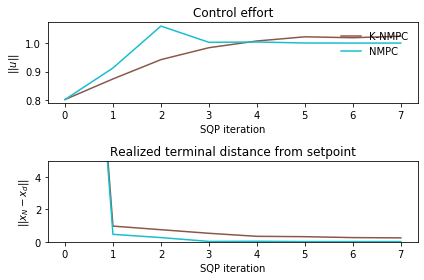

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       8               0.151736              0.116322        1.21389
Koopman bilinear MPC               15               2.42042               1.83928        36.3063


In [22]:
plt.figure(figsize=(6,4))
#plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='K-NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='NMPC')
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2], label=labels[2])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[3], label=labels[3])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [23]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = 5e2*np.diag([1, 1, 1, 2e-1, 2e-1, 2e-1])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 1.
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(300)*dt

# Solver settings closed loop:
polish_osqp = True
max_iter_osqp = 4000
linsys_solver_osqp = 'qdldl'
warm_start_osqp = True

controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCController(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)
controller_bedmd_cl.nom_controller.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

controller_nmpc_cl = NonlinearMPCController(quadrotor_d, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

#### Simulate designed trajectories closed-loop

In [24]:
xs_dmd_cl, us_dmd_cl = quadrotor.simulate(x0_cl, controller_dmd_cl, t_eval_cl)
xs_dmd_cl, us_dmd_cl = xs_dmd_cl.T, us_dmd_cl.T

xs_edmd_cl, us_edmd_cl = quadrotor.simulate(x0_cl, controller_edmd_cl, t_eval_cl)
xs_edmd_cl, us_edmd_cl = xs_edmd_cl.T, us_edmd_cl.T

controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = quadrotor.simulate(x0_cl, controller_bedmd_cl, t_eval_cl)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = quadrotor.simulate(x0_cl, controller_nmpc_cl, t_eval_cl)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[ 1.53185885e-08  1.03918094e-04 -1.54624383e-04  6.12743539e-06
  2.07836186e-02 -3.09248766e-02]
[ 2.46747074e-07  4.22448681e-04 -6.15790114e-04  4.93999366e-05
  4.29224954e-02 -6.13082697e-02]
[ 1.25816847e-06  9.73714093e-04 -1.37625470e-03  1.68411518e-04
  6.73305717e-02 -9.07846484e-02]
[ 4.00300382e-06  1.77946817e-03 -2.42732045e-03  4.02380867e-04
  9.38202032e-02 -1.19428501e-01]
[ 9.82937465e-06  2.85995065e-03 -3.76089195e-03  7.91021880e-04
  1.22276207e-01 -1.47285797e-01]
[ 2.04842824e-05  4.23432592e-03 -5.36930227e-03  1.37438567e-03
  1.52598689e-01 -1.74396268e-01]
[ 3.81163604e-05  5.92081247e-03 -7.24526043e-03  2.19273813e-03
  1.84698365e-01 -2.00795362e-01]
[ 6.52775423e-05  7.93678242e-03 -9.38181118e-03  3.28646564e-03
  2.18495236e-01 -2.26514790e-01]
[ 1.04923902e-04  1.02988502e-02 -1.17722991e-02  4.69600372e-03
  2.53917752e-01 -2.51582795e-01]
[ 1.60415897e-04  1.30229546e-02 -1.44103347e-02  6.46178817e-03
  2.90902350e-01 -2.76024323e-01]
[ 2.355182

[0.86619343 0.47600919 0.05084155 0.92618377 0.06156316 0.16532978]
[0.87543044 0.47661709 0.0524759  0.92119124 0.06001582 0.16154191]
[0.88461673 0.47720969 0.05407222 0.91604047 0.05850287 0.15772208]
[0.89375073 0.47778733 0.0556302  0.91073506 0.0570238  0.15387277]
[0.90283092 0.47835035 0.05714954 0.90527864 0.0555781  0.14999647]
[0.91185581 0.47889907 0.05863001 0.89967486 0.0541653  0.1460957 ]
[0.92082394 0.47943383 0.06007135 0.89392742 0.05278491 0.14217297]
[0.92973389 0.47995494 0.06147337 0.88804003 0.05143646 0.13823079]
[0.93858428 0.48046273 0.06283588 0.88201644 0.05011948 0.13427165]
[0.94737377 0.4809575  0.06415873 0.87586041 0.04883353 0.13029806]
[0.95610105 0.48143956 0.06544178 0.86957574 0.04757816 0.1263125 ]
[0.96476486 0.48190923 0.06668493 0.86316622 0.04635291 0.12231743]
[0.97336397 0.48236678 0.06788809 0.85663567 0.04515735 0.11831532]
[0.98189718 0.48281253 0.06905121 0.84998794 0.04399105 0.11430858]
[0.99036335 0.48324676 0.07017426 0.84322686 0.0

[ 1.47229986e-08  1.40517865e-04 -1.39992854e-04  5.88919944e-06
  2.81035729e-02 -2.79985707e-02]
[ 2.34467860e-07  5.56952882e-04 -5.62018837e-04  4.68646314e-05
  5.51834275e-02 -5.64066259e-02]
[ 1.18471254e-06  1.24054148e-03 -1.26958329e-03  1.57860471e-04
  8.15342790e-02 -8.51062644e-02]
[ 3.74158124e-06  2.18558867e-03 -2.26496386e-03  3.74091243e-04
  1.07475123e-01 -1.13969849e-01]
[ 9.13549909e-06  3.38917961e-03 -3.54932557e-03  7.31207519e-04
  1.33242988e-01 -1.42902494e-01]
[ 1.89571589e-05  4.85079424e-03 -5.12287248e-03  1.26562784e-03
  1.59079797e-01 -1.71806887e-01]
[ 3.51648739e-05  6.57201302e-03 -6.98496637e-03  2.01445550e-03
  1.85163728e-01 -2.00611890e-01]
[ 6.00936234e-05  8.55628060e-03 -9.13421972e-03  3.01593644e-03
  2.11689428e-01 -2.29238781e-01]
[ 9.64650155e-05  1.08087401e-02 -1.15685614e-02  4.30914366e-03
  2.38801942e-01 -2.57629559e-01]
[ 1.47397178e-04  1.33359666e-02 -1.42853456e-02  5.93431434e-03
  2.66642625e-01 -2.85727277e-01]
[ 2.164171

[0.64138969 0.44563577 0.02323111 0.98930236 0.13018058 0.2124199 ]
[0.65127132 0.4469233  0.02532963 0.98698894 0.12732453 0.20728421]
[0.66112881 0.44818256 0.02737725 0.98447641 0.12452711 0.20224082]
[0.67096019 0.44941414 0.02937488 0.98176935 0.12178709 0.1972855 ]
[0.68076356 0.45061859 0.03132338 0.97887227 0.1191033  0.19241421]
[0.69053702 0.45179649 0.03322357 0.97578963 0.11647458 0.18762313]
[0.70027874 0.45294836 0.03507623 0.97252581 0.11389984 0.18290863]
[0.70998694 0.45407476 0.03688211 0.96908513 0.111378   0.17826727]
[0.71965987 0.45517619 0.03864192 0.96547187 0.10890799 0.17369581]
[0.72929581 0.45625318 0.04035636 0.96169023 0.1064888  0.16919117]
[0.73889312 0.45730623 0.04202606 0.95774438 0.10411943 0.16475046]
[0.74845016 0.45833583 0.04365167 0.95363844 0.10179891 0.16037096]
[0.75796536 0.45934246 0.04523378 0.94937646 0.09952628 0.15605013]
[0.76743718 0.4603266  0.04677296 0.94496246 0.09730061 0.15178555]
[0.77686412 0.46128871 0.04826976 0.94040042 0.0

[ 1.38648744  0.49800884  0.05092823  0.26071817  0.00838592 -0.07155298]
[ 1.38906978  0.49809175  0.0502125   0.2557625   0.00819776 -0.07159315]
[ 1.39160292  0.49817281  0.04949653  0.25087687  0.00801438 -0.07160033]
[ 1.39408755  0.49825206  0.04878065  0.24606128  0.00783565 -0.07157513]
[ 1.39652438  0.49832954  0.04806519  0.24131572  0.00766145 -0.0715182 ]
[ 1.3989141   0.4984053   0.04735044  0.23664014  0.00749164 -0.07143019]
[ 1.40125742  0.49847939  0.04663673  0.23203447  0.00732612 -0.07131175]
[ 1.40355502  0.49855184  0.04592436  0.22749859  0.00716475 -0.07116354]
[ 1.40580762  0.4986227   0.04521361  0.22303237  0.00700742 -0.07098624]
[ 1.4080159   0.498692    0.04450478  0.21863563  0.00685402 -0.07078052]
[ 1.41018056  0.49875979  0.04379814  0.21430818  0.00670443 -0.07054705]
[ 1.4123023   0.4988261   0.04309397  0.2100498   0.00655855 -0.07028653]
[ 1.41438179  0.49889098  0.04239254  0.20586024  0.00641628 -0.06999963]
[ 1.41641973  0.49895444  0.04169411  

[ 0.04781706  0.17635364 -0.12995326  0.33848234  0.71040559  0.04963946]
[ 0.05125692  0.18338895 -0.129287    0.34948024  0.69665842  0.08361325]
[ 0.05480458  0.19027256 -0.12828649  0.3600379   0.68006499  0.11648825]
[ 0.05845507  0.19697248 -0.12696442  0.37004343  0.65992028  0.14792595]
[ 0.06220306  0.20345522 -0.12533434  0.37953302  0.63663075  0.17808993]
[ 0.06605584  0.20978934 -0.12337857  0.39099411  0.63019672  0.21306527]
[ 0.07002234  0.21605968 -0.1210701   0.40227065  0.62387537  0.24862723]
[ 0.0740991   0.22225542 -0.11840833  0.41304176  0.61527769  0.28372839]
[ 0.07828106  0.22835456 -0.11539685  0.42330588  0.60455609  0.31856764]
[ 0.08256482  0.23435119 -0.1120395   0.43339545  0.5947752   0.35290191]
[ 0.0869483   0.24025347 -0.10833966  0.44324609  0.58568715  0.38706515]
[ 0.09142802  0.24605977 -0.10429925  0.45263932  0.57557953  0.42101643]
[ 0.09599911  0.25175799 -0.09992655  0.46151456  0.56407008  0.45352485]
[ 0.10065666  0.2573378  -0.09522961  

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

#### Plot/analyze the results

In [ ]:
plot_inds = [0, 1, 2, 0, 1]
subplot_inds = [1, 2, 3, 4, 8]

plt.figure(figsize=(12,3))
for ii in range(5):
    ind = plot_inds[ii]
    if ii < 3:
        ax = plt.subplot(1,4,subplot_inds[ii])
        plt.plot(t_eval_cl, xs_dmd_cl[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval_cl, xs_edmd_cl[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl, xs_bedmd_cl[ind, :], colors[2], label='K-NMPC')
        plt.plot(t_eval_cl, xs_nmpc_cl[ind,:], colors[3], label='NMPC')

        plt.scatter(t_eval_cl[0], x0_cl[ind], color='g')
        plt.scatter(t_eval_cl[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[subplot_inds[ii]-1])
        plt.xlabel('Time (sec)')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    else:
        bx = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval_cl[:-1],us_dmd_cl[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval_cl[:-1], us_edmd_cl[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl[:-1], us_bedmd_cl[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval_cl[:-1],us_nmpc_cl[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval_cl[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval_cl[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii+3])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii] == 4:
            plt.title('Control inputs')
        else:
            plt.xlabel('Time (sec)')
if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop.pdf', format='pdf', dpi=2400)
plt.show()
    
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import ndimage

draw_inds = np.arange(0,t_eval_cl.size)[::50]

plt.figure(figsize=(12,2))
ax = plt.subplot(1,1,1, frameon=False)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='Koopman NMPC closed loop trajectory with quadrotor orientation sampled at 2 hz')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.ylim(-0.1, xs_bedmd[1,-1]+0.3)
plt.legend(loc='upper left', frameon=False)
for ii in draw_inds:
    im_quad = read_png('quad_figure.png')
    im_quad = ndimage.rotate(im_quad, xs_bedmd_cl[2,ii]*180)
    imagebox_quad = OffsetImage(im_quad, zoom=.11)
    ab = AnnotationBbox(imagebox_quad, [xs_bedmd_cl[0,ii], xs_bedmd_cl[1,ii]], frameon=False)
    ax.add_artist(ab)

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop_2.pdf', format='pdf', dpi=2400)
plt.show()

cost_cl_dmd = np.sum(np.diag((xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_dmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_dmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_dmd_cl.T@R_mpc_cl@us_dmd_cl))
cost_cl_edmd = np.sum(np.diag((xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_edmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_edmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_edmd_cl.T@R_mpc_cl@us_edmd_cl))
cost_cl_bedmd = np.sum(np.diag((xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc_cl@us_bedmd_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc_cl@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_cl_dmd/cost_cl_nmpc), np.mean(controller_dmd_cl.nom_controller.comp_time), np.std(controller_dmd_cl.nom_controller.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_cl_edmd/cost_cl_nmpc),np.mean(controller_edmd_cl.nom_controller.comp_time), np.std(controller_edmd_cl.nom_controller.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_cl_bedmd/cost_cl_nmpc), np.mean(controller_bedmd_cl.nom_controller.comp_time), np.std(controller_bedmd_cl.nom_controller.comp_time)],
                ['NMPC (benchmark, known model)',1, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]], 
               headers=['Normalized cost,\nrealized trajectory', 'Mean comp. time (secs)', 'std comp. time (secs)']))